# VAM Tutorial (Simple)

::: {.callout-note title="Reference"}
The following the model is described in the paper: 

```
 @article{Escalante_2024, 
    title={Vertically averaged and moment equations: New derivation, efficient numerical solution and comparison with other physical approximations for modeling non-hydrostatic free surface flows}, 
    volume={504}, 
    ISSN={00219991}, 
    DOI={10.1016/j.jcp.2024.112882}, 
    journal={Journal of Computational Physics}, 
    author={Escalante, C. and Morales De Luna, T. and Cantero-Chinchilla, F. and Castro-Orgaz, O.}, 
    year={2024}, 
    month=may, 
    pages={112882}, 
    language={en} 
}
```

:::



## Imports

In [2]:
# | code-fold: true
# | code-summary: "Load packages"
# | output: false

import os
import numpy as np
import jax
from jax import numpy as jnp
import pytest
from types import SimpleNamespace
from sympy import cos, pi, symbols, Derivative, Function, exp, I, Rational, Derivative, init_printing
from time import time as gettime

from library.fvm.solver import Solver, Settings
from library.fvm.ode import RK1
import library.fvm.reconstruction as recon
import library.fvm.timestepping as timestepping
import library.fvm.flux as flux
import library.fvm.nonconservative_flux as nc_flux
from library.model.boundary_conditions import BoundaryCondition
from library.model.models.basisfunctions import Basisfunction, Legendre_shifted
from library.model.models.basismatrices import Basismatrices

from library.model.model import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
import library.misc.io as io
from library.mesh.mesh import compute_derivatives
from tests.pdesoft import plots_paper
import library.model.analysis as analysis

import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
from library.mesh.mesh import convert_mesh_to_jax
import argparse

init_printing(use_latex=True)

No module named 'precice'


## Model definition

In [3]:
class VAMHyperbolic(Model):
    def __init__(
        self,
        boundary_conditions=None,
        initial_conditions=None,
        dimension=1,
        fields=6,
        aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],
        parameters={},
        parameters_default={"g": 9.81},
        settings={},
        settings_default={},
    ):
        self.variables = register_sympy_attribute(fields, "q")
        self.n_fields = self.variables.length()
        super().__init__(
            dimension=dimension,
            fields=fields,
            aux_fields=aux_fields,
            parameters=parameters,
            parameters_default=parameters_default,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            settings={**settings_default, **settings},
        )
        
    def flux(self):
        fx = Matrix([0 for i in range(self.n_fields)])
        hw2 = self.aux_variables.hw2
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        hw0 = self.variables[3]
        hw1 = self.variables[4]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h
        w0 = hw0 / h
        w1 = hw1 / h
        
        fx[0] = hu0
        fx[1] = hu0 * u0 + 1/3 * hu1 * u1
        fx[2] = 2*hu0 * u1
        fx[3] = hu0 * w0 + 1/3 * hu1 * w1
        fx[4] = hu0 * w1 + u1 * (hw0 + 2/5*hw2)
        
        return [fx]

    def nonconservative_matrix(self):
        nc = Matrix([[0 for i in range(self.n_fields)] for j in range(self.n_fields)])

        hw2 = self.aux_variables.hw2
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        hw0 = self.variables[3]
        hw1 = self.variables[4]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h
        w0 = hw0 / h
        w1 = hw1 / h
        w2 = hw2 / h

        nc[1, 0] = param.g * h
        nc[1, 5] = param.g * h
        nc[2, 3] = -u0
        nc[4, 2] = + 1/5 * w2 - w0
        return [-nc]
    
    def eigenvalues(self):
        ev = Matrix([0 for i in range(self.n_fields)])
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h

        ev[0] = u0
        ev[1] = u0 + 1/sqrt(3) * u1
        ev[2] = u0 - 1/sqrt(3) * u1
        ev[3] = u0 + sqrt(param.g * h + u1**2)
        ev[4] = u0 - sqrt(param.g * h + u1**2)
        ev[5] = 0
        
        return ev

    def source_implicit(self):
        R = Matrix([0 for i in range(self.n_fields)])
        hw2 = self.aux_variables.hw2
        h = self.variables[0]
        hu0 = self.variables[1]
        hu1 = self.variables[2]
        hw0 = self.variables[3]
        hw1 = self.variables[4]
        b = self.variables[5]
        param = self.parameters

        u0 = hu0 / h
        u1 = hu1 / h
        w0 = hw0 / h
        w1 = hw1 / h
        w2 = hw2 /h  


        p0 = self.aux_variables.p0
        p1 = self.aux_variables.p1
        dbdx = self.aux_variables.dbdx
        dhdx = self.aux_variables.dhdx
        dhp0dx = self.aux_variables.dhp0dx
        dhp1dx = self.aux_variables.dhp1dx

        R[0] = 0
        R[1] = dhp0dx + 2 * p1 * dbdx 
        R[2] = dhp1dx - (3*p0 - p1)*dhdx  -6*(p0-p1)*dbdx
        R[3] = -2*p1
        R[4] = 6*(p0-p1)
        R[5] = 0
        return -R
        
    def constraints(self):
        C = Matrix([0 for i in range(3)])
        param = self.parameters
        
        t = model.time
        x = model.position[0]
        q0 = self.variables[0]
        q1 = self.variables[1]
        q2 = self.variables[2]
        q3 = self.variables[3]
        q4 = self.variables[4]
        q5 = self.variables[5]
        h = q0
        u0 = q1/h
        u1 = q2/h
        w0 = q3/h
        w1 = q4/h
        b = q5
        w2 = self.aux_variables.hw2 / q0
        
        C[0] = h * Derivative(u0, x) + Rational(1,3) * Derivative(h*u1, x) + Rational(1,3) * u1 * Derivative(h, x) + 2*(w0 - u0 * Derivative(b, x)) 
        C[1] = h * Derivative(u0, x) + u1 * Derivative(h, x) + 2*(u1 * Derivative(b,x) - w1)
        C[2] = h * Derivative(u0, x) + u1 * Derivative(h, x) + 2*(w0 + w2 - u0 *  Derivative(b, x))
        return C
        
        
        

In [4]:
model = VAMHyperbolic()

## Linear stability analysis

In [5]:

analyzer = analysis.ModelAnalyser(model)
h0, b0 = symbols('h_c b_c')
eps = analyzer.get_eps()
h, u0, u1, w0, w1, w2, p0, p1 = analyzer.create_functions_from_list(['h', 'u_0', 'u_1', 'w_0', 'w_1', 'w_2', 'p_0', 'p_1'])
t, x, y, z = analyzer.get_time_space()
Q = Matrix([h0 + eps * h, (h0 + eps * h) * eps * u0, (h0 + eps * h) * eps * u1, (h0 + eps * h) * eps * w0, (h0 + eps * h)* eps * w1, b0])
Qaux = Matrix([(h0 + eps * h) * eps*w2, eps*p0, eps*p1, diff(b0, x), diff(h0 + eps * h, x), diff((h0 + eps * h) * eps * p0, x), diff((h0 + eps * h) * eps * p1, x)])

linearized_system = analyzer.linearize_system(Q, Qaux, constraints = model.constraints())

In [6]:
analyzer.print_equations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
linearized_system = analyzer.delete_equations([5])

In [8]:
analyzer.print_equations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [9]:
analyzer.insert_plane_wave_ansatz([h, u0, u1, w0, w1])

In [10]:
analyzer.print_equations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

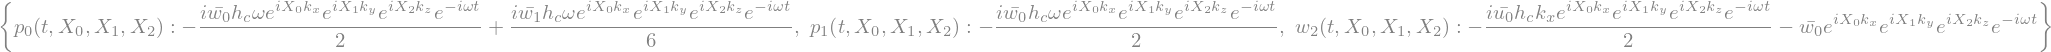

In [11]:
analyzer.solve_for_constraints([3, 4, 7], [p0, p1, w2])

In [12]:
analyzer.print_equations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [13]:
analyzer.remove_exponential()

In [14]:
analyzer.print_equations()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

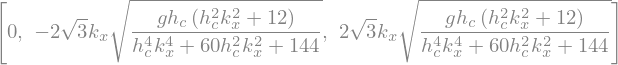

In [15]:
dispersion_relation = analyzer.solve_for_dispersion_relation()
dispersion_relation

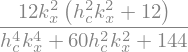

In [16]:
group_velocity = dispersion_relation[1]**2 / model.parameters.g / h0
group_velocity

## Numerical solution

In [17]:
class VAMPoisson(Model):
    def __init__(
        self,
        boundary_conditions,
        initial_conditions,
        dimension=1,
        fields=['p0', 'p1'],
        aux_fields=['dp0dx', 'ddp0dxx', 'dp1dx', 'ddp1dxx', 'd4p0dx4', 'd4p1dx4', 'h', 'dbdx', 'ddbdxx', 'dhdx', 'ddhdxx', 'u0', 'du0dx', 'w0', 'w1', 'u1', 'du1dx', 'dt'],
        parameters={},
        parameters_default={"g": 9.81},
        settings={},
        settings_default={},
    ):
        self.variables = register_sympy_attribute(fields, "q")
        self.n_fields = self.variables.length()
        super().__init__(
            dimension=dimension,
            fields=fields,
            aux_fields=aux_fields,
            parameters=parameters,
            parameters_default=parameters_default,
            boundary_conditions=boundary_conditions,
            initial_conditions=initial_conditions,
            settings={**settings_default, **settings},
        )

    def source_implicit(self):
        R = Matrix([0 for i in range(self.n_fields)])

        h = self.aux_variables.h
        p0 = self.variables.p0
        p1 = self.variables.p1
        dt = self.aux_variables.dt

        dbdx   = self.aux_variables.dbdx
        ddbdxx = self.aux_variables.ddbdxx

        dhdx   = self.aux_variables.dhdx
        ddhdxx = self.aux_variables.ddhdxx
        
        dp0dx = self.aux_variables.dp0dx
        dp1dx = self.aux_variables.dp1dx
        ddp0dxx = self.aux_variables.ddp0dxx
        ddp1dxx = self.aux_variables.ddp1dxx

        d4p0dx4 = self.aux_variables.d4p0dx4
        d4p1dx4 = self.aux_variables.d4p1dx4
        
        
        #Note, these are not truly the values from the old time step, but rather the values from the middle state after hyperbolic step
        oldu0 = self.aux_variables.u0
        doldu0dx = self.aux_variables.du0dx
        oldw1 = self.aux_variables.w1
        oldw0 = self.aux_variables.w0
        oldu1 = self.aux_variables.u1
        doldu1dx = self.aux_variables.du1dx

        I1 = -1/3*dt*(-(3*p0 - p1)*ddhdxx - (6*p0 - 6*p1)*ddbdxx - (3*dp0dx - dp1dx)*dhdx - (6*dp0dx - 6*dp1dx)*dbdx + h*ddp1dxx + p1*ddhdxx + 2*dhdx*dp1dx) - 2*(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dbdx/h + 1/3*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dhdx/h + 2*(2*dt*p1 + h*oldw0)/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h + 1/3*h*doldu1dx + 1/3*oldu1*dhdx
        I2 =-2*(-dt*(6*p0 - 6*p1) + h*oldw1)/h + 2*(-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dbdx/h + (-dt*(-(3*p0 - p1)*dhdx - (6*p0 - 6*p1)*dbdx + h*dp1dx + p1*dhdx) + h*oldu1)*dhdx/h + (-(-dt*(h*dp0dx + p0*dhdx + 2*p1*dbdx) + h*oldu0)*dhdx/h**2 + (-dt*(h*ddp0dxx + p0*ddhdxx + 2*p1*ddbdxx + 2*dbdx*dp1dx + 2*dhdx*dp0dx) + h*doldu0dx + oldu0*dhdx)/h)*h 
        R[0] = I1 
        R[1] = I2

        return R
    
    def eigenvalues(self):
        ev = Matrix([0 for i in range(self.n_fields)])
        return ev


### Solver definitions

In [18]:
class HyperbolicSolver(Solver):

    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):

        h=Q[0]
        hu0=Q[1]
        hu1=Q[2]
        hw0=Q[3]
        hw1=Q[4]
        b=Q[5]
        
        w0 = hw0 / h
        w1 = hw1 / h
        u0 = hu0 / h
        u1 = hu1 / h
        # aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],

        dbdx  = compute_derivatives(b, mesh, derivatives_multi_index=([[1]]))[:,0]
        Qaux = Qaux.at[3].set(dbdx)
        
        hw2 = h*(-(w0 + w1) + (u0 + u1) * dbdx)
        Qaux = Qaux.at[0].set(hw2)
        
        
        dhdx   = compute_derivatives(h, mesh, derivatives_multi_index=([[1]]))[:, 0]
        Qaux = Qaux.at[4].set(dhdx)
        return Qaux
    
    # @partial(jax.jit, static_argnames=["self", "mesh", "pde"])
    def compute_source_pressure(self, mesh, pde):
        @jax.jit
        def f(dt, Q, Qaux, parameters):
            dQ = jnp.zeros_like(Q)
            dQ = dQ.at[:, : mesh.n_inner_cells].set(
                pde.source_implicit(
                    Q[:, : mesh.n_inner_cells],
                    Qaux[:, : mesh.n_inner_cells],
                    parameters,
                )
            )
            return Q + dt * dQ
        return f


In [19]:
class PoissonSolver(Solver):
    def update_qaux(self, Q, Qaux, Qold, Qauxold, mesh, model, parameters, time, dt):

        p0 = Q[0]
        p1 = Q[1]
        

        #  aux_fields=[ 'dp0dx', 'ddp0dxx', 'dp1dx', 'ddp1dxx', 'h', 'dbdx', 'ddbdxx', 'dhdx', 'ddhdxx', 'u0', 'du0dx', 'w0', 'w1', 'u1', 'du1dx', 'dt'],

        dp0dx = compute_derivatives(p0, mesh, derivatives_multi_index=([[1]]))[:, 0]
        ddp0dxx = compute_derivatives(p0, mesh, derivatives_multi_index=([[2]]))[:, 0]
        dp1dx = compute_derivatives(p1, mesh, derivatives_multi_index=([[1]]))[:, 0]
        ddp1dxx = compute_derivatives(p1, mesh, derivatives_multi_index=([[2]]))[:, 0]

        d4p0dx4 = compute_derivatives(p0, mesh, derivatives_multi_index=([[4]]))[:, 0]
        d4p1dx4 = compute_derivatives(p1, mesh, derivatives_multi_index=([[4]]))[:, 0]

        Qaux = Qaux.at[0].set(dp0dx)
        Qaux = Qaux.at[1].set(ddp0dxx)
        Qaux = Qaux.at[2].set(dp1dx)
        Qaux = Qaux.at[3].set(ddp1dxx)
        Qaux = Qaux.at[4].set(d4p0dx4)
        Qaux = Qaux.at[5].set(d4p1dx4)

        return Qaux


In [20]:
def solve_vam(
    mesh, model1, model2, settings, ode_solver_flux=RK1, ode_solver_source=RK1
):
    solverQ = HyperbolicSolver()
    solverP = PoissonSolver()
    
    Q, Qaux = solverQ.initialize(model1, mesh)
    P, Paux = solverP.initialize(model2, mesh)

    parameters1 = model1.parameter_values
    parameters2 = model2.parameter_values

    parameters1 = jnp.asarray(parameters1)
    parameters2 = jnp.asarray(parameters2)
    
    mesh = convert_mesh_to_jax(mesh)


    pde1, bcs1 = solverQ.transform_in_place(model1)
    pde2, bcs2 = solverP.transform_in_place(model2)
    output_hdf5_path = os.path.join(settings.output.directory, f"{settings.name}.h5")
    save_fields = io.get_save_fields(output_hdf5_path, settings.output_write_all)

    def run(Q, Qaux, parameters1, pde1, bcs1, P, Paux, parameters2, pde2, bcs2):
        iteration = 0.0
        time = 0.0
        assert model1.dimension == mesh.dimension
        assert model2.dimension == mesh.dimension

        i_snapshot = 0.0
        dt_snapshot = settings.time_end / (settings.output_snapshots - 1)
        io.init_output_directory(settings.output.directory, settings.output_clean_dir)
        mesh.write_to_hdf5(output_hdf5_path)
        _ = save_fields(time, 0.0, i_snapshot, Q, Qaux)
        i_snapshot = save_fields(time, 0.0, i_snapshot, Q, Qaux)

        Q0 = Q
        Qnew = Q
        Pnew = P
        Qauxnew = Qaux
        Pauxnew = Paux

        min_inradius = jnp.min(mesh.cell_inradius)


        compute_max_abs_eigenvalue = solverQ.get_compute_max_abs_eigenvalue(
            mesh, pde1, settings
        )
        flux_operator = solverQ.get_flux_operator(
            mesh, pde1, bcs1, settings
        )
        source_operator = solverQ.get_compute_source(mesh, pde1, settings)
        boundary_operator1 = solverQ.get_apply_boundary_conditions(mesh, bcs1)
        
        source_operator2 = solverP.get_compute_source(mesh, pde2, settings)
        boundary_operator2 = solverP.get_apply_boundary_conditions(mesh, bcs2)
        
        pressure_correction = solverQ.compute_source_pressure(mesh, pde1)

        time_start = gettime()

        @jax.jit
        def time_loop(time, iteration, i_snapshot, Q, Qaux, Pnew, Paux, Qold, Qauxold, Pold, Pauxold):
            loop_val = (time, iteration, i_snapshot, Q, Qaux, Pnew, Paux, Qold, Qauxold, Pold, Pauxold)

            def loop_body(init_value):
                time, iteration, i_snapshot, Q, Qaux, P, Paux, Qold, Qauxold, Pold, Pauxold = init_value

                dt = settings.compute_dt(
                    Q, Qaux, parameters1, min_inradius, compute_max_abs_eigenvalue
                )
                
                def step(Q, Qaux, P, Paux):

                    #############################################################
                    #####################VELOCITY PREDICTOR######################
                    #############################################################
                    Qauxnew = solverQ.update_qaux(
                        Q, Qaux, Qold, Qauxold, mesh, pde1, parameters1, time, dt
                    )
                    Q1 = ode_solver_flux(
                        flux_operator, Q, Qauxnew, parameters1, dt
                    )

                    Q1 = Q1.at[5].set(Q0[5])

                    Qauxnew = solverQ.update_qaux(
                        Q1, Qauxnew, Qold, Qauxold, mesh, pde1, parameters1, time, dt
                    )
                    #Qnew = ode_solver_source(
                    #    source_operator,
                    #    Q1,
                    #    Qauxnew,
                    #    parameters1,
                    #    dt,
                    #    func_jac=solverQ.compute_source_jac,
                    #)

                    #Qauxnew = solverQ.update_qaux(
                    #    Qnew, Qauxnew, Q, Qaux, mesh, pde1, parameters1, time, dt
                    #)
                    Qnew = Q1
                    Qnew = boundary_operator1(time, Qnew, Qauxnew, parameters1)


                    #############################################################
                    #########################PRESSURE############################
                    #############################################################
                    
                    #        aux_fields=['dp0dx', 'ddp0dxx', 'dp1dx', 'ddp1dxx','h', 'dbdx', 'ddbdxx', 'dhdx', 'ddhdxx', 'u0', 'du0dx', 'w0', 'w1', 'u1', 'du1dx'],
                    #         aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],

                    h = Q[0]
                    u0 = Q[1]/h
                    u1 = Q[2]/h
                    w0 = Q[3]/h
                    w1 = Q[4]/h
                    b = Q[5]
                    
                    dbdx = Qaux[3]
                    ddbdxx = compute_derivatives(b, mesh, derivatives_multi_index=([[2]]))[:, 0]
                    dhdx = Qaux[4]
                    ddhdxx = compute_derivatives(h, mesh, derivatives_multi_index=([[2]]))[:, 0]
                    du0dx = compute_derivatives(u0, mesh, derivatives_multi_index=([[1]]))[:, 0]
                    du1dx = compute_derivatives(u1, mesh, derivatives_multi_index=([[1]]))[:, 0]

                    offset = 2
                    Paux = Paux.at[4+offset].set(h)
                    Paux = Paux.at[5+offset].set(dbdx)
                    Paux = Paux.at[6+offset].set(ddbdxx)
                    Paux = Paux.at[7+offset].set(dhdx)
                    Paux = Paux.at[8+offset].set(ddhdxx)
                    Paux = Paux.at[9+offset].set(u0)
                    Paux = Paux.at[10+offset].set(du0dx)
                    Paux = Paux.at[11+offset].set(w0)
                    Paux = Paux.at[12+offset].set(w1)
                    Paux = Paux.at[13+offset].set(u1)
                    Paux = Paux.at[14+offset].set(du1dx)
                    Paux = Paux.at[15+offset].set(dt)

                    Paux = solverP.update_qaux(
                        P, Paux, Pold, Pauxold, mesh, pde2, parameters2, time, dt
                    )

                    def residual(P):

                    
                        # dp0dx = compute_derivatives(P[0], mesh, derivatives_multi_index=([[1]]))[:, 0]
                        # ddp0dxx = compute_derivatives(P[0], mesh, derivatives_multi_index=([[2]]))[:, 0]
                        # dp1dx = compute_derivatives(P[1], mesh, derivatives_multi_index=([[1]]))[:, 0]
                        # ddp1dxx = compute_derivatives(P[1], mesh, derivatives_multi_index=([[2]]))[:, 0]


                        paux = solverP.update_qaux(P, Paux, Pold, Pauxold, mesh, pde2, parameters2, time, dt)

                        res = pde2.source_implicit(P, paux, parameters2)
                        res = res.at[:, mesh.n_inner_cells:].set(0.)
                        return res


                    Pnew = solverP.implicit_solve(P, Paux, Pold, Pauxold, mesh, model2, pde2, parameters2, time, dt, boundary_operator2, debug=[True, False], user_residual=residual)

                    ############################################################
                    ########################CORRECTOR###########################
                    ############################################################
                    
                    #         aux_fields=['hw2', 'p0', 'p1', 'dbdx', 'dhdx', 'dhp0dx', 'dhp1dx'],
                    Pauxnew = solverP.update_qaux(
                        Pnew, Paux, Pold, Pauxold, mesh, pde2, parameters2, time, dt
                    )
                    Qauxnew = Qauxnew.at[1].set(Pnew[0])
                    Qauxnew = Qauxnew.at[2].set(Pnew[1])
                    h =  Qnew[0]
                    
                    dhp0dx = compute_derivatives(h*Pnew[0], mesh, derivatives_multi_index=([[1]]))[:, 0]
                    dhp1dx = compute_derivatives(h*Pnew[1], mesh, derivatives_multi_index=([[1]]))[:, 0]

                    Qauxnew = Qauxnew.at[5].set(dhp0dx)
                    Qauxnew = Qauxnew.at[6].set(dhp1dx)
                    # Qauxnew = solverQ.update_qaux(
                    #     Qnew, Qauxnew, Qold, Qauxold, mesh, pde1, parameters1, time, dt
                    # )
                    # Qnew = boundary_operator1(time, Qnew, Qauxnew, parameters1)

                    Qnew = pressure_correction(dt, Qnew, Qauxnew, parameters1)
                    Qauxnew = solverQ.update_qaux(
                        Qnew, Qauxnew, Qold, Qauxold, mesh, pde1, parameters1, time, dt
                    )
                    Qnew = boundary_operator1(time, Qnew, Qauxnew, parameters1)
                    return Qnew, Qauxnew, Pnew, Pauxnew
            
                Qnew, Qauxnew, Pnew, Pauxnew = step(Q, Qaux, P, Paux)
                Qnew, Qauxnew, Pnew, Pauxnew = step(Qnew, Qauxnew, Pnew, Pauxnew)
                Qnew = 0.5 * (Qold + Qnew)
                Pnew = 0.5 * (Pold + Pnew)
                Qauxnew = solverQ.update_qaux(
                    Qnew, Qauxnew, Qold, Qauxold, mesh, pde1, parameters1, time, dt)
                
                # Update solution and time
                time += dt
                iteration += 1
                
                time_stamp = (i_snapshot + 1) * dt_snapshot

                jax.debug.print(
                    "iteration: {iteration}, time: {time}, dt: {dt}, i_snapshot: {i_snapshot}, time_stamp: {time_stamp}",
                    iteration=iteration,
                    time=time,
                    dt=dt,
                    i_snapshot=i_snapshot,
                    time_stamp=time_stamp
                )
                i_snapshot = save_fields(time, time_stamp, i_snapshot, Qnew, Qauxnew)


                return (time, iteration, i_snapshot, Qnew, Qauxnew, Pnew, Pauxnew, Q, Qaux, P, Paux)

            def proceed(loop_val):
                time, iteration, i_snapshot, Q, Qaux, P, Paux, Qold, Qauxold, Pold, Pauxold = loop_val
                return time < settings.time_end

            (time, iteration, i_snapshot, Q, Qaux, P, Paux, Qold, Qauxold, Pold, Pauxold) = jax.lax.while_loop(
                proceed, loop_body, loop_val
            )
            
            return P, Paux

        P, Paux = time_loop(time, iteration, i_snapshot, Qnew, Qauxnew, Pnew, Pauxnew, Q, Qaux, P, Paux)
        return P, Paux

    time_start = gettime()
    P, Paux = run(Q, Qaux, parameters1, pde1, bcs1, P, Paux, parameters2, pde2, bcs2)

    print(f"Runtime: {gettime() - time_start}")

    return P, Paux



### Simulation

In [21]:
settings = Settings(
    name="VAM",
    compute_dt=timestepping.adaptive(CFL=0.4),
    time_end=50.,
    output_snapshots=100,
    output_dir="outputs/vam",
)

bc_tags = ["left", "right"]
bc_tags_periodic_to = ["right", "left"]

bcs1 = BC.BoundaryConditions(
    [
        BC.Lambda(physical_tag='left', prescribe_fields={
            1: lambda t, x, dx, q, qaux, p, n: .11197,
            2: lambda t, x, dx, q, qaux, p, n: 0.,
            3: lambda t, x, dx, q, qaux, p, n: 0.,
            4: lambda t, x, dx, q, qaux, p, n: 0.
        }),
        BC.Extrapolation(physical_tag='right')

    ]
)

bcs2 = BC.BoundaryConditions(
    [
        BC.Extrapolation(physical_tag='left'),
        BC.Extrapolation(physical_tag='right'),
    ]
)

def custom_ic1(x):
    Q = np.zeros(6, dtype=float)
    Q[1] = np.where(x[0]-5 < 1, 0.0, 0.)
    Q[5] = 0.20*np.exp(-(x[0]-0.)**2 / (2*0.2**2)) 
    Q[0] = np.where(x[0] < 1, 0.34, 0.015) - Q[5]
    Q[0] = np.where(Q[0] > 0.015, Q[0], 0.015)
    # Q[0] = np.where(x[0]**2 < 0.5, 0.2, 0.1)
    return Q

def custom_ic2(x):
    Q = np.zeros(2, dtype=float)
    return Q

ic1 = IC.UserFunction(custom_ic1)
ic2 = IC.UserFunction(custom_ic2)


model1 = VAMHyperbolic(
    parameters={"g": 9.81},
    boundary_conditions=bcs1,
    initial_conditions=ic1,
    settings={},
)

model2 = VAMPoisson(
    parameters={"g": 9.81},
    boundary_conditions=bcs2,
    initial_conditions=ic2,
    settings={},
)

mesh = petscMesh.Mesh.create_1d((-1.5, 1.5), 60, lsq_degree=2)

Q, Qaux = solve_vam(
    mesh,
    model1,
    model2,
    settings,
)
io.generate_vtk(os.path.join(settings.output.directory, f"{settings.name}.h5"))



iteration: 1.0, time: 0.01095105684851627, dt: 0.01095105684851627, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 0.000e+00
Newton Iter 0: residual norm = 2.332e+00
Newton Iter 1: residual norm = 5.153e-06
Newton Iter 2: residual norm = 3.885e-12
iteration: 2.0, time: 0.020926463924177713, dt: 0.009975407075661441, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 5.959e-01
Newton Iter 1: residual norm = 4.867e-07
Newton Iter 0: residual norm = 8.838e-01
Newton Iter 1: residual norm = 6.256e-07
iteration: 3.0, time: 0.030869248991761165, dt: 0.009942785067583452, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 6.168e-01
Newton Iter 1: residual norm = 4.109e-07
Newton Iter 0: residual norm = 8.713e-01
Newton Iter 1: residual norm = 7.029e-07
iteration: 4.0, time: 0.04039799004889763, dt: 0.00952874105713647, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 4.496e-01

Newton Iter 1: residual norm = 5.165e-08
iteration: 16.0, time: 0.1504053578110819, dt: 0.0090423635392304, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 1.143e-01
Newton Iter 1: residual norm = 5.220e-07
Newton Iter 0: residual norm = 1.062e-01
Newton Iter 1: residual norm = 3.867e-08
iteration: 17.0, time: 0.1594421798966003, dt: 0.009036822085518393, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 1.060e-01
Newton Iter 1: residual norm = 5.001e-07
Newton Iter 0: residual norm = 9.672e-02
Newton Iter 1: residual norm = 8.007e-08
iteration: 18.0, time: 0.16847176560889712, dt: 0.009029585712296815, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 9.754e-02
Newton Iter 1: residual norm = 4.086e-07
Newton Iter 0: residual norm = 9.129e-02
Newton Iter 1: residual norm = 4.951e-07
iteration: 19.0, time: 0.17749662874509514, dt: 0.009024863136198028, i_snapshot: 1.0, time_stamp: 1.0101010101010102

iteration: 33.0, time: 0.3034396363161563, dt: 0.008976130953469637, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 4.876e-02
Newton Iter 1: residual norm = 4.174e-08
Newton Iter 0: residual norm = 4.804e-02
Newton Iter 1: residual norm = 4.359e-08
iteration: 34.0, time: 0.31239297895859597, dt: 0.008953342642439688, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 4.767e-02
Newton Iter 1: residual norm = 2.927e-08
Newton Iter 0: residual norm = 4.699e-02
Newton Iter 1: residual norm = 1.197e-07
iteration: 35.0, time: 0.32129375730803383, dt: 0.008900778349437886, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 4.661e-02
Newton Iter 1: residual norm = 4.657e-08
Newton Iter 0: residual norm = 4.603e-02
Newton Iter 1: residual norm = 4.267e-08
iteration: 36.0, time: 0.3301469217413093, dt: 0.008853164433275457, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 4.572e-

Newton Iter 1: residual norm = 3.101e-08
iteration: 53.0, time: 0.47535931275511273, dt: 0.008325082219891748, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 3.577e-02
Newton Iter 1: residual norm = 3.523e-08
Newton Iter 0: residual norm = 3.494e-02
Newton Iter 1: residual norm = 2.380e-08
iteration: 54.0, time: 0.4836618921798172, dt: 0.008302579424704465, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 3.515e-02
Newton Iter 1: residual norm = 2.821e-08
Newton Iter 0: residual norm = 3.429e-02
Newton Iter 1: residual norm = 2.822e-08
iteration: 55.0, time: 0.4919444301854784, dt: 0.00828253800566122, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 3.452e-02
Newton Iter 1: residual norm = 2.777e-08
Newton Iter 0: residual norm = 3.363e-02
Newton Iter 1: residual norm = 2.530e-08
iteration: 56.0, time: 0.5002091934810928, dt: 0.008264763295614465, i_snapshot: 1.0, time_stamp: 1.0101010101010102

Newton Iter 1: residual norm = 2.040e-08
Newton Iter 0: residual norm = 2.229e-02
Newton Iter 1: residual norm = 2.107e-08
iteration: 73.0, time: 0.638591549516135, dt: 0.008058334440320896, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 2.250e-02
Newton Iter 1: residual norm = 1.667e-08
Newton Iter 0: residual norm = 2.168e-02
Newton Iter 1: residual norm = 2.148e-08
iteration: 74.0, time: 0.646642851060727, dt: 0.00805130154459213, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 2.188e-02
Newton Iter 1: residual norm = 1.812e-08
Newton Iter 0: residual norm = 2.107e-02
Newton Iter 1: residual norm = 1.635e-08
iteration: 75.0, time: 0.6546883337723589, dt: 0.008045482711631895, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 2.128e-02
Newton Iter 1: residual norm = 1.398e-08
Newton Iter 0: residual norm = 2.048e-02
Newton Iter 1: residual norm = 1.572e-08
iteration: 76.0, time: 0.662728943082

Newton Iter 1: residual norm = 8.823e-09
Newton Iter 0: residual norm = 1.277e-02
Newton Iter 1: residual norm = 1.011e-08
iteration: 92.0, time: 0.7909500934717675, dt: 0.008018574108583266, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 1.294e-02
Newton Iter 1: residual norm = 1.048e-08
Newton Iter 0: residual norm = 1.239e-02
Newton Iter 1: residual norm = 1.222e-08
iteration: 93.0, time: 0.7989718734056045, dt: 0.008021779933837044, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 1.256e-02
Newton Iter 1: residual norm = 1.185e-08
Newton Iter 0: residual norm = 1.203e-02
Newton Iter 1: residual norm = 1.010e-08
iteration: 94.0, time: 0.8069971204435589, dt: 0.008025247037954404, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 1.219e-02
Newton Iter 1: residual norm = 1.127e-08
Newton Iter 0: residual norm = 1.168e-02
Newton Iter 1: residual norm = 1.043e-08
iteration: 95.0, time: 0.815026063

iteration: 110.0, time: 0.9359805341732786, dt: 0.008095044572138952, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 7.586e-03
Newton Iter 1: residual norm = 7.583e-09
Newton Iter 0: residual norm = 7.408e-03
Newton Iter 1: residual norm = 6.577e-09
iteration: 111.0, time: 0.9440798634190236, dt: 0.008099329245745013, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 7.368e-03
Newton Iter 1: residual norm = 5.917e-09
Newton Iter 0: residual norm = 7.213e-03
Newton Iter 1: residual norm = 5.666e-09
iteration: 112.0, time: 0.9521833878973145, dt: 0.008103524478290899, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 7.156e-03
Newton Iter 1: residual norm = 5.672e-09
Newton Iter 0: residual norm = 7.025e-03
Newton Iter 1: residual norm = 5.171e-09
iteration: 113.0, time: 0.9602910096164717, dt: 0.008107621719157273, i_snapshot: 1.0, time_stamp: 1.0101010101010102
Newton Iter 0: residual norm = 6.951

Newton Iter 1: residual norm = 2.663e-09
Newton Iter 0: residual norm = 4.860e-03
Newton Iter 1: residual norm = 4.192e-09
iteration: 130.0, time: 1.0986276785950044, dt: 0.00815788385197781, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 4.447e-03
Newton Iter 1: residual norm = 2.713e-09
Newton Iter 0: residual norm = 4.787e-03
Newton Iter 1: residual norm = 3.193e-09
iteration: 131.0, time: 1.10678731763567, dt: 0.008159639040665455, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 4.355e-03
Newton Iter 1: residual norm = 3.901e-09
Newton Iter 0: residual norm = 4.719e-03
Newton Iter 1: residual norm = 3.181e-09
iteration: 132.0, time: 1.1149485900906753, dt: 0.00816127245500521, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 4.268e-03
Newton Iter 1: residual norm = 3.104e-09
Newton Iter 0: residual norm = 4.656e-03
Newton Iter 1: residual norm = 3.672e-09
iteration: 133.0, time: 1.123111378

Newton Iter 1: residual norm = 4.053e-09
iteration: 149.0, time: 1.2538464906853595, dt: 0.008175429115275702, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 3.539e-03
Newton Iter 1: residual norm = 1.761e-09
Newton Iter 0: residual norm = 4.146e-03
Newton Iter 1: residual norm = 3.738e-09
iteration: 150.0, time: 1.2620222906579759, dt: 0.008175799972616367, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 3.528e-03
Newton Iter 1: residual norm = 2.168e-09
Newton Iter 0: residual norm = 4.137e-03
Newton Iter 1: residual norm = 3.541e-09
iteration: 151.0, time: 1.270198449031935, dt: 0.008176158373958931, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 3.519e-03
Newton Iter 1: residual norm = 2.521e-09
Newton Iter 0: residual norm = 4.128e-03
Newton Iter 1: residual norm = 2.696e-09
iteration: 152.0, time: 1.27837495917482, dt: 0.008176510142884993, i_snapshot: 2.0, time_stamp: 1.515151515151515

Newton Iter 1: residual norm = 2.849e-09
Newton Iter 0: residual norm = 3.985e-03
Newton Iter 1: residual norm = 2.998e-09
iteration: 169.0, time: 1.4174475039346528, dt: 0.008186200554079927, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 3.416e-03
Newton Iter 1: residual norm = 3.295e-09
Newton Iter 0: residual norm = 3.972e-03
Newton Iter 1: residual norm = 3.173e-09
iteration: 170.0, time: 1.4256347050045042, dt: 0.008187201069851466, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 3.403e-03
Newton Iter 1: residual norm = 3.265e-09
Newton Iter 0: residual norm = 3.957e-03
Newton Iter 1: residual norm = 3.774e-09
iteration: 171.0, time: 1.433822969912405, dt: 0.008188264907900752, i_snapshot: 2.0, time_stamp: 1.5151515151515151
Newton Iter 0: residual norm = 3.390e-03
Newton Iter 1: residual norm = 3.226e-09
Newton Iter 0: residual norm = 3.941e-03
Newton Iter 1: residual norm = 3.698e-09
iteration: 172.0, time: 1.442012

Newton Iter 1: residual norm = 2.658e-09
iteration: 188.0, time: 1.5732489916548549, dt: 0.008216123906131124, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 2.977e-03
Newton Iter 1: residual norm = 1.780e-09
Newton Iter 0: residual norm = 3.539e-03
Newton Iter 1: residual norm = 2.589e-09
iteration: 189.0, time: 1.5814672650781705, dt: 0.008218273423315573, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 2.944e-03
Newton Iter 1: residual norm = 1.685e-09
Newton Iter 0: residual norm = 3.508e-03
Newton Iter 1: residual norm = 2.578e-09
iteration: 190.0, time: 1.5896877305652395, dt: 0.00822046548706895, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 2.911e-03
Newton Iter 1: residual norm = 1.610e-09
Newton Iter 0: residual norm = 3.477e-03
Newton Iter 1: residual norm = 2.494e-09
iteration: 191.0, time: 1.59791042741258, dt: 0.00822269684734052, i_snapshot: 3.0, time_stamp: 2.0202020202020203

Newton Iter 0: residual norm = 2.847e-03
Newton Iter 1: residual norm = 1.816e-09
iteration: 209.0, time: 1.7463216463887203, dt: 0.008264935235590526, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 2.260e-03
Newton Iter 1: residual norm = 1.829e-09
Newton Iter 0: residual norm = 2.809e-03
Newton Iter 1: residual norm = 1.837e-09
iteration: 210.0, time: 1.7545887424854614, dt: 0.00826709609674105, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 2.228e-03
Newton Iter 1: residual norm = 1.823e-09
Newton Iter 0: residual norm = 2.771e-03
Newton Iter 1: residual norm = 1.875e-09
iteration: 211.0, time: 1.762857944787601, dt: 0.008269202302139646, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 2.197e-03
Newton Iter 1: residual norm = 1.822e-09
Newton Iter 0: residual norm = 2.732e-03
Newton Iter 1: residual norm = 1.927e-09
iteration: 212.0, time: 1.7711291930381838, dt: 0.008271248250582845, i_sn

Newton Iter 1: residual norm = 2.482e-09
Newton Iter 0: residual norm = 1.294e-03
Newton Iter 1: residual norm = 9.724e-10
iteration: 230.0, time: 1.9175239693709956, dt: 0.00801472242474442, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 3.055e-03
Newton Iter 1: residual norm = 2.483e-09
Newton Iter 0: residual norm = 1.282e-03
Newton Iter 1: residual norm = 9.798e-10
iteration: 231.0, time: 1.9255262788332945, dt: 0.008002309462298995, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 2.991e-03
Newton Iter 1: residual norm = 2.479e-09
Newton Iter 0: residual norm = 1.270e-03
Newton Iter 1: residual norm = 9.832e-10
iteration: 232.0, time: 1.9335164477367173, dt: 0.007990168903422778, i_snapshot: 3.0, time_stamp: 2.0202020202020203
Newton Iter 0: residual norm = 2.926e-03
Newton Iter 1: residual norm = 2.464e-09
Newton Iter 0: residual norm = 1.258e-03
Newton Iter 1: residual norm = 9.351e-10
iteration: 233.0, time: 1.941494

Newton Iter 1: residual norm = 1.635e-09
Newton Iter 0: residual norm = 1.068e-03
Newton Iter 1: residual norm = 8.718e-10
iteration: 250.0, time: 2.0755482314556892, dt: 0.00781163328871348, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 1.918e-03
Newton Iter 1: residual norm = 1.611e-09
Newton Iter 0: residual norm = 1.064e-03
Newton Iter 1: residual norm = 9.184e-10
iteration: 251.0, time: 2.083350998736051, dt: 0.00780276728036161, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 1.888e-03
Newton Iter 1: residual norm = 1.584e-09
Newton Iter 0: residual norm = 1.060e-03
Newton Iter 1: residual norm = 9.618e-10
iteration: 252.0, time: 2.091145089947667, dt: 0.007794091211616242, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 1.849e-03
Newton Iter 1: residual norm = 1.548e-09
Newton Iter 0: residual norm = 1.053e-03
Newton Iter 1: residual norm = 9.639e-10
iteration: 253.0, time: 2.098930691

Newton Iter 0: residual norm = 1.124e-03
Newton Iter 1: residual norm = 1.074e-09
Newton Iter 0: residual norm = 8.876e-04
Newton Iter 1: residual norm = 8.759e-10
iteration: 271.0, time: 2.237810482197277, dt: 0.0076605575463456425, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 1.090e-03
Newton Iter 1: residual norm = 7.920e-10
Newton Iter 0: residual norm = 8.789e-04
Newton Iter 1: residual norm = 8.610e-10
iteration: 272.0, time: 2.245465423529989, dt: 0.007654941332712488, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 1.058e-03
Newton Iter 1: residual norm = 7.899e-10
Newton Iter 0: residual norm = 8.703e-04
Newton Iter 1: residual norm = 8.036e-10
iteration: 273.0, time: 2.25311486818311, dt: 0.007649444653120688, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 1.026e-03
Newton Iter 1: residual norm = 8.196e-10
Newton Iter 0: residual norm = 8.619e-04
Newton Iter 1: residual norm = 7.2

Newton Iter 1: residual norm = 6.644e-10
iteration: 290.0, time: 2.382315215504274, dt: 0.007558903134956317, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 7.044e-04
Newton Iter 1: residual norm = 4.636e-10
Newton Iter 0: residual norm = 8.178e-04
Newton Iter 1: residual norm = 6.729e-10
iteration: 291.0, time: 2.389869491205138, dt: 0.007554275700863777, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 6.865e-04
Newton Iter 1: residual norm = 6.412e-10
Newton Iter 0: residual norm = 8.129e-04
Newton Iter 1: residual norm = 6.874e-10
iteration: 292.0, time: 2.3974192174897406, dt: 0.007549726284602605, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 6.692e-04
Newton Iter 1: residual norm = 5.699e-10
Newton Iter 0: residual norm = 8.081e-04
Newton Iter 1: residual norm = 6.917e-10
iteration: 293.0, time: 2.404964470681615, dt: 0.0075452531918747115, i_snapshot: 4.0, time_stamp: 2.52525252525252

Newton Iter 1: residual norm = 6.823e-10
iteration: 309.0, time: 2.525136497846229, dt: 0.00748283091633807, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 4.670e-04
Newton Iter 1: residual norm = 4.132e-10
Newton Iter 0: residual norm = 7.443e-04
Newton Iter 1: residual norm = 7.038e-10
iteration: 310.0, time: 2.53261593087789, dt: 0.007479433031661397, i_snapshot: 4.0, time_stamp: 2.5252525252525255
Newton Iter 0: residual norm = 4.598e-04
Newton Iter 1: residual norm = 3.684e-10
Newton Iter 0: residual norm = 7.414e-04
Newton Iter 1: residual norm = 7.274e-10
iteration: 311.0, time: 2.540092018239435, dt: 0.0074760873615445575, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 4.529e-04
Newton Iter 1: residual norm = 3.725e-10
Newton Iter 0: residual norm = 7.386e-04
Newton Iter 1: residual norm = 6.056e-10
iteration: 312.0, time: 2.5475648111339666, dt: 0.007472792894531923, i_snapshot: 5.0, time_stamp: 3.0303030303030303

Newton Iter 1: residual norm = 3.800e-10
Newton Iter 0: residual norm = 7.655e-04
Newton Iter 1: residual norm = 6.093e-10
iteration: 329.0, time: 2.674038088038807, dt: 0.007411994461766088, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 4.153e-04
Newton Iter 1: residual norm = 3.932e-10
Newton Iter 0: residual norm = 7.638e-04
Newton Iter 1: residual norm = 6.074e-10
iteration: 330.0, time: 2.6814468714081134, dt: 0.0074087833693065605, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 4.121e-04
Newton Iter 1: residual norm = 4.029e-10
Newton Iter 0: residual norm = 7.620e-04
Newton Iter 1: residual norm = 6.440e-10
iteration: 331.0, time: 2.688852481513007, dt: 0.007405610104893552, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 4.091e-04
Newton Iter 1: residual norm = 3.771e-10
Newton Iter 0: residual norm = 7.603e-04
Newton Iter 1: residual norm = 6.610e-10
iteration: 332.0, time: 2.696254

Newton Iter 1: residual norm = 2.185e-10
Newton Iter 0: residual norm = 7.352e-04
Newton Iter 1: residual norm = 5.510e-10
iteration: 349.0, time: 2.8216518749584183, dt: 0.007354576026364085, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 3.799e-04
Newton Iter 1: residual norm = 3.117e-10
Newton Iter 0: residual norm = 7.340e-04
Newton Iter 1: residual norm = 5.632e-10
iteration: 350.0, time: 2.829003936801068, dt: 0.007352061842649899, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 3.796e-04
Newton Iter 1: residual norm = 3.005e-10
Newton Iter 0: residual norm = 7.328e-04
Newton Iter 1: residual norm = 5.739e-10
iteration: 351.0, time: 2.8363535168736522, dt: 0.007349580072584042, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 3.794e-04
Newton Iter 1: residual norm = 2.952e-10
Newton Iter 0: residual norm = 7.317e-04
Newton Iter 1: residual norm = 5.834e-10
iteration: 352.0, time: 2.843700

Newton Iter 1: residual norm = 2.735e-10
Newton Iter 0: residual norm = 7.629e-04
Newton Iter 1: residual norm = 6.917e-10
iteration: 368.0, time: 2.960936767499798, dt: 0.007308858161984681, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 3.816e-04
Newton Iter 1: residual norm = 2.894e-10
Newton Iter 0: residual norm = 7.663e-04
Newton Iter 1: residual norm = 5.834e-10
iteration: 369.0, time: 2.9682430712738515, dt: 0.0073063037740530995, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 3.819e-04
Newton Iter 1: residual norm = 3.277e-10
Newton Iter 0: residual norm = 7.679e-04
Newton Iter 1: residual norm = 5.774e-10
iteration: 370.0, time: 2.975546851483857, dt: 0.00730378021000535, i_snapshot: 5.0, time_stamp: 3.0303030303030303
Newton Iter 0: residual norm = 3.822e-04
Newton Iter 1: residual norm = 3.232e-10
Newton Iter 0: residual norm = 7.691e-04
Newton Iter 1: residual norm = 5.703e-10
iteration: 371.0, time: 2.9828481

Newton Iter 1: residual norm = 5.533e-10
iteration: 387.0, time: 3.099355388500675, dt: 0.007265695225476152, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.049e-04
Newton Iter 1: residual norm = 3.636e-10
Newton Iter 0: residual norm = 7.553e-04
Newton Iter 1: residual norm = 5.737e-10
iteration: 388.0, time: 3.106619131314156, dt: 0.007263742813480998, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.071e-04
Newton Iter 1: residual norm = 3.823e-10
Newton Iter 0: residual norm = 7.541e-04
Newton Iter 1: residual norm = 5.938e-10
iteration: 389.0, time: 3.113880954009001, dt: 0.007261822694845416, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.094e-04
Newton Iter 1: residual norm = 4.018e-10
Newton Iter 0: residual norm = 7.529e-04
Newton Iter 1: residual norm = 6.128e-10
iteration: 390.0, time: 3.121140888891499, dt: 0.007259934882497845, i_snapshot: 6.0, time_stamp: 3.5353535353535355

Newton Iter 1: residual norm = 6.543e-10
iteration: 406.0, time: 3.2370694109296623, dt: 0.007234107974502175, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.596e-04
Newton Iter 1: residual norm = 4.368e-10
Newton Iter 0: residual norm = 7.298e-04
Newton Iter 1: residual norm = 6.723e-10
iteration: 407.0, time: 3.244302175896109, dt: 0.007232764966446559, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.630e-04
Newton Iter 1: residual norm = 4.478e-10
Newton Iter 0: residual norm = 7.283e-04
Newton Iter 1: residual norm = 6.814e-10
iteration: 408.0, time: 3.2515336293109427, dt: 0.007231453414833779, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.665e-04
Newton Iter 1: residual norm = 4.525e-10
Newton Iter 0: residual norm = 7.268e-04
Newton Iter 1: residual norm = 6.834e-10
iteration: 409.0, time: 3.258763802532694, dt: 0.007230173221751471, i_snapshot: 6.0, time_stamp: 3.53535353535353

Newton Iter 1: residual norm = 6.189e-10
iteration: 425.0, time: 3.3742860111903505, dt: 0.007210501522892107, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.813e-04
Newton Iter 1: residual norm = 4.544e-10
Newton Iter 0: residual norm = 7.449e-04
Newton Iter 1: residual norm = 6.901e-10
iteration: 426.0, time: 3.3814951838555123, dt: 0.0072091726651615975, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.825e-04
Newton Iter 1: residual norm = 4.794e-10
Newton Iter 0: residual norm = 7.451e-04
Newton Iter 1: residual norm = 5.535e-10
iteration: 427.0, time: 3.3887030596791226, dt: 0.007207875823610333, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 4.845e-04
Newton Iter 1: residual norm = 3.186e-10
Newton Iter 0: residual norm = 7.442e-04
Newton Iter 1: residual norm = 5.798e-10
iteration: 428.0, time: 3.3959096706453007, dt: 0.007206610966178058, i_snapshot: 6.0, time_stamp: 3.53535353535

Newton Iter 1: residual norm = 3.761e-10
Newton Iter 0: residual norm = 7.097e-04
Newton Iter 1: residual norm = 6.199e-10
iteration: 444.0, time: 3.5110691483025067, dt: 0.007190640080122863, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 5.377e-04
Newton Iter 1: residual norm = 4.554e-10
Newton Iter 0: residual norm = 7.072e-04
Newton Iter 1: residual norm = 5.984e-10
iteration: 445.0, time: 3.51825905007303, dt: 0.0071899017705233355, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 5.409e-04
Newton Iter 1: residual norm = 4.575e-10
Newton Iter 0: residual norm = 7.046e-04
Newton Iter 1: residual norm = 5.536e-10
iteration: 446.0, time: 3.5254482430977303, dt: 0.007189193024699948, i_snapshot: 6.0, time_stamp: 3.5353535353535355
Newton Iter 0: residual norm = 5.442e-04
Newton Iter 1: residual norm = 4.620e-10
Newton Iter 0: residual norm = 7.021e-04
Newton Iter 1: residual norm = 5.067e-10
iteration: 447.0, time: 3.532636

Newton Iter 1: residual norm = 5.392e-10
Newton Iter 0: residual norm = 6.625e-04
Newton Iter 1: residual norm = 4.389e-10
iteration: 462.0, time: 3.6404022195758174, dt: 0.007181692489338797, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 5.913e-04
Newton Iter 1: residual norm = 5.416e-10
Newton Iter 0: residual norm = 6.598e-04
Newton Iter 1: residual norm = 4.357e-10
iteration: 463.0, time: 3.6475836707950444, dt: 0.007181451219227059, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 5.939e-04
Newton Iter 1: residual norm = 5.384e-10
Newton Iter 0: residual norm = 6.571e-04
Newton Iter 1: residual norm = 4.367e-10
iteration: 464.0, time: 3.6547649059461587, dt: 0.007181235151114261, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 5.964e-04
Newton Iter 1: residual norm = 5.263e-10
Newton Iter 0: residual norm = 6.543e-04
Newton Iter 1: residual norm = 4.425e-10
iteration: 465.0, time: 3.66194594

Newton Iter 1: residual norm = 5.576e-10
Newton Iter 0: residual norm = 6.353e-04
Newton Iter 1: residual norm = 5.651e-10
iteration: 482.0, time: 3.784012278927843, dt: 0.007179460398113552, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 5.940e-04
Newton Iter 1: residual norm = 5.532e-10
Newton Iter 0: residual norm = 6.356e-04
Newton Iter 1: residual norm = 5.739e-10
iteration: 483.0, time: 3.7911915165231433, dt: 0.0071792375953003374, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 5.920e-04
Newton Iter 1: residual norm = 5.485e-10
Newton Iter 0: residual norm = 6.355e-04
Newton Iter 1: residual norm = 5.894e-10
iteration: 484.0, time: 3.7983705549694373, dt: 0.007179038446293962, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 5.915e-04
Newton Iter 1: residual norm = 5.446e-10
Newton Iter 0: residual norm = 6.340e-04
Newton Iter 1: residual norm = 4.362e-10
iteration: 485.0, time: 3.80554941

Newton Iter 1: residual norm = 5.256e-10
Newton Iter 0: residual norm = 5.963e-04
Newton Iter 1: residual norm = 4.630e-10
iteration: 498.0, time: 3.8988688475696978, dt: 0.007178596431663452, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 6.048e-04
Newton Iter 1: residual norm = 5.310e-10
Newton Iter 0: residual norm = 5.930e-04
Newton Iter 1: residual norm = 4.431e-10
iteration: 499.0, time: 3.90604756989676, dt: 0.007178722327062137, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 6.058e-04
Newton Iter 1: residual norm = 5.425e-10
Newton Iter 0: residual norm = 5.897e-04
Newton Iter 1: residual norm = 4.187e-10
iteration: 500.0, time: 3.9132264377476353, dt: 0.00717886785087539, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 6.068e-04
Newton Iter 1: residual norm = 5.618e-10
Newton Iter 0: residual norm = 5.865e-04
Newton Iter 1: residual norm = 4.883e-10
iteration: 501.0, time: 3.92040547048

Newton Iter 1: residual norm = 4.843e-10
Newton Iter 0: residual norm = 5.377e-04
Newton Iter 1: residual norm = 3.823e-10
iteration: 516.0, time: 4.0281231056037, dt: 0.00718364911856687, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 6.158e-04
Newton Iter 1: residual norm = 5.133e-10
Newton Iter 0: residual norm = 5.344e-04
Newton Iter 1: residual norm = 3.890e-10
iteration: 517.0, time: 4.035307193106269, dt: 0.00718408750256929, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 6.160e-04
Newton Iter 1: residual norm = 5.451e-10
Newton Iter 0: residual norm = 5.312e-04
Newton Iter 1: residual norm = 3.945e-10
iteration: 518.0, time: 4.042491733780917, dt: 0.007184540674647925, i_snapshot: 7.0, time_stamp: 4.040404040404041
Newton Iter 0: residual norm = 6.161e-04
Newton Iter 1: residual norm = 5.785e-10
Newton Iter 0: residual norm = 5.280e-04
Newton Iter 1: residual norm = 3.978e-10
iteration: 519.0, time: 4.049676742144546

Newton Iter 1: residual norm = 3.074e-10
Newton Iter 0: residual norm = 4.778e-04
Newton Iter 1: residual norm = 2.948e-10
iteration: 535.0, time: 4.164711292225605, dt: 0.0071942486058442215, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 6.105e-04
Newton Iter 1: residual norm = 3.137e-10
Newton Iter 0: residual norm = 4.748e-04
Newton Iter 1: residual norm = 3.066e-10
iteration: 536.0, time: 4.171906214980877, dt: 0.007194922755272668, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 6.098e-04
Newton Iter 1: residual norm = 3.217e-10
Newton Iter 0: residual norm = 4.718e-04
Newton Iter 1: residual norm = 3.216e-10
iteration: 537.0, time: 4.1791018217574525, dt: 0.007195606776574735, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 6.091e-04
Newton Iter 1: residual norm = 3.313e-10
Newton Iter 0: residual norm = 4.687e-04
Newton Iter 1: residual norm = 3.395e-10
iteration: 538.0, time: 4.186298122

Newton Iter 1: residual norm = 5.027e-10
Newton Iter 0: residual norm = 4.489e-04
Newton Iter 1: residual norm = 3.805e-10
iteration: 553.0, time: 4.29430263687018, dt: 0.007203839106559069, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 5.592e-04
Newton Iter 1: residual norm = 5.105e-10
Newton Iter 0: residual norm = 4.459e-04
Newton Iter 1: residual norm = 3.974e-10
iteration: 554.0, time: 4.30150703481708, dt: 0.007204397946899656, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 5.581e-04
Newton Iter 1: residual norm = 5.142e-10
Newton Iter 0: residual norm = 4.428e-04
Newton Iter 1: residual norm = 4.094e-10
iteration: 555.0, time: 4.308712000901137, dt: 0.0072049660840573, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 5.570e-04
Newton Iter 1: residual norm = 5.169e-10
Newton Iter 0: residual norm = 4.398e-04
Newton Iter 1: residual norm = 4.171e-10
iteration: 556.0, time: 4.315917544213051

Newton Iter 1: residual norm = 3.561e-10
iteration: 572.0, time: 4.431291384735174, dt: 0.007215853341687526, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 5.366e-04
Newton Iter 1: residual norm = 5.040e-10
Newton Iter 0: residual norm = 3.909e-04
Newton Iter 1: residual norm = 3.649e-10
iteration: 573.0, time: 4.438507939812851, dt: 0.007216555077676479, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 5.352e-04
Newton Iter 1: residual norm = 4.847e-10
Newton Iter 0: residual norm = 3.882e-04
Newton Iter 1: residual norm = 2.934e-10
iteration: 574.0, time: 4.445725202257084, dt: 0.007217262444233534, i_snapshot: 8.0, time_stamp: 4.545454545454546
Newton Iter 0: residual norm = 5.338e-04
Newton Iter 1: residual norm = 5.192e-10
Newton Iter 0: residual norm = 3.856e-04
Newton Iter 1: residual norm = 3.828e-10
iteration: 575.0, time: 4.452943177517613, dt: 0.007217975260529169, i_snapshot: 8.0, time_stamp: 4.545454545454546
New

Newton Iter 1: residual norm = 4.327e-10
Newton Iter 0: residual norm = 3.481e-04
Newton Iter 1: residual norm = 3.268e-10
iteration: 591.0, time: 4.568531491198524, dt: 0.007229979122457262, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 5.083e-04
Newton Iter 1: residual norm = 3.991e-10
Newton Iter 0: residual norm = 3.461e-04
Newton Iter 1: residual norm = 3.297e-10
iteration: 592.0, time: 4.575762249462173, dt: 0.007230758263649175, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 5.067e-04
Newton Iter 1: residual norm = 4.356e-10
Newton Iter 0: residual norm = 3.440e-04
Newton Iter 1: residual norm = 3.322e-10
iteration: 593.0, time: 4.582993789313804, dt: 0.007231539851630534, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 5.051e-04
Newton Iter 1: residual norm = 4.870e-10
Newton Iter 0: residual norm = 3.421e-04
Newton Iter 1: residual norm = 3.356e-10
iteration: 594.0, time: 4.59022611305

iteration: 610.0, time: 4.706046842142239, dt: 0.007243897649942849, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.584e-04
Newton Iter 1: residual norm = 3.722e-10
Newton Iter 0: residual norm = 3.276e-04
Newton Iter 1: residual norm = 3.163e-10
iteration: 611.0, time: 4.713291368430254, dt: 0.007244526288014884, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.563e-04
Newton Iter 1: residual norm = 3.850e-10
Newton Iter 0: residual norm = 3.265e-04
Newton Iter 1: residual norm = 3.034e-10
iteration: 612.0, time: 4.720536525756686, dt: 0.0072451573264318125, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.545e-04
Newton Iter 1: residual norm = 3.951e-10
Newton Iter 0: residual norm = 3.254e-04
Newton Iter 1: residual norm = 2.858e-10
iteration: 613.0, time: 4.727782316398596, dt: 0.007245790641909855, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.528e-04
Ne

Newton Iter 1: residual norm = 4.307e-10
Newton Iter 0: residual norm = 3.053e-04
Newton Iter 1: residual norm = 2.956e-10
iteration: 630.0, time: 4.851059300117283, dt: 0.007256794811727544, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.296e-04
Newton Iter 1: residual norm = 4.092e-10
Newton Iter 0: residual norm = 3.043e-04
Newton Iter 1: residual norm = 2.468e-10
iteration: 631.0, time: 4.858316750280384, dt: 0.00725745016310023, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.283e-04
Newton Iter 1: residual norm = 3.729e-10
Newton Iter 0: residual norm = 3.033e-04
Newton Iter 1: residual norm = 2.802e-10
iteration: 632.0, time: 4.865574856083522, dt: 0.007258105803137645, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.270e-04
Newton Iter 1: residual norm = 3.985e-10
Newton Iter 0: residual norm = 3.024e-04
Newton Iter 1: residual norm = 2.933e-10
iteration: 633.0, time: 4.872833617727

Newton Iter 1: residual norm = 1.905e-10
iteration: 648.0, time: 4.981793624425471, dt: 0.007268567163686167, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.058e-04
Newton Iter 1: residual norm = 3.514e-10
Newton Iter 0: residual norm = 2.893e-04
Newton Iter 1: residual norm = 1.780e-10
iteration: 649.0, time: 4.9890628396438945, dt: 0.007269215218423524, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.045e-04
Newton Iter 1: residual norm = 3.556e-10
Newton Iter 0: residual norm = 2.886e-04
Newton Iter 1: residual norm = 1.692e-10
iteration: 650.0, time: 4.996332701801935, dt: 0.007269862158039741, i_snapshot: 9.0, time_stamp: 5.050505050505051
Newton Iter 0: residual norm = 4.032e-04
Newton Iter 1: residual norm = 3.612e-10
Newton Iter 0: residual norm = 2.879e-04
Newton Iter 1: residual norm = 1.655e-10
iteration: 651.0, time: 5.003603209717469, dt: 0.007270507915534611, i_snapshot: 9.0, time_stamp: 5.050505050505051
Ne

Newton Iter 1: residual norm = 2.600e-10
iteration: 666.0, time: 5.112737325029914, dt: 0.0072800107127911785, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.808e-04
Newton Iter 1: residual norm = 3.794e-10
Newton Iter 0: residual norm = 2.758e-04
Newton Iter 1: residual norm = 1.840e-10
iteration: 667.0, time: 5.1200179545124405, dt: 0.007280629482526235, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.793e-04
Newton Iter 1: residual norm = 2.327e-10
Newton Iter 0: residual norm = 2.750e-04
Newton Iter 1: residual norm = 2.315e-10
iteration: 668.0, time: 5.127299200641602, dt: 0.007281246129161032, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.779e-04
Newton Iter 1: residual norm = 2.316e-10
Newton Iter 0: residual norm = 2.742e-04
Newton Iter 1: residual norm = 2.685e-10
iteration: 669.0, time: 5.134580993465301, dt: 0.007281792823699169, i_snapshot: 10.0, time_stamp: 5.5555555555555

Newton Iter 0: residual norm = 2.640e-04
Newton Iter 1: residual norm = 1.195e-10
iteration: 686.0, time: 5.258447855124242, dt: 0.007290236142776881, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.419e-04
Newton Iter 1: residual norm = 2.884e-10
Newton Iter 0: residual norm = 2.630e-04
Newton Iter 1: residual norm = 2.453e-10
iteration: 687.0, time: 5.2657385780051476, dt: 0.007290722880905158, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.405e-04
Newton Iter 1: residual norm = 2.534e-10
Newton Iter 0: residual norm = 2.619e-04
Newton Iter 1: residual norm = 2.188e-10
iteration: 688.0, time: 5.273029786271565, dt: 0.007291208266417801, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.391e-04
Newton Iter 1: residual norm = 2.943e-10
Newton Iter 0: residual norm = 2.608e-04
Newton Iter 1: residual norm = 1.984e-10
iteration: 689.0, time: 5.280321478537963, dt: 0.007291692266397041, i_sna

Newton Iter 1: residual norm = 1.242e-10
iteration: 704.0, time: 5.389753912243563, dt: 0.007298766888178332, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.163e-04
Newton Iter 1: residual norm = 2.116e-10
Newton Iter 0: residual norm = 2.428e-04
Newton Iter 1: residual norm = 1.252e-10
iteration: 705.0, time: 5.397053137333339, dt: 0.0072992250897755875, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.149e-04
Newton Iter 1: residual norm = 2.743e-10
Newton Iter 0: residual norm = 2.416e-04
Newton Iter 1: residual norm = 2.118e-10
iteration: 706.0, time: 5.40435281883069, dt: 0.007299681497350299, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 3.135e-04
Newton Iter 1: residual norm = 2.834e-10
Newton Iter 0: residual norm = 2.405e-04
Newton Iter 1: residual norm = 1.939e-10
iteration: 707.0, time: 5.411652954924737, dt: 0.007300136094046589, i_snapshot: 10.0, time_stamp: 5.555555555555556

Newton Iter 1: residual norm = 2.724e-10
Newton Iter 0: residual norm = 2.216e-04
Newton Iter 1: residual norm = 1.689e-10
iteration: 725.0, time: 5.54313099142819, dt: 0.007307993585219365, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 2.877e-04
Newton Iter 1: residual norm = 2.846e-10
Newton Iter 0: residual norm = 2.207e-04
Newton Iter 1: residual norm = 1.641e-10
iteration: 726.0, time: 5.550439402798569, dt: 0.007308411370378534, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 2.864e-04
Newton Iter 1: residual norm = 2.760e-10
Newton Iter 0: residual norm = 2.197e-04
Newton Iter 1: residual norm = 1.598e-10
iteration: 727.0, time: 5.5577482299305805, dt: 0.00730882713201147, i_snapshot: 10.0, time_stamp: 5.555555555555556
Newton Iter 0: residual norm = 2.851e-04
Newton Iter 1: residual norm = 2.829e-10
Newton Iter 0: residual norm = 2.188e-04
Newton Iter 1: residual norm = 1.560e-10
iteration: 728.0, time: 5.565057470

Newton Iter 1: residual norm = 1.138e-10
Newton Iter 0: residual norm = 2.074e-04
Newton Iter 1: residual norm = 1.100e-10
iteration: 746.0, time: 5.696686272510218, dt: 0.007315581089861435, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.592e-04
Newton Iter 1: residual norm = 1.116e-10
Newton Iter 0: residual norm = 2.067e-04
Newton Iter 1: residual norm = 1.083e-10
iteration: 747.0, time: 5.704002181606357, dt: 0.007315909096138765, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.583e-04
Newton Iter 1: residual norm = 1.097e-10
Newton Iter 0: residual norm = 2.061e-04
Newton Iter 1: residual norm = 1.068e-10
iteration: 748.0, time: 5.711318417503311, dt: 0.007316235896954469, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.573e-04
Newton Iter 1: residual norm = 1.082e-10
Newton Iter 0: residual norm = 2.054e-04
Newton Iter 1: residual norm = 1.055e-10
iteration: 749.0, time: 5.71863

Newton Iter 1: residual norm = 2.173e-10
Newton Iter 0: residual norm = 1.971e-04
Newton Iter 1: residual norm = 1.391e-10
iteration: 765.0, time: 5.835743247475238, dt: 0.007321604938209385, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.435e-04
Newton Iter 1: residual norm = 2.074e-10
Newton Iter 0: residual norm = 1.967e-04
Newton Iter 1: residual norm = 1.365e-10
iteration: 766.0, time: 5.843065157280597, dt: 0.007321909805357893, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.427e-04
Newton Iter 1: residual norm = 1.984e-10
Newton Iter 0: residual norm = 1.963e-04
Newton Iter 1: residual norm = 1.337e-10
iteration: 767.0, time: 5.8503873707506004, dt: 0.007322213470003818, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.420e-04
Newton Iter 1: residual norm = 1.901e-10
Newton Iter 0: residual norm = 1.959e-04
Newton Iter 1: residual norm = 1.309e-10
iteration: 768.0, time: 5.8577

Newton Iter 1: residual norm = 1.464e-10
Newton Iter 0: residual norm = 1.895e-04
Newton Iter 1: residual norm = 1.512e-10
iteration: 786.0, time: 5.989565559647819, dt: 0.007327761396650491, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.296e-04
Newton Iter 1: residual norm = 1.503e-10
Newton Iter 0: residual norm = 1.892e-04
Newton Iter 1: residual norm = 1.433e-10
iteration: 787.0, time: 5.996893601795287, dt: 0.00732804214746882, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.290e-04
Newton Iter 1: residual norm = 2.117e-10
Newton Iter 0: residual norm = 1.889e-04
Newton Iter 1: residual norm = 1.365e-10
iteration: 788.0, time: 6.004221923616489, dt: 0.0073283218212020045, i_snapshot: 11.0, time_stamp: 6.0606060606060606
Newton Iter 0: residual norm = 2.284e-04
Newton Iter 1: residual norm = 1.968e-10
Newton Iter 0: residual norm = 1.885e-04
Newton Iter 1: residual norm = 1.308e-10
iteration: 789.0, time: 6.01155

Newton Iter 1: residual norm = 1.569e-10
Newton Iter 0: residual norm = 1.839e-04
Newton Iter 1: residual norm = 1.264e-10
iteration: 806.0, time: 6.136175622400423, dt: 0.007332802774659333, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 2.158e-04
Newton Iter 1: residual norm = 1.578e-10
Newton Iter 0: residual norm = 1.835e-04
Newton Iter 1: residual norm = 1.292e-10
iteration: 807.0, time: 6.143508660004127, dt: 0.00733303760370331, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 2.152e-04
Newton Iter 1: residual norm = 1.595e-10
Newton Iter 0: residual norm = 1.831e-04
Newton Iter 1: residual norm = 1.582e-10
iteration: 808.0, time: 6.150841931932039, dt: 0.007333271927912032, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 2.147e-04
Newton Iter 1: residual norm = 1.623e-10
Newton Iter 0: residual norm = 1.827e-04
Newton Iter 1: residual norm = 1.537e-10
iteration: 809.0, time: 6.158175437

Newton Iter 1: residual norm = 1.847e-10
Newton Iter 0: residual norm = 1.737e-04
Newton Iter 1: residual norm = 1.452e-10
iteration: 829.0, time: 6.304893912969577, dt: 0.007338082294502007, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 2.024e-04
Newton Iter 1: residual norm = 1.827e-10
Newton Iter 0: residual norm = 1.732e-04
Newton Iter 1: residual norm = 1.441e-10
iteration: 830.0, time: 6.312232219420478, dt: 0.007338306450900998, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 2.018e-04
Newton Iter 1: residual norm = 1.809e-10
Newton Iter 0: residual norm = 1.727e-04
Newton Iter 1: residual norm = 1.431e-10
iteration: 831.0, time: 6.31957074961668, dt: 0.007338530196202317, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 2.012e-04
Newton Iter 1: residual norm = 1.795e-10
Newton Iter 0: residual norm = 1.721e-04
Newton Iter 1: residual norm = 1.424e-10
iteration: 832.0, time: 6.326909503

Newton Iter 1: residual norm = 1.681e-10
Newton Iter 0: residual norm = 1.609e-04
Newton Iter 1: residual norm = 1.403e-10
iteration: 852.0, time: 6.473730759194996, dt: 0.007343082386961113, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 1.866e-04
Newton Iter 1: residual norm = 1.690e-10
Newton Iter 0: residual norm = 1.604e-04
Newton Iter 1: residual norm = 1.544e-10
iteration: 853.0, time: 6.481074039934683, dt: 0.007343280739686163, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 1.858e-04
Newton Iter 1: residual norm = 1.706e-10
Newton Iter 0: residual norm = 1.598e-04
Newton Iter 1: residual norm = 1.484e-10
iteration: 854.0, time: 6.488417518970664, dt: 0.007343479035981111, i_snapshot: 12.0, time_stamp: 6.565656565656566
Newton Iter 0: residual norm = 1.850e-04
Newton Iter 1: residual norm = 1.738e-10
Newton Iter 0: residual norm = 1.592e-04
Newton Iter 1: residual norm = 1.426e-10
iteration: 855.0, time: 6.49576119

Newton Iter 1: residual norm = 1.421e-10
Newton Iter 0: residual norm = 1.460e-04
Newton Iter 1: residual norm = 1.050e-10
iteration: 874.0, time: 6.635328650479573, dt: 0.007347432343112655, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.707e-04
Newton Iter 1: residual norm = 1.408e-10
Newton Iter 0: residual norm = 1.452e-04
Newton Iter 1: residual norm = 1.073e-10
iteration: 875.0, time: 6.6426762798218, dt: 0.007347629342227301, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.700e-04
Newton Iter 1: residual norm = 1.443e-10
Newton Iter 0: residual norm = 1.445e-04
Newton Iter 1: residual norm = 1.124e-10
iteration: 876.0, time: 6.6500241060958825, dt: 0.007347826274081934, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.692e-04
Newton Iter 1: residual norm = 1.510e-10
Newton Iter 0: residual norm = 1.437e-04
Newton Iter 1: residual norm = 1.186e-10
iteration: 877.0, time: 6.657372129

Newton Iter 1: residual norm = 8.917e-11
iteration: 894.0, time: 6.782318573029757, dt: 0.00735135861802924, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.558e-04
Newton Iter 1: residual norm = 1.184e-10
Newton Iter 0: residual norm = 1.298e-04
Newton Iter 1: residual norm = 8.883e-11
iteration: 895.0, time: 6.789670127133028, dt: 0.007351554103270571, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.551e-04
Newton Iter 1: residual norm = 1.174e-10
Newton Iter 0: residual norm = 1.290e-04
Newton Iter 1: residual norm = 1.290e-10
iteration: 896.0, time: 6.797021866372875, dt: 0.007351739239846827, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.540e-04
Newton Iter 1: residual norm = 1.160e-10
Newton Iter 0: residual norm = 1.284e-04
Newton Iter 1: residual norm = 1.281e-10
iteration: 897.0, time: 6.804373789235997, dt: 0.0073519228631217255, i_snapshot: 13.0, time_stamp: 7.070707070707071

Newton Iter 1: residual norm = 1.075e-10
Newton Iter 0: residual norm = 1.151e-04
Newton Iter 1: residual norm = 8.640e-11
iteration: 914.0, time: 6.929384636236064, dt: 0.007355053706494479, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.399e-04
Newton Iter 1: residual norm = 1.080e-10
Newton Iter 0: residual norm = 1.142e-04
Newton Iter 1: residual norm = 8.601e-11
iteration: 915.0, time: 6.936739874414556, dt: 0.007355238178492439, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.391e-04
Newton Iter 1: residual norm = 1.086e-10
Newton Iter 0: residual norm = 1.134e-04
Newton Iter 1: residual norm = 8.557e-11
iteration: 916.0, time: 6.94409529707191, dt: 0.0073554226573535695, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.384e-04
Newton Iter 1: residual norm = 1.093e-10
Newton Iter 0: residual norm = 1.126e-04
Newton Iter 1: residual norm = 8.511e-11
iteration: 917.0, time: 6.95145090

Newton Iter 1: residual norm = 1.148e-10
Newton Iter 0: residual norm = 9.913e-05
Newton Iter 1: residual norm = 7.431e-11
iteration: 934.0, time: 7.076524382849966, dt: 0.007358714769838062, i_snapshot: 13.0, time_stamp: 7.070707070707071
Newton Iter 0: residual norm = 1.247e-04
Newton Iter 1: residual norm = 1.150e-10
Newton Iter 0: residual norm = 9.840e-05
Newton Iter 1: residual norm = 7.351e-11
iteration: 935.0, time: 7.083883273335205, dt: 0.007358890485238861, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 1.239e-04
Newton Iter 1: residual norm = 1.152e-10
Newton Iter 0: residual norm = 9.764e-05
Newton Iter 1: residual norm = 7.278e-11
iteration: 936.0, time: 7.091242339581343, dt: 0.007359066246137267, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 1.231e-04
Newton Iter 1: residual norm = 1.152e-10
Newton Iter 0: residual norm = 9.688e-05
Newton Iter 1: residual norm = 7.212e-11
iteration: 937.0, time: 7.09860158

Newton Iter 1: residual norm = 1.052e-10
Newton Iter 0: residual norm = 8.218e-05
Newton Iter 1: residual norm = 6.440e-11
iteration: 956.0, time: 7.238460587984483, dt: 0.007362581249007488, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 1.092e-04
Newton Iter 1: residual norm = 1.045e-10
Newton Iter 0: residual norm = 8.142e-05
Newton Iter 1: residual norm = 6.408e-11
iteration: 957.0, time: 7.245823344494381, dt: 0.007362756509897764, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 1.085e-04
Newton Iter 1: residual norm = 1.037e-10
Newton Iter 0: residual norm = 8.067e-05
Newton Iter 1: residual norm = 6.377e-11
iteration: 958.0, time: 7.2531862726104706, dt: 0.0073629281160894405, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 1.077e-04
Newton Iter 1: residual norm = 1.029e-10
Newton Iter 0: residual norm = 7.999e-05
Newton Iter 1: residual norm = 6.348e-11
iteration: 959.0, time: 7.260549

Newton Iter 1: residual norm = 5.802e-11
iteration: 978.0, time: 7.400480183967001, dt: 0.007366281881710019, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 9.441e-05
Newton Iter 1: residual norm = 8.937e-11
Newton Iter 0: residual norm = 6.615e-05
Newton Iter 1: residual norm = 5.770e-11
iteration: 979.0, time: 7.40784662783348, dt: 0.007366443866479211, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 9.373e-05
Newton Iter 1: residual norm = 8.883e-11
Newton Iter 0: residual norm = 6.553e-05
Newton Iter 1: residual norm = 5.738e-11
iteration: 980.0, time: 7.415213233656425, dt: 0.007366605822945782, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 9.310e-05
Newton Iter 1: residual norm = 8.834e-11
Newton Iter 0: residual norm = 6.488e-05
Newton Iter 1: residual norm = 5.706e-11
iteration: 981.0, time: 7.422580001399638, dt: 0.007366767743212038, i_snapshot: 14.0, time_stamp: 7.575757575757576


Newton Iter 1: residual norm = 5.042e-11
iteration: 1001.0, time: 7.5699439024628825, dt: 0.0073695037709810805, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 7.933e-05
Newton Iter 1: residual norm = 7.754e-11
Newton Iter 0: residual norm = 5.334e-05
Newton Iter 1: residual norm = 5.008e-11
iteration: 1002.0, time: 7.577313546034857, dt: 0.007369643571973848, i_snapshot: 14.0, time_stamp: 7.575757575757576
Newton Iter 0: residual norm = 7.887e-05
Newton Iter 1: residual norm = 7.695e-11
Newton Iter 0: residual norm = 5.275e-05
Newton Iter 1: residual norm = 4.974e-11
iteration: 1003.0, time: 7.584683329630634, dt: 0.007369783595777245, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 7.842e-05
Newton Iter 1: residual norm = 7.632e-11
Newton Iter 0: residual norm = 5.217e-05
Newton Iter 1: residual norm = 4.940e-11
iteration: 1004.0, time: 7.592053253461208, dt: 0.0073699238305745185, i_snapshot: 15.0, time_stamp: 8.08080808

Newton Iter 1: residual norm = 6.199e-11
Newton Iter 0: residual norm = 4.272e-05
Newton Iter 1: residual norm = 3.615e-11
iteration: 1022.0, time: 7.724736036176183, dt: 0.007372471522434727, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 7.056e-05
Newton Iter 1: residual norm = 6.116e-11
Newton Iter 0: residual norm = 4.226e-05
Newton Iter 1: residual norm = 3.597e-11
iteration: 1023.0, time: 7.73210864988363, dt: 0.0073726137074467115, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 7.019e-05
Newton Iter 1: residual norm = 6.034e-11
Newton Iter 0: residual norm = 4.181e-05
Newton Iter 1: residual norm = 3.674e-11
iteration: 1024.0, time: 7.739481405779077, dt: 0.007372755895446874, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 6.982e-05
Newton Iter 1: residual norm = 5.953e-11
Newton Iter 0: residual norm = 4.136e-05
Newton Iter 1: residual norm = 3.644e-11
iteration: 1025.0, time: 7.7468

Newton Iter 1: residual norm = 2.608e-11
iteration: 1043.0, time: 7.879590722388437, dt: 0.007375446306456859, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 6.359e-05
Newton Iter 1: residual norm = 5.113e-11
Newton Iter 0: residual norm = 3.444e-05
Newton Iter 1: residual norm = 2.603e-11
iteration: 1044.0, time: 7.8869663091254445, dt: 0.007375586737007075, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 6.331e-05
Newton Iter 1: residual norm = 5.068e-11
Newton Iter 0: residual norm = 3.416e-05
Newton Iter 1: residual norm = 2.597e-11
iteration: 1045.0, time: 7.894342036121273, dt: 0.007375726995828174, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 6.303e-05
Newton Iter 1: residual norm = 5.025e-11
Newton Iter 0: residual norm = 3.389e-05
Newton Iter 1: residual norm = 2.590e-11
iteration: 1046.0, time: 7.9017179031968885, dt: 0.007375867075615236, i_snapshot: 15.0, time_stamp: 8.080808080

Newton Iter 1: residual norm = 5.767e-11
Newton Iter 0: residual norm = 3.055e-05
Newton Iter 1: residual norm = 2.444e-11
iteration: 1065.0, time: 8.041885704285615, dt: 0.007378485516810558, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 5.828e-05
Newton Iter 1: residual norm = 5.728e-11
Newton Iter 0: residual norm = 3.046e-05
Newton Iter 1: residual norm = 2.432e-11
iteration: 1066.0, time: 8.049264324904092, dt: 0.007378620618476389, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 5.809e-05
Newton Iter 1: residual norm = 5.688e-11
Newton Iter 0: residual norm = 3.039e-05
Newton Iter 1: residual norm = 2.418e-11
iteration: 1067.0, time: 8.056643080311845, dt: 0.007378755407753998, i_snapshot: 15.0, time_stamp: 8.080808080808081
Newton Iter 0: residual norm = 5.790e-05
Newton Iter 1: residual norm = 5.646e-11
Newton Iter 0: residual norm = 3.032e-05
Newton Iter 1: residual norm = 2.949e-11
iteration: 1068.0, time: 8.0640

Newton Iter 1: residual norm = 5.392e-11
Newton Iter 0: residual norm = 3.046e-05
Newton Iter 1: residual norm = 2.964e-11
iteration: 1086.0, time: 8.196864589519025, dt: 0.007381250229061227, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.502e-05
Newton Iter 1: residual norm = 5.425e-11
Newton Iter 0: residual norm = 3.054e-05
Newton Iter 1: residual norm = 2.964e-11
iteration: 1087.0, time: 8.204245967242732, dt: 0.007381377723707027, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.490e-05
Newton Iter 1: residual norm = 5.462e-11
Newton Iter 0: residual norm = 3.061e-05
Newton Iter 1: residual norm = 2.962e-11
iteration: 1088.0, time: 8.211627472050157, dt: 0.007381504807424811, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.479e-05
Newton Iter 1: residual norm = 4.262e-11
Newton Iter 0: residual norm = 3.070e-05
Newton Iter 1: residual norm = 2.958e-11
iteration: 1089.0, time: 8.2190

Newton Iter 0: residual norm = 3.315e-05
Newton Iter 1: residual norm = 2.906e-11
iteration: 1108.0, time: 8.359283592417901, dt: 0.007383955007548155, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.323e-05
Newton Iter 1: residual norm = 4.474e-11
Newton Iter 0: residual norm = 3.331e-05
Newton Iter 1: residual norm = 3.316e-11
iteration: 1109.0, time: 8.36666766514229, dt: 0.0073840727243884826, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.319e-05
Newton Iter 1: residual norm = 4.423e-11
Newton Iter 0: residual norm = 3.347e-05
Newton Iter 1: residual norm = 3.284e-11
iteration: 1110.0, time: 8.374051855109858, dt: 0.007384189967568042, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.314e-05
Newton Iter 1: residual norm = 4.375e-11
Newton Iter 0: residual norm = 3.364e-05
Newton Iter 1: residual norm = 3.252e-11
iteration: 1111.0, time: 8.3814361618451, dt: 0.007384306735242244, i_sn

Newton Iter 1: residual norm = 2.878e-11
iteration: 1127.0, time: 8.499600556094391, dt: 0.0073861091529418225, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.277e-05
Newton Iter 1: residual norm = 3.883e-11
Newton Iter 0: residual norm = 3.671e-05
Newton Iter 1: residual norm = 2.863e-11
iteration: 1128.0, time: 8.506986773725316, dt: 0.007386217630924508, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.277e-05
Newton Iter 1: residual norm = 3.866e-11
Newton Iter 0: residual norm = 3.690e-05
Newton Iter 1: residual norm = 2.849e-11
iteration: 1129.0, time: 8.51437309933862, dt: 0.007386325613302999, i_snapshot: 16.0, time_stamp: 8.585858585858587
Newton Iter 0: residual norm = 5.277e-05
Newton Iter 1: residual norm = 3.851e-11
Newton Iter 0: residual norm = 3.709e-05
Newton Iter 1: residual norm = 2.836e-11
iteration: 1130.0, time: 8.521759532438233, dt: 0.007386433099612882, i_snapshot: 16.0, time_stamp: 8.58585858585

Newton Iter 1: residual norm = 3.835e-11
Newton Iter 0: residual norm = 4.053e-05
Newton Iter 1: residual norm = 2.795e-11
iteration: 1148.0, time: 8.654733141588231, dt: 0.00738828283195144, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.309e-05
Newton Iter 1: residual norm = 3.855e-11
Newton Iter 0: residual norm = 4.072e-05
Newton Iter 1: residual norm = 2.804e-11
iteration: 1149.0, time: 8.662121522465903, dt: 0.007388380877671331, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.312e-05
Newton Iter 1: residual norm = 3.877e-11
Newton Iter 0: residual norm = 4.091e-05
Newton Iter 1: residual norm = 2.814e-11
iteration: 1150.0, time: 8.669510000895022, dt: 0.007388478429118584, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.315e-05
Newton Iter 1: residual norm = 3.902e-11
Newton Iter 0: residual norm = 4.109e-05
Newton Iter 1: residual norm = 2.825e-11
iteration: 1151.0, time: 8.67689

Newton Iter 1: residual norm = 4.498e-11
Newton Iter 0: residual norm = 4.417e-05
Newton Iter 1: residual norm = 3.165e-11
iteration: 1168.0, time: 8.802518734535065, dt: 0.007390150646474312, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.391e-05
Newton Iter 1: residual norm = 4.529e-11
Newton Iter 0: residual norm = 4.434e-05
Newton Iter 1: residual norm = 3.192e-11
iteration: 1169.0, time: 8.809908973488144, dt: 0.007390238953078721, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.396e-05
Newton Iter 1: residual norm = 4.558e-11
Newton Iter 0: residual norm = 4.452e-05
Newton Iter 1: residual norm = 3.220e-11
iteration: 1170.0, time: 8.817299300271182, dt: 0.007390326783038999, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.401e-05
Newton Iter 1: residual norm = 4.587e-11
Newton Iter 0: residual norm = 4.469e-05
Newton Iter 1: residual norm = 3.248e-11
iteration: 1171.0, time: 8.8246

Newton Iter 1: residual norm = 5.072e-11
Newton Iter 0: residual norm = 4.774e-05
Newton Iter 1: residual norm = 3.837e-11
iteration: 1190.0, time: 8.965123557588422, dt: 0.0073919853035057026, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.509e-05
Newton Iter 1: residual norm = 5.101e-11
Newton Iter 0: residual norm = 4.789e-05
Newton Iter 1: residual norm = 3.869e-11
iteration: 1191.0, time: 8.97251562102502, dt: 0.00739206343659754, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.515e-05
Newton Iter 1: residual norm = 5.130e-11
Newton Iter 0: residual norm = 4.804e-05
Newton Iter 1: residual norm = 3.900e-11
iteration: 1192.0, time: 8.97990776214971, dt: 0.007392141124689793, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.520e-05
Newton Iter 1: residual norm = 5.159e-11
Newton Iter 0: residual norm = 4.819e-05
Newton Iter 1: residual norm = 3.932e-11
iteration: 1193.0, time: 8.987299

Newton Iter 1: residual norm = 4.058e-11
iteration: 1207.0, time: 9.090798904273967, dt: 0.007393254228017447, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.606e-05
Newton Iter 1: residual norm = 5.491e-11
Newton Iter 0: residual norm = 5.027e-05
Newton Iter 1: residual norm = 4.059e-11
iteration: 1208.0, time: 9.098192229309806, dt: 0.007393325035838796, i_snapshot: 17.0, time_stamp: 9.090909090909092
Newton Iter 0: residual norm = 5.611e-05
Newton Iter 1: residual norm = 5.528e-11
Newton Iter 0: residual norm = 5.040e-05
Newton Iter 1: residual norm = 4.060e-11
iteration: 1209.0, time: 9.105585624739236, dt: 0.007393395429430907, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.617e-05
Newton Iter 1: residual norm = 5.566e-11
Newton Iter 0: residual norm = 5.053e-05
Newton Iter 1: residual norm = 4.060e-11
iteration: 1210.0, time: 9.112979090149972, dt: 0.007393465410736702, i_snapshot: 18.0, time_stamp: 9.59595959595

Newton Iter 1: residual norm = 5.418e-11
Newton Iter 0: residual norm = 5.274e-05
Newton Iter 1: residual norm = 4.057e-11
iteration: 1229.0, time: 9.25346769566746, dt: 0.007394719389331657, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.725e-05
Newton Iter 1: residual norm = 5.416e-11
Newton Iter 0: residual norm = 5.285e-05
Newton Iter 1: residual norm = 4.055e-11
iteration: 1230.0, time: 9.260862477217486, dt: 0.007394781550025537, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.730e-05
Newton Iter 1: residual norm = 5.414e-11
Newton Iter 0: residual norm = 5.295e-05
Newton Iter 1: residual norm = 4.053e-11
iteration: 1231.0, time: 9.268257320559135, dt: 0.0073948433416478375, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.735e-05
Newton Iter 1: residual norm = 5.411e-11
Newton Iter 0: residual norm = 5.305e-05
Newton Iter 1: residual norm = 3.809e-11
iteration: 1232.0, time: 9.2756

Newton Iter 1: residual norm = 3.458e-11
iteration: 1250.0, time: 9.408770609383748, dt: 0.007395950133626211, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.823e-05
Newton Iter 1: residual norm = 5.281e-11
Newton Iter 0: residual norm = 5.481e-05
Newton Iter 1: residual norm = 3.452e-11
iteration: 1251.0, time: 9.416166614382492, dt: 0.007396004998745171, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.827e-05
Newton Iter 1: residual norm = 5.271e-11
Newton Iter 0: residual norm = 5.489e-05
Newton Iter 1: residual norm = 3.447e-11
iteration: 1252.0, time: 9.423562673922921, dt: 0.007396059540429369, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.831e-05
Newton Iter 1: residual norm = 5.260e-11
Newton Iter 0: residual norm = 5.497e-05
Newton Iter 1: residual norm = 3.441e-11
iteration: 1253.0, time: 9.43095878768378, dt: 0.007396113760858525, i_snapshot: 18.0, time_stamp: 9.595959595959

Newton Iter 1: residual norm = 5.740e-11
Newton Iter 0: residual norm = 5.630e-05
Newton Iter 1: residual norm = 5.772e-11
iteration: 1272.0, time: 9.571494839602295, dt: 0.007397085787697348, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.903e-05
Newton Iter 1: residual norm = 5.719e-11
Newton Iter 0: residual norm = 5.636e-05
Newton Iter 1: residual norm = 5.761e-11
iteration: 1273.0, time: 9.578891973637944, dt: 0.007397134035649477, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.906e-05
Newton Iter 1: residual norm = 5.698e-11
Newton Iter 0: residual norm = 5.642e-05
Newton Iter 1: residual norm = 5.750e-11
iteration: 1274.0, time: 9.586289155645172, dt: 0.007397182007228029, i_snapshot: 18.0, time_stamp: 9.595959595959597
Newton Iter 0: residual norm = 5.909e-05
Newton Iter 1: residual norm = 5.676e-11
Newton Iter 0: residual norm = 5.648e-05
Newton Iter 1: residual norm = 5.739e-11
iteration: 1275.0, time: 9.5936

Newton Iter 1: residual norm = 5.678e-11
iteration: 1293.0, time: 9.726844375736418, dt: 0.007398043660106969, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.955e-05
Newton Iter 1: residual norm = 5.270e-11
Newton Iter 0: residual norm = 5.741e-05
Newton Iter 1: residual norm = 5.665e-11
iteration: 1294.0, time: 9.734242462263962, dt: 0.007398086527543796, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.956e-05
Newton Iter 1: residual norm = 5.248e-11
Newton Iter 0: residual norm = 5.745e-05
Newton Iter 1: residual norm = 5.652e-11
iteration: 1295.0, time: 9.74164059142415, dt: 0.007398129160188523, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.958e-05
Newton Iter 1: residual norm = 5.227e-11
Newton Iter 0: residual norm = 5.749e-05
Newton Iter 1: residual norm = 5.639e-11
iteration: 1296.0, time: 9.749038762984057, dt: 0.007398171559906652, i_snapshot: 19.0, time_stamp: 10.10101010

Newton Iter 1: residual norm = 5.673e-11
iteration: 1315.0, time: 9.889611782020665, dt: 0.007398935291795633, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.981e-05
Newton Iter 1: residual norm = 6.583e-11
Newton Iter 0: residual norm = 5.809e-05
Newton Iter 1: residual norm = 5.657e-11
iteration: 1316.0, time: 9.897010755426736, dt: 0.007398973406070911, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.981e-05
Newton Iter 1: residual norm = 6.558e-11
Newton Iter 0: residual norm = 5.811e-05
Newton Iter 1: residual norm = 5.641e-11
iteration: 1317.0, time: 9.90440976675049, dt: 0.007399011323753791, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.982e-05
Newton Iter 1: residual norm = 6.532e-11
Newton Iter 0: residual norm = 5.813e-05
Newton Iter 1: residual norm = 5.625e-11
iteration: 1318.0, time: 9.911808815796922, dt: 0.00739904904643214, i_snapshot: 19.0, time_stamp: 10.101010101

Newton Iter 1: residual norm = 6.077e-11
Newton Iter 0: residual norm = 5.835e-05
Newton Iter 1: residual norm = 5.324e-11
iteration: 1336.0, time: 10.044997936054306, dt: 0.007399696438376378, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.978e-05
Newton Iter 1: residual norm = 6.053e-11
Newton Iter 0: residual norm = 5.836e-05
Newton Iter 1: residual norm = 5.306e-11
iteration: 1337.0, time: 10.052397666794022, dt: 0.007399730739715833, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.977e-05
Newton Iter 1: residual norm = 6.028e-11
Newton Iter 0: residual norm = 5.836e-05
Newton Iter 1: residual norm = 5.289e-11
iteration: 1338.0, time: 10.059797431668992, dt: 0.007399764874970132, i_snapshot: 19.0, time_stamp: 10.101010101010102
Newton Iter 0: residual norm = 5.976e-05
Newton Iter 1: residual norm = 5.972e-11
Newton Iter 0: residual norm = 5.837e-05
Newton Iter 1: residual norm = 5.272e-11
iteration: 1339.0, time: 

Newton Iter 1: residual norm = 5.552e-11
iteration: 1357.0, time: 10.200399238284763, dt: 0.007400383543038265, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.949e-05
Newton Iter 1: residual norm = 5.650e-11
Newton Iter 0: residual norm = 5.829e-05
Newton Iter 1: residual norm = 5.533e-11
iteration: 1358.0, time: 10.207799652897517, dt: 0.007400414612753733, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.947e-05
Newton Iter 1: residual norm = 5.626e-11
Newton Iter 0: residual norm = 5.828e-05
Newton Iter 1: residual norm = 5.514e-11
iteration: 1359.0, time: 10.215200098438515, dt: 0.007400445540997708, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.945e-05
Newton Iter 1: residual norm = 5.603e-11
Newton Iter 0: residual norm = 5.827e-05
Newton Iter 1: residual norm = 5.495e-11
iteration: 1360.0, time: 10.222600574767316, dt: 0.007400476328801396, i_snapshot: 20.0, time_stamp: 10.606

Newton Iter 1: residual norm = 5.124e-11
iteration: 1380.0, time: 10.37061635912218, dt: 0.0074010640740082255, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.888e-05
Newton Iter 1: residual norm = 5.838e-11
Newton Iter 0: residual norm = 5.787e-05
Newton Iter 1: residual norm = 5.106e-11
iteration: 1381.0, time: 10.378017451251837, dt: 0.007401092129658241, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.884e-05
Newton Iter 1: residual norm = 5.818e-11
Newton Iter 0: residual norm = 5.784e-05
Newton Iter 1: residual norm = 5.088e-11
iteration: 1382.0, time: 10.385418571316418, dt: 0.007401120064581032, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.881e-05
Newton Iter 1: residual norm = 5.798e-11
Newton Iter 0: residual norm = 5.782e-05
Newton Iter 1: residual norm = 5.070e-11
iteration: 1383.0, time: 10.392819719195963, dt: 0.007401147879545512, i_snapshot: 20.0, time_stamp: 10.606

Newton Iter 1: residual norm = 4.742e-11
iteration: 1402.0, time: 10.533446659494887, dt: 0.007401654521892525, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.802e-05
Newton Iter 1: residual norm = 5.421e-11
Newton Iter 0: residual norm = 5.715e-05
Newton Iter 1: residual norm = 4.725e-11
iteration: 1403.0, time: 10.540848339578952, dt: 0.007401680084066027, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.797e-05
Newton Iter 1: residual norm = 5.403e-11
Newton Iter 0: residual norm = 5.711e-05
Newton Iter 1: residual norm = 4.709e-11
iteration: 1404.0, time: 10.548250045119161, dt: 0.007401705540209148, i_snapshot: 20.0, time_stamp: 10.606060606060607
Newton Iter 0: residual norm = 5.793e-05
Newton Iter 1: residual norm = 5.385e-11
Newton Iter 0: residual norm = 5.707e-05
Newton Iter 1: residual norm = 4.692e-11
iteration: 1405.0, time: 10.55565177601005, dt: 0.007401730890888197, i_snapshot: 20.0, time_stamp: 10.6060

Newton Iter 0: residual norm = 5.690e-05
Newton Iter 1: residual norm = 5.043e-11
Newton Iter 0: residual norm = 5.615e-05
Newton Iter 1: residual norm = 4.375e-11
iteration: 1425.0, time: 10.70369155974479, dt: 0.007402216561889951, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.685e-05
Newton Iter 1: residual norm = 5.027e-11
Newton Iter 0: residual norm = 5.609e-05
Newton Iter 1: residual norm = 4.360e-11
iteration: 1426.0, time: 10.711093799560208, dt: 0.007402239815418603, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.679e-05
Newton Iter 1: residual norm = 5.011e-11
Newton Iter 0: residual norm = 5.604e-05
Newton Iter 1: residual norm = 4.345e-11
iteration: 1427.0, time: 10.718496062534316, dt: 0.007402262974106632, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.673e-05
Newton Iter 1: residual norm = 4.995e-11
Newton Iter 0: residual norm = 5.599e-05
Newton Iter 1: residual no

iteration: 1447.0, time: 10.866546042731182, dt: 0.007402706823120128, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.549e-05
Newton Iter 1: residual norm = 4.686e-11
Newton Iter 0: residual norm = 5.482e-05
Newton Iter 1: residual norm = 4.042e-11
iteration: 1448.0, time: 10.873948770807958, dt: 0.007402728076777223, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.542e-05
Newton Iter 1: residual norm = 4.671e-11
Newton Iter 0: residual norm = 5.476e-05
Newton Iter 1: residual norm = 4.028e-11
iteration: 1449.0, time: 10.881351520051412, dt: 0.007402749243453889, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.535e-05
Newton Iter 1: residual norm = 4.657e-11
Newton Iter 0: residual norm = 5.469e-05
Newton Iter 1: residual norm = 4.015e-11
iteration: 1450.0, time: 10.888754290374871, dt: 0.00740277032345855, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm 

Newton Iter 0: residual norm = 5.331e-05
Newton Iter 1: residual norm = 3.753e-11
iteration: 1470.0, time: 11.036813992762335, dt: 0.0074031741689180655, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.383e-05
Newton Iter 1: residual norm = 4.362e-11
Newton Iter 0: residual norm = 5.324e-05
Newton Iter 1: residual norm = 3.741e-11
iteration: 1471.0, time: 11.044217186256862, dt: 0.007403193494527668, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.375e-05
Newton Iter 1: residual norm = 4.349e-11
Newton Iter 0: residual norm = 5.316e-05
Newton Iter 1: residual norm = 3.728e-11
iteration: 1472.0, time: 11.051620398996363, dt: 0.007403212739500032, i_snapshot: 21.0, time_stamp: 11.111111111111112
Newton Iter 0: residual norm = 5.367e-05
Newton Iter 1: residual norm = 4.335e-11
Newton Iter 0: residual norm = 5.309e-05
Newton Iter 1: residual norm = 3.716e-11
iteration: 1473.0, time: 11.059023630900445, dt: 0.00740323190408

Newton Iter 1: residual norm = 3.490e-11
iteration: 1492.0, time: 11.199688573182664, dt: 0.007403581074037177, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 5.204e-05
Newton Iter 1: residual norm = 4.079e-11
Newton Iter 0: residual norm = 5.151e-05
Newton Iter 1: residual norm = 3.479e-11
iteration: 1493.0, time: 11.207092171863025, dt: 0.00740359868035996, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 5.195e-05
Newton Iter 1: residual norm = 4.066e-11
Newton Iter 0: residual norm = 5.142e-05
Newton Iter 1: residual norm = 3.468e-11
iteration: 1494.0, time: 11.214495788074178, dt: 0.007403616211153898, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 5.187e-05
Newton Iter 1: residual norm = 4.054e-11
Newton Iter 0: residual norm = 5.134e-05
Newton Iter 1: residual norm = 3.456e-11
iteration: 1495.0, time: 11.221899421740817, dt: 0.007403633666639328, i_snapshot: 22.0, time_stamp: 11.6161

Newton Iter 1: residual norm = 3.239e-11
iteration: 1515.0, time: 11.369975646678945, dt: 0.007403967296378241, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 5.000e-05
Newton Iter 1: residual norm = 3.804e-11
Newton Iter 0: residual norm = 4.952e-05
Newton Iter 1: residual norm = 3.229e-11
iteration: 1516.0, time: 11.377379629899401, dt: 0.007403983220456926, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 4.991e-05
Newton Iter 1: residual norm = 3.792e-11
Newton Iter 0: residual norm = 4.943e-05
Newton Iter 1: residual norm = 3.219e-11
iteration: 1517.0, time: 11.384783628973375, dt: 0.007403999073973468, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 4.981e-05
Newton Iter 1: residual norm = 3.781e-11
Newton Iter 0: residual norm = 4.934e-05
Newton Iter 1: residual norm = 3.208e-11
iteration: 1518.0, time: 11.392187643830518, dt: 0.00740401485714188, i_snapshot: 22.0, time_stamp: 11.6161

Newton Iter 1: residual norm = 3.569e-11
Newton Iter 0: residual norm = 4.758e-05
Newton Iter 1: residual norm = 3.019e-11
iteration: 1537.0, time: 11.532866832924398, dt: 0.007404301656707472, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 4.792e-05
Newton Iter 1: residual norm = 3.558e-11
Newton Iter 0: residual norm = 4.748e-05
Newton Iter 1: residual norm = 3.009e-11
iteration: 1538.0, time: 11.540271149002464, dt: 0.007404316078066799, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 4.782e-05
Newton Iter 1: residual norm = 3.547e-11
Newton Iter 0: residual norm = 4.739e-05
Newton Iter 1: residual norm = 3.000e-11
iteration: 1539.0, time: 11.547675479436075, dt: 0.007404330433610138, i_snapshot: 22.0, time_stamp: 11.616161616161618
Newton Iter 0: residual norm = 4.773e-05
Newton Iter 1: residual norm = 3.536e-11
Newton Iter 0: residual norm = 4.729e-05
Newton Iter 1: residual norm = 2.990e-11
iteration: 1540.0, time: 

Newton Iter 1: residual norm = 3.335e-11
Newton Iter 0: residual norm = 4.546e-05
Newton Iter 1: residual norm = 2.814e-11
iteration: 1559.0, time: 11.695765003363233, dt: 0.007404604062303935, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.576e-05
Newton Iter 1: residual norm = 3.325e-11
Newton Iter 0: residual norm = 4.536e-05
Newton Iter 1: residual norm = 2.806e-11
iteration: 1560.0, time: 11.703169620449971, dt: 0.007404617086738398, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.566e-05
Newton Iter 1: residual norm = 3.315e-11
Newton Iter 0: residual norm = 4.526e-05
Newton Iter 1: residual norm = 2.797e-11
iteration: 1561.0, time: 11.710574250500215, dt: 0.00740463005024484, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.556e-05
Newton Iter 1: residual norm = 3.305e-11
Newton Iter 0: residual norm = 4.516e-05
Newton Iter 1: residual norm = 2.788e-11
iteration: 1562.0, time: 1

Newton Iter 1: residual norm = 2.623e-11
iteration: 1581.0, time: 11.858669482022377, dt: 0.007404876875436223, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.355e-05
Newton Iter 1: residual norm = 3.105e-11
Newton Iter 0: residual norm = 4.318e-05
Newton Iter 1: residual norm = 2.615e-11
iteration: 1582.0, time: 11.86607437063443, dt: 0.007404888612052234, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.345e-05
Newton Iter 1: residual norm = 3.095e-11
Newton Iter 0: residual norm = 4.308e-05
Newton Iter 1: residual norm = 2.606e-11
iteration: 1583.0, time: 11.873479270927197, dt: 0.007404900292767882, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.334e-05
Newton Iter 1: residual norm = 3.085e-11
Newton Iter 0: residual norm = 4.298e-05
Newton Iter 1: residual norm = 2.598e-11
iteration: 1584.0, time: 11.88088418284501, dt: 0.00740491191781375, i_snapshot: 23.0, time_stamp: 12.121212

Newton Iter 1: residual norm = 2.443e-11
iteration: 1603.0, time: 12.021579645689922, dt: 0.007405122523446581, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.132e-05
Newton Iter 1: residual norm = 2.895e-11
Newton Iter 0: residual norm = 4.099e-05
Newton Iter 1: residual norm = 2.435e-11
iteration: 1604.0, time: 12.028984778773491, dt: 0.007405133083569819, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.122e-05
Newton Iter 1: residual norm = 2.886e-11
Newton Iter 0: residual norm = 4.089e-05
Newton Iter 1: residual norm = 2.427e-11
iteration: 1605.0, time: 12.036389922366359, dt: 0.007405143592867505, i_snapshot: 23.0, time_stamp: 12.121212121212121
Newton Iter 0: residual norm = 4.112e-05
Newton Iter 1: residual norm = 2.877e-11
Newton Iter 0: residual norm = 4.079e-05
Newton Iter 1: residual norm = 2.419e-11
iteration: 1606.0, time: 12.04379507641793, dt: 0.007405154051569322, i_snapshot: 23.0, time_stamp: 12.1212

Newton Iter 1: residual norm = 2.697e-11
Newton Iter 0: residual norm = 3.880e-05
Newton Iter 1: residual norm = 2.265e-11
iteration: 1626.0, time: 12.191900277882919, dt: 0.00740535295203097, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.900e-05
Newton Iter 1: residual norm = 2.688e-11
Newton Iter 0: residual norm = 3.870e-05
Newton Iter 1: residual norm = 2.258e-11
iteration: 1627.0, time: 12.199305640283736, dt: 0.007405362400817255, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.890e-05
Newton Iter 1: residual norm = 2.679e-11
Newton Iter 0: residual norm = 3.860e-05
Newton Iter 1: residual norm = 2.250e-11
iteration: 1628.0, time: 12.206711012087725, dt: 0.0074053718039884435, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.880e-05
Newton Iter 1: residual norm = 2.670e-11
Newton Iter 0: residual norm = 3.850e-05
Newton Iter 1: residual norm = 2.243e-11
iteration: 1629.0, time: 

Newton Iter 0: residual norm = 3.673e-05
Newton Iter 1: residual norm = 2.111e-11
iteration: 1647.0, time: 12.3474148039075, dt: 0.007405542089353914, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.691e-05
Newton Iter 1: residual norm = 2.509e-11
Newton Iter 0: residual norm = 3.663e-05
Newton Iter 1: residual norm = 2.103e-11
iteration: 1648.0, time: 12.354820354533604, dt: 0.007405550626105268, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.682e-05
Newton Iter 1: residual norm = 2.501e-11
Newton Iter 0: residual norm = 3.654e-05
Newton Iter 1: residual norm = 2.096e-11
iteration: 1649.0, time: 12.362225913655388, dt: 0.0074055591217837965, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.672e-05
Newton Iter 1: residual norm = 2.493e-11
Newton Iter 0: residual norm = 3.644e-05
Newton Iter 1: residual norm = 2.089e-11
iteration: 1650.0, time: 12.369631481231988, dt: 0.0074055675765987

Newton Iter 0: residual norm = 3.442e-05
Newton Iter 1: residual norm = 2.804e-11
iteration: 1671.0, time: 12.525150283218236, dt: 0.007405736050991687, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.458e-05
Newton Iter 1: residual norm = 2.316e-11
Newton Iter 0: residual norm = 3.433e-05
Newton Iter 1: residual norm = 2.792e-11
iteration: 1672.0, time: 12.53255602687647, dt: 0.007405743658234397, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.449e-05
Newton Iter 1: residual norm = 2.309e-11
Newton Iter 0: residual norm = 3.423e-05
Newton Iter 1: residual norm = 2.781e-11
iteration: 1673.0, time: 12.539961778105685, dt: 0.007405751229214949, i_snapshot: 24.0, time_stamp: 12.626262626262626
Newton Iter 0: residual norm = 3.439e-05
Newton Iter 1: residual norm = 2.301e-11
Newton Iter 0: residual norm = 3.414e-05
Newton Iter 1: residual norm = 2.770e-11
iteration: 1674.0, time: 12.547367536869809, dt: 0.0074057587641234

Newton Iter 1: residual norm = 4.143e-11
iteration: 1692.0, time: 12.680672443085713, dt: 0.007405888435562158, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 3.261e-05
Newton Iter 1: residual norm = 2.158e-11
Newton Iter 0: residual norm = 3.237e-05
Newton Iter 1: residual norm = 4.124e-11
iteration: 1693.0, time: 12.688078338405749, dt: 0.007405895320034703, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 3.251e-05
Newton Iter 1: residual norm = 2.151e-11
Newton Iter 0: residual norm = 3.228e-05
Newton Iter 1: residual norm = 4.106e-11
iteration: 1694.0, time: 12.695484240577796, dt: 0.007405902172048412, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 3.242e-05
Newton Iter 1: residual norm = 2.143e-11
Newton Iter 0: residual norm = 3.218e-05
Newton Iter 1: residual norm = 4.089e-11
iteration: 1695.0, time: 12.702890149569571, dt: 0.007405908991774281, i_snapshot: 25.0, time_stamp: 13.131

Newton Iter 0: residual norm = 3.060e-05
Newton Iter 1: residual norm = 3.823e-11
Newton Iter 0: residual norm = 3.038e-05
Newton Iter 1: residual norm = 3.741e-11
iteration: 1715.0, time: 12.851009713298167, dt: 0.007406038860807292, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 3.051e-05
Newton Iter 1: residual norm = 3.805e-11
Newton Iter 0: residual norm = 3.029e-05
Newton Iter 1: residual norm = 3.725e-11
iteration: 1716.0, time: 12.858415758338483, dt: 0.007406045040316083, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 3.042e-05
Newton Iter 1: residual norm = 3.787e-11
Newton Iter 0: residual norm = 3.021e-05
Newton Iter 1: residual norm = 3.708e-11
iteration: 1717.0, time: 12.865821809529542, dt: 0.0074060511910603935, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 3.034e-05
Newton Iter 1: residual norm = 3.769e-11
Newton Iter 0: residual norm = 3.012e-05
Newton Iter 1: residual 

Newton Iter 1: residual norm = 3.478e-11
Newton Iter 0: residual norm = 2.864e-05
Newton Iter 1: residual norm = 3.419e-11
iteration: 1735.0, time: 12.999131750829616, dt: 0.007406157151556293, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 2.876e-05
Newton Iter 1: residual norm = 3.461e-11
Newton Iter 0: residual norm = 2.856e-05
Newton Iter 1: residual norm = 3.404e-11
iteration: 1736.0, time: 13.006537913612727, dt: 0.00740616278311077, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 2.868e-05
Newton Iter 1: residual norm = 3.445e-11
Newton Iter 0: residual norm = 2.847e-05
Newton Iter 1: residual norm = 3.388e-11
iteration: 1737.0, time: 13.01394408200144, dt: 0.007406168388714964, i_snapshot: 25.0, time_stamp: 13.131313131313131
Newton Iter 0: residual norm = 2.859e-05
Newton Iter 1: residual norm = 3.429e-11
Newton Iter 0: residual norm = 2.839e-05
Newton Iter 1: residual norm = 3.373e-11
iteration: 1738.0, time: 13

Newton Iter 1: residual norm = 3.177e-11
Newton Iter 0: residual norm = 2.705e-05
Newton Iter 1: residual norm = 3.135e-11
iteration: 1754.0, time: 13.139849777744326, dt: 0.007406259837561511, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.716e-05
Newton Iter 1: residual norm = 3.162e-11
Newton Iter 0: residual norm = 2.697e-05
Newton Iter 1: residual norm = 3.121e-11
iteration: 1755.0, time: 13.147256042742024, dt: 0.007406264997698443, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.708e-05
Newton Iter 1: residual norm = 3.147e-11
Newton Iter 0: residual norm = 2.689e-05
Newton Iter 1: residual norm = 3.106e-11
iteration: 1756.0, time: 13.15466231287626, dt: 0.007406270134236798, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.700e-05
Newton Iter 1: residual norm = 3.132e-11
Newton Iter 0: residual norm = 2.681e-05
Newton Iter 1: residual norm = 3.092e-11
iteration: 1757.0, time: 1

Newton Iter 1: residual norm = 2.887e-11
Newton Iter 0: residual norm = 2.545e-05
Newton Iter 1: residual norm = 2.859e-11
iteration: 1774.0, time: 13.287976027414809, dt: 0.00740635868472042, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.555e-05
Newton Iter 1: residual norm = 2.874e-11
Newton Iter 0: residual norm = 2.537e-05
Newton Iter 1: residual norm = 2.845e-11
iteration: 1775.0, time: 13.295382390808806, dt: 0.007406363393997271, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.547e-05
Newton Iter 1: residual norm = 2.860e-11
Newton Iter 0: residual norm = 2.529e-05
Newton Iter 1: residual norm = 2.832e-11
iteration: 1776.0, time: 13.302788758890653, dt: 0.007406368081846666, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.539e-05
Newton Iter 1: residual norm = 2.846e-11
Newton Iter 0: residual norm = 2.521e-05
Newton Iter 1: residual norm = 2.819e-11
iteration: 1777.0, time: 1

Newton Iter 1: residual norm = 2.629e-11
iteration: 1792.0, time: 13.421291268647128, dt: 0.007406440253796488, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.415e-05
Newton Iter 1: residual norm = 2.636e-11
Newton Iter 0: residual norm = 2.399e-05
Newton Iter 1: residual norm = 2.617e-11
iteration: 1793.0, time: 13.428697713239446, dt: 0.007406444592317566, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.408e-05
Newton Iter 1: residual norm = 2.623e-11
Newton Iter 0: residual norm = 2.391e-05
Newton Iter 1: residual norm = 2.604e-11
iteration: 1794.0, time: 13.43610416215058, dt: 0.00740644891113304, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.400e-05
Newton Iter 1: residual norm = 2.611e-11
Newton Iter 0: residual norm = 2.384e-05
Newton Iter 1: residual norm = 2.592e-11
iteration: 1795.0, time: 13.443510615360912, dt: 0.007406453210332804, i_snapshot: 26.0, time_stamp: 13.63636

iteration: 1814.0, time: 13.584234017755339, dt: 0.00740653128369547, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.253e-05
Newton Iter 1: residual norm = 2.372e-11
Newton Iter 0: residual norm = 2.238e-05
Newton Iter 1: residual norm = 2.360e-11
iteration: 1815.0, time: 13.591640552963963, dt: 0.007406535208624252, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.246e-05
Newton Iter 1: residual norm = 2.360e-11
Newton Iter 0: residual norm = 2.231e-05
Newton Iter 1: residual norm = 2.349e-11
iteration: 1816.0, time: 13.599047092079665, dt: 0.007406539115702224, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm = 2.239e-05
Newton Iter 1: residual norm = 2.349e-11
Newton Iter 0: residual norm = 2.223e-05
Newton Iter 1: residual norm = 2.338e-11
iteration: 1817.0, time: 13.606453635084673, dt: 0.0074065430050080155, i_snapshot: 26.0, time_stamp: 13.636363636363637
Newton Iter 0: residual norm

Newton Iter 0: residual norm = 2.092e-05
Newton Iter 1: residual norm = 2.139e-11
iteration: 1836.0, time: 13.74717866807139, dt: 0.007406613626502653, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 2.099e-05
Newton Iter 1: residual norm = 2.079e-11
Newton Iter 0: residual norm = 2.085e-05
Newton Iter 1: residual norm = 2.129e-11
iteration: 1837.0, time: 13.754585285247606, dt: 0.007406617176216067, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 2.093e-05
Newton Iter 1: residual norm = 2.069e-11
Newton Iter 0: residual norm = 2.078e-05
Newton Iter 1: residual norm = 2.119e-11
iteration: 1838.0, time: 13.761991905957316, dt: 0.007406620709711409, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 2.086e-05
Newton Iter 1: residual norm = 2.059e-11
Newton Iter 0: residual norm = 2.072e-05
Newton Iter 1: residual norm = 2.109e-11
iteration: 1839.0, time: 13.769398530184375, dt: 0.0074066242270584

Newton Iter 1: residual norm = 1.947e-11
iteration: 1856.0, time: 13.89531166488176, dt: 0.007406681617213107, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 1.967e-05
Newton Iter 1: residual norm = 1.959e-11
Newton Iter 0: residual norm = 1.954e-05
Newton Iter 1: residual norm = 1.938e-11
iteration: 1857.0, time: 13.902718349737196, dt: 0.007406684855435967, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 1.960e-05
Newton Iter 1: residual norm = 1.950e-11
Newton Iter 0: residual norm = 1.947e-05
Newton Iter 1: residual norm = 1.928e-11
iteration: 1858.0, time: 13.91012503781597, dt: 0.007406688078773312, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 1.954e-05
Newton Iter 1: residual norm = 1.940e-11
Newton Iter 0: residual norm = 1.941e-05
Newton Iter 1: residual norm = 1.919e-11
iteration: 1859.0, time: 13.917531729103258, dt: 0.007406691287288556, i_snapshot: 27.0, time_stamp: 14.14141

Newton Iter 1: residual norm = 1.780e-11
Newton Iter 0: residual norm = 1.829e-05
Newton Iter 1: residual norm = 1.816e-11
iteration: 1877.0, time: 14.050852704405775, dt: 0.007406746576664299, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 1.835e-05
Newton Iter 1: residual norm = 1.771e-11
Newton Iter 0: residual norm = 1.823e-05
Newton Iter 1: residual norm = 1.807e-11
iteration: 1878.0, time: 14.05825945392103, dt: 0.0074067495152539175, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 1.829e-05
Newton Iter 1: residual norm = 1.763e-11
Newton Iter 0: residual norm = 1.817e-05
Newton Iter 1: residual norm = 1.799e-11
iteration: 1879.0, time: 14.065666206361264, dt: 0.007406752440234763, i_snapshot: 27.0, time_stamp: 14.141414141414142
Newton Iter 0: residual norm = 1.823e-05
Newton Iter 1: residual norm = 1.754e-11
Newton Iter 0: residual norm = 1.811e-05
Newton Iter 1: residual norm = 1.791e-11
iteration: 1880.0, time: 

Newton Iter 1: residual norm = 1.698e-11
Newton Iter 0: residual norm = 1.711e-05
Newton Iter 1: residual norm = 1.654e-11
iteration: 1897.0, time: 14.198988235286578, dt: 0.007406802827985589, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.717e-05
Newton Iter 1: residual norm = 1.690e-11
Newton Iter 0: residual norm = 1.705e-05
Newton Iter 1: residual norm = 1.646e-11
iteration: 1898.0, time: 14.206395040791772, dt: 0.0074068055051954304, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.711e-05
Newton Iter 1: residual norm = 1.682e-11
Newton Iter 0: residual norm = 1.699e-05
Newton Iter 1: residual norm = 1.638e-11
iteration: 1899.0, time: 14.21380184896169, dt: 0.0074068081699183675, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.705e-05
Newton Iter 1: residual norm = 1.674e-11
Newton Iter 0: residual norm = 1.694e-05
Newton Iter 1: residual norm = 1.631e-11
iteration: 1900.0, time:

Newton Iter 1: residual norm = 1.521e-11
Newton Iter 0: residual norm = 1.583e-05
Newton Iter 1: residual norm = 1.557e-11
iteration: 1920.0, time: 14.369345414532411, dt: 0.0074068613385939695, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.588e-05
Newton Iter 1: residual norm = 1.514e-11
Newton Iter 0: residual norm = 1.578e-05
Newton Iter 1: residual norm = 1.550e-11
iteration: 1921.0, time: 14.376752278274349, dt: 0.007406863741938276, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.583e-05
Newton Iter 1: residual norm = 1.507e-11
Newton Iter 0: residual norm = 1.572e-05
Newton Iter 1: residual norm = 1.542e-11
iteration: 1922.0, time: 14.38415914440834, dt: 0.007406866133991522, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.577e-05
Newton Iter 1: residual norm = 1.500e-11
Newton Iter 0: residual norm = 1.567e-05
Newton Iter 1: residual norm = 1.535e-11
iteration: 1923.0, time: 

Newton Iter 1: residual norm = 1.406e-11
iteration: 1942.0, time: 14.532296952467652, dt: 0.00740691167961612, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.473e-05
Newton Iter 1: residual norm = 1.365e-11
Newton Iter 0: residual norm = 1.463e-05
Newton Iter 1: residual norm = 1.400e-11
iteration: 1943.0, time: 14.53970386631349, dt: 0.007406913845838216, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.468e-05
Newton Iter 1: residual norm = 1.359e-11
Newton Iter 0: residual norm = 1.458e-05
Newton Iter 1: residual norm = 1.393e-11
iteration: 1944.0, time: 14.54711078231532, dt: 0.00740691600183017, i_snapshot: 28.0, time_stamp: 14.646464646464647
Newton Iter 0: residual norm = 1.463e-05
Newton Iter 1: residual norm = 1.352e-11
Newton Iter 0: residual norm = 1.453e-05
Newton Iter 1: residual norm = 1.387e-11
iteration: 1945.0, time: 14.55451770046296, dt: 0.007406918147638391, i_snapshot: 28.0, time_stamp: 14.64646464

Newton Iter 1: residual norm = 1.232e-11
Newton Iter 0: residual norm = 1.357e-05
Newton Iter 1: residual norm = 1.337e-11
iteration: 1965.0, time: 14.702656498756877, dt: 0.007406958995319636, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.361e-05
Newton Iter 1: residual norm = 1.226e-11
Newton Iter 0: residual norm = 1.352e-05
Newton Iter 1: residual norm = 1.330e-11
iteration: 1966.0, time: 14.710063459694593, dt: 0.007406960937716677, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.357e-05
Newton Iter 1: residual norm = 1.220e-11
Newton Iter 0: residual norm = 1.348e-05
Newton Iter 1: residual norm = 1.324e-11
iteration: 1967.0, time: 14.717470422565505, dt: 0.007406962870912051, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.352e-05
Newton Iter 1: residual norm = 1.215e-11
Newton Iter 0: residual norm = 1.343e-05
Newton Iter 1: residual norm = 1.318e-11
iteration: 1968.0, time: 

Newton Iter 1: residual norm = 1.251e-11
iteration: 1985.0, time: 14.850796074582004, dt: 0.00740699614309626, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.271e-05
Newton Iter 1: residual norm = 1.117e-11
Newton Iter 0: residual norm = 1.263e-05
Newton Iter 1: residual norm = 1.245e-11
iteration: 1986.0, time: 14.858203072491438, dt: 0.0074069979094348775, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.266e-05
Newton Iter 1: residual norm = 1.112e-11
Newton Iter 0: residual norm = 1.258e-05
Newton Iter 1: residual norm = 1.240e-11
iteration: 1987.0, time: 14.86561007215884, dt: 0.0074069996674006565, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.262e-05
Newton Iter 1: residual norm = 1.107e-11
Newton Iter 0: residual norm = 1.254e-05
Newton Iter 1: residual norm = 1.234e-11
iteration: 1988.0, time: 14.873017073575873, dt: 0.007407001417033446, i_snapshot: 29.0, time_stamp: 15.151

Newton Iter 1: residual norm = 1.160e-11
Newton Iter 0: residual norm = 1.175e-05
Newton Iter 1: residual norm = 1.159e-11
iteration: 2007.0, time: 15.013750422133205, dt: 0.007407033128668255, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.178e-05
Newton Iter 1: residual norm = 1.155e-11
Newton Iter 0: residual norm = 1.171e-05
Newton Iter 1: residual norm = 1.153e-11
iteration: 2008.0, time: 15.021157456852979, dt: 0.007407034719774099, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.174e-05
Newton Iter 1: residual norm = 1.149e-11
Newton Iter 0: residual norm = 1.167e-05
Newton Iter 1: residual norm = 1.148e-11
iteration: 2009.0, time: 15.028564493156328, dt: 0.007407036303348493, i_snapshot: 29.0, time_stamp: 15.151515151515152
Newton Iter 0: residual norm = 1.170e-05
Newton Iter 1: residual norm = 1.144e-11
Newton Iter 0: residual norm = 1.163e-05
Newton Iter 1: residual norm = 1.143e-11
iteration: 2010.0, time: 

Newton Iter 1: residual norm = 1.042e-11
iteration: 2030.0, time: 15.184112608375393, dt: 0.0074070678819195945, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 1.090e-05
Newton Iter 1: residual norm = 1.038e-11
Newton Iter 0: residual norm = 1.083e-05
Newton Iter 1: residual norm = 1.038e-11
iteration: 2031.0, time: 15.191519677684157, dt: 0.007407069308764203, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 1.086e-05
Newton Iter 1: residual norm = 1.033e-11
Newton Iter 0: residual norm = 1.079e-05
Newton Iter 1: residual norm = 1.033e-11
iteration: 2032.0, time: 15.198926748413035, dt: 0.007407070728878115, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 1.082e-05
Newton Iter 1: residual norm = 1.028e-11
Newton Iter 0: residual norm = 1.076e-05
Newton Iter 1: residual norm = 1.028e-11
iteration: 2033.0, time: 15.20633382055533, dt: 0.007407072142294328, i_snapshot: 30.0, time_stamp: 15.656

Newton Iter 1: residual norm = 9.808e-12
iteration: 2053.0, time: 15.35447555018995, dt: 0.0074070990535853535, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 1.008e-05
Newton Iter 1: residual norm = 9.333e-12
Newton Iter 0: residual norm = 1.002e-05
Newton Iter 1: residual norm = 9.763e-12
iteration: 2054.0, time: 15.361882650523656, dt: 0.007407100333706357, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 1.005e-05
Newton Iter 1: residual norm = 9.290e-12
Newton Iter 0: residual norm = 9.988e-06
Newton Iter 1: residual norm = 9.718e-12
iteration: 2055.0, time: 15.369289752131474, dt: 0.007407101607817739, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 1.002e-05
Newton Iter 1: residual norm = 9.247e-12
Newton Iter 0: residual norm = 9.955e-06
Newton Iter 1: residual norm = 9.673e-12
iteration: 2056.0, time: 15.376696855007422, dt: 0.0074071028759490724, i_snapshot: 30.0, time_stamp: 15.65

Newton Iter 1: residual norm = 8.354e-12
Newton Iter 0: residual norm = 9.251e-06
Newton Iter 1: residual norm = 8.736e-12
iteration: 2078.0, time: 15.539653427376543, dt: 0.007407129319922899, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 9.276e-06
Newton Iter 1: residual norm = 8.315e-12
Newton Iter 0: residual norm = 9.220e-06
Newton Iter 1: residual norm = 8.696e-12
iteration: 2079.0, time: 15.547060557834888, dt: 0.007407130458345238, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 9.245e-06
Newton Iter 1: residual norm = 8.277e-12
Newton Iter 0: residual norm = 9.189e-06
Newton Iter 1: residual norm = 8.655e-12
iteration: 2080.0, time: 15.554467689426343, dt: 0.007407131591454422, i_snapshot: 30.0, time_stamp: 15.656565656565657
Newton Iter 0: residual norm = 9.214e-06
Newton Iter 1: residual norm = 8.239e-12
Newton Iter 0: residual norm = 9.159e-06
Newton Iter 1: residual norm = 8.615e-12
iteration: 2081.0, time: 

Newton Iter 1: residual norm = 7.815e-12
iteration: 2102.0, time: 15.717424860683375, dt: 0.007407155226903571, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 8.566e-06
Newton Iter 1: residual norm = 7.442e-12
Newton Iter 0: residual norm = 8.515e-06
Newton Iter 1: residual norm = 7.779e-12
iteration: 2103.0, time: 15.7248320169281, dt: 0.007407156244726231, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 8.538e-06
Newton Iter 1: residual norm = 7.408e-12
Newton Iter 0: residual norm = 8.487e-06
Newton Iter 1: residual norm = 7.743e-12
iteration: 2104.0, time: 15.732239174185924, dt: 0.007407157257824039, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 8.510e-06
Newton Iter 1: residual norm = 7.374e-12
Newton Iter 0: residual norm = 8.459e-06
Newton Iter 1: residual norm = 7.707e-12
iteration: 2105.0, time: 15.739646332452145, dt: 0.007407158266219899, i_snapshot: 31.0, time_stamp: 16.16161

Newton Iter 0: residual norm = 7.892e-06
Newton Iter 1: residual norm = 6.990e-12
iteration: 2126.0, time: 15.895196880891945, dt: 0.0074071783956523776, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 7.913e-06
Newton Iter 1: residual norm = 6.660e-12
Newton Iter 0: residual norm = 7.866e-06
Newton Iter 1: residual norm = 6.958e-12
iteration: 2127.0, time: 15.9026040601981, dt: 0.007407179306155135, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 7.886e-06
Newton Iter 1: residual norm = 6.629e-12
Newton Iter 0: residual norm = 7.840e-06
Newton Iter 1: residual norm = 6.925e-12
iteration: 2128.0, time: 15.91001124041055, dt: 0.007407180212449663, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 7.860e-06
Newton Iter 1: residual norm = 6.598e-12
Newton Iter 0: residual norm = 7.814e-06
Newton Iter 1: residual norm = 6.893e-12
iteration: 2129.0, time: 15.917418421525106, dt: 0.00740718111455604

Newton Iter 0: residual norm = 7.289e-06
Newton Iter 1: residual norm = 4.938e-12
iteration: 2150.0, time: 16.072969426107857, dt: 0.007407199125759299, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 7.307e-06
Newton Iter 1: residual norm = 5.960e-12
Newton Iter 0: residual norm = 7.264e-06
Newton Iter 1: residual norm = 4.916e-12
iteration: 2151.0, time: 16.080376626048448, dt: 0.0074071999405922505, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 7.283e-06
Newton Iter 1: residual norm = 5.933e-12
Newton Iter 0: residual norm = 7.240e-06
Newton Iter 1: residual norm = 4.895e-12
iteration: 2152.0, time: 16.087783826800116, dt: 0.007407200751669923, i_snapshot: 31.0, time_stamp: 16.161616161616163
Newton Iter 0: residual norm = 7.259e-06
Newton Iter 1: residual norm = 5.905e-12
Newton Iter 0: residual norm = 7.216e-06
Newton Iter 1: residual norm = 4.873e-12
iteration: 2153.0, time: 16.095191028359125, dt: 0.00740720155900

Newton Iter 1: residual norm = 7.642e-12
iteration: 2172.0, time: 16.235928006529527, dt: 0.007407216211059943, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 6.789e-06
Newton Iter 1: residual norm = 5.381e-12
Newton Iter 0: residual norm = 6.749e-06
Newton Iter 1: residual norm = 7.607e-12
iteration: 2173.0, time: 16.24333522347673, dt: 0.007407216947203337, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 6.766e-06
Newton Iter 1: residual norm = 5.356e-12
Newton Iter 0: residual norm = 6.726e-06
Newton Iter 1: residual norm = 7.572e-12
iteration: 2174.0, time: 16.25074244115669, dt: 0.007407217679957875, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 6.743e-06
Newton Iter 1: residual norm = 5.331e-12
Newton Iter 0: residual norm = 6.704e-06
Newton Iter 1: residual norm = 7.538e-12
iteration: 2175.0, time: 16.258149659566026, dt: 0.007407218409339209, i_snapshot: 32.0, time_stamp: 16.66666

iteration: 2194.0, time: 16.398886943551357, dt: 0.007407231646908485, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 6.301e-06
Newton Iter 1: residual norm = 4.857e-12
Newton Iter 0: residual norm = 6.264e-06
Newton Iter 1: residual norm = 6.881e-12
iteration: 2195.0, time: 16.406294175863348, dt: 0.00740723231199039, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 6.279e-06
Newton Iter 1: residual norm = 4.834e-12
Newton Iter 0: residual norm = 6.243e-06
Newton Iter 1: residual norm = 6.850e-12
iteration: 2196.0, time: 16.41370140883736, dt: 0.007407232974009651, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 6.258e-06
Newton Iter 1: residual norm = 4.812e-12
Newton Iter 0: residual norm = 6.221e-06
Newton Iter 1: residual norm = 6.819e-12
iteration: 2197.0, time: 16.42110864247034, dt: 0.007407233632980244, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 

Newton Iter 1: residual norm = 4.404e-12
Newton Iter 0: residual norm = 5.827e-06
Newton Iter 1: residual norm = 6.253e-12
iteration: 2216.0, time: 16.5618462027465, dt: 0.0074072455922489285, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 5.841e-06
Newton Iter 1: residual norm = 4.384e-12
Newton Iter 0: residual norm = 5.807e-06
Newton Iter 1: residual norm = 6.225e-12
iteration: 2217.0, time: 16.569253448939577, dt: 0.007407246193074399, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 5.821e-06
Newton Iter 1: residual norm = 4.364e-12
Newton Iter 0: residual norm = 5.787e-06
Newton Iter 1: residual norm = 6.196e-12
iteration: 2218.0, time: 16.576660695730705, dt: 0.007407246791128984, i_snapshot: 32.0, time_stamp: 16.666666666666668
Newton Iter 0: residual norm = 5.801e-06
Newton Iter 1: residual norm = 4.343e-12
Newton Iter 0: residual norm = 5.766e-06
Newton Iter 1: residual norm = 6.168e-12
iteration: 2219.0, time: 1

Newton Iter 1: residual norm = 3.975e-12
Newton Iter 0: residual norm = 5.394e-06
Newton Iter 1: residual norm = 5.656e-12
iteration: 2238.0, time: 16.724805752986526, dt: 0.007407258189195413, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 5.408e-06
Newton Iter 1: residual norm = 3.957e-12
Newton Iter 0: residual norm = 5.375e-06
Newton Iter 1: residual norm = 5.631e-12
iteration: 2239.0, time: 16.732213011718393, dt: 0.007407258731865175, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 5.389e-06
Newton Iter 1: residual norm = 3.939e-12
Newton Iter 0: residual norm = 5.356e-06
Newton Iter 1: residual norm = 5.605e-12
iteration: 2240.0, time: 16.739620270990418, dt: 0.007407259272026332, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 5.370e-06
Newton Iter 1: residual norm = 3.920e-12
Newton Iter 0: residual norm = 5.337e-06
Newton Iter 1: residual norm = 5.580e-12
iteration: 2241.0, time: 

iteration: 2258.0, time: 16.872951027461188, dt: 0.007407268578583424, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 5.035e-06
Newton Iter 1: residual norm = 3.605e-12
Newton Iter 0: residual norm = 5.005e-06
Newton Iter 1: residual norm = 4.985e-12
iteration: 2259.0, time: 16.880358296534357, dt: 0.007407269073169244, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 5.017e-06
Newton Iter 1: residual norm = 3.588e-12
Newton Iter 0: residual norm = 4.987e-06
Newton Iter 1: residual norm = 4.962e-12
iteration: 2260.0, time: 16.88776556609982, dt: 0.0074072695654628495, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 4.999e-06
Newton Iter 1: residual norm = 3.572e-12
Newton Iter 0: residual norm = 4.969e-06
Newton Iter 1: residual norm = 4.940e-12
iteration: 2261.0, time: 16.895172836155293, dt: 0.0074072700554745595, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual nor

iteration: 2281.0, time: 17.043318336742598, dt: 0.0074072793920083365, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 4.632e-06
Newton Iter 1: residual norm = 3.239e-12
Newton Iter 0: residual norm = 4.604e-06
Newton Iter 1: residual norm = 4.525e-12
iteration: 2282.0, time: 17.050725616579005, dt: 0.007407279836405782, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 4.615e-06
Newton Iter 1: residual norm = 3.224e-12
Newton Iter 0: residual norm = 4.587e-06
Newton Iter 1: residual norm = 4.504e-12
iteration: 2283.0, time: 17.058132896857742, dt: 0.007407280278737315, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual norm = 4.598e-06
Newton Iter 1: residual norm = 3.209e-12
Newton Iter 0: residual norm = 4.570e-06
Newton Iter 1: residual norm = 4.484e-12
iteration: 2284.0, time: 17.065540177576754, dt: 0.007407280719012276, i_snapshot: 33.0, time_stamp: 17.171717171717173
Newton Iter 0: residual nor

Newton Iter 1: residual norm = 2.937e-12
Newton Iter 0: residual norm = 4.261e-06
Newton Iter 1: residual norm = 4.261e-12
iteration: 2303.0, time: 17.206278592221985, dt: 0.007407288705622883, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 4.271e-06
Newton Iter 1: residual norm = 2.923e-12
Newton Iter 0: residual norm = 4.245e-06
Newton Iter 1: residual norm = 4.241e-12
iteration: 2304.0, time: 17.21368588132865, dt: 0.007407289106667774, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 4.255e-06
Newton Iter 1: residual norm = 2.910e-12
Newton Iter 0: residual norm = 4.229e-06
Newton Iter 1: residual norm = 4.222e-12
iteration: 2305.0, time: 17.221093170834493, dt: 0.007407289505843329, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 4.240e-06
Newton Iter 1: residual norm = 2.896e-12
Newton Iter 0: residual norm = 4.213e-06
Newton Iter 1: residual norm = 4.203e-12
iteration: 2306.0, time: 17.2

Newton Iter 1: residual norm = 2.638e-12
Newton Iter 0: residual norm = 3.909e-06
Newton Iter 1: residual norm = 3.838e-12
iteration: 2326.0, time: 17.376646339445077, dt: 0.0074072974714715105, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 3.918e-06
Newton Iter 1: residual norm = 2.626e-12
Newton Iter 0: residual norm = 3.894e-06
Newton Iter 1: residual norm = 3.821e-12
iteration: 2327.0, time: 17.38405363727669, dt: 0.0074072978316125915, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 3.904e-06
Newton Iter 1: residual norm = 2.614e-12
Newton Iter 0: residual norm = 3.879e-06
Newton Iter 1: residual norm = 3.803e-12
iteration: 2328.0, time: 17.39146093546676, dt: 0.007407298190071289, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 3.889e-06
Newton Iter 1: residual norm = 2.602e-12
Newton Iter 0: residual norm = 3.865e-06
Newton Iter 1: residual norm = 3.786e-12
iteration: 2329.0, time: 17.

Newton Iter 1: residual norm = 3.473e-12
iteration: 2348.0, time: 17.539606972020987, dt: 0.007407305017609905, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 3.604e-06
Newton Iter 1: residual norm = 2.371e-12
Newton Iter 0: residual norm = 3.581e-06
Newton Iter 1: residual norm = 3.458e-12
iteration: 2349.0, time: 17.547014277363463, dt: 0.007407305342474398, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 3.590e-06
Newton Iter 1: residual norm = 2.360e-12
Newton Iter 0: residual norm = 3.567e-06
Newton Iter 1: residual norm = 3.442e-12
iteration: 2350.0, time: 17.55442158302928, dt: 0.007407305665819197, i_snapshot: 34.0, time_stamp: 17.67676767676768
Newton Iter 0: residual norm = 3.576e-06
Newton Iter 1: residual norm = 2.349e-12
Newton Iter 0: residual norm = 3.554e-06
Newton Iter 1: residual norm = 3.426e-12
iteration: 2351.0, time: 17.561828889016933, dt: 0.00740730598765134, i_snapshot: 34.0, time_stamp: 17.67676767

Newton Iter 1: residual norm = 2.130e-12
Newton Iter 0: residual norm = 3.276e-06
Newton Iter 1: residual norm = 3.115e-12
iteration: 2372.0, time: 17.71738238649518, dt: 0.007407312408859592, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 3.285e-06
Newton Iter 1: residual norm = 2.120e-12
Newton Iter 0: residual norm = 3.264e-06
Newton Iter 1: residual norm = 3.101e-12
iteration: 2373.0, time: 17.724789699194318, dt: 0.007407312699135279, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 3.272e-06
Newton Iter 1: residual norm = 2.111e-12
Newton Iter 0: residual norm = 3.251e-06
Newton Iter 1: residual norm = 3.087e-12
iteration: 2374.0, time: 17.73219701218237, dt: 0.0074073129880522035, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 3.259e-06
Newton Iter 1: residual norm = 2.101e-12
Newton Iter 0: residual norm = 3.238e-06
Newton Iter 1: residual norm = 3.073e-12
iteration: 2375.0, time: 1

Newton Iter 1: residual norm = 2.821e-12
iteration: 2394.0, time: 17.880343330578786, dt: 0.007407318490629894, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 3.014e-06
Newton Iter 1: residual norm = 2.292e-12
Newton Iter 0: residual norm = 2.994e-06
Newton Iter 1: residual norm = 2.808e-12
iteration: 2395.0, time: 17.887750649331224, dt: 0.007407318752437765, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 3.002e-06
Newton Iter 1: residual norm = 2.282e-12
Newton Iter 0: residual norm = 2.982e-06
Newton Iter 1: residual norm = 2.981e-12
iteration: 2396.0, time: 17.895157968344243, dt: 0.007407319013020333, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 2.990e-06
Newton Iter 1: residual norm = 2.272e-12
Newton Iter 0: residual norm = 2.971e-06
Newton Iter 1: residual norm = 2.967e-12
iteration: 2397.0, time: 17.902565287616625, dt: 0.007407319272383349, i_snapshot: 35.0, time_stamp: 18.181

Newton Iter 1: residual norm = 2.734e-12
iteration: 2416.0, time: 18.04330440149018, dt: 0.007407323976044555, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 2.763e-06
Newton Iter 1: residual norm = 2.076e-12
Newton Iter 0: residual norm = 2.745e-06
Newton Iter 1: residual norm = 2.722e-12
iteration: 2417.0, time: 18.050711725702367, dt: 0.007407324212187675, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 2.752e-06
Newton Iter 1: residual norm = 2.066e-12
Newton Iter 0: residual norm = 2.734e-06
Newton Iter 1: residual norm = 2.710e-12
iteration: 2418.0, time: 18.058119050149593, dt: 0.0074073244472264346, i_snapshot: 35.0, time_stamp: 18.181818181818183
Newton Iter 0: residual norm = 2.741e-06
Newton Iter 1: residual norm = 2.057e-12
Newton Iter 0: residual norm = 2.723e-06
Newton Iter 1: residual norm = 2.697e-12
iteration: 2419.0, time: 18.065526374830757, dt: 0.00740732468116605, i_snapshot: 35.0, time_stamp: 18.1818

Newton Iter 1: residual norm = 1.870e-12
Newton Iter 0: residual norm = 2.505e-06
Newton Iter 1: residual norm = 2.450e-12
iteration: 2440.0, time: 18.221080245282867, dt: 0.007407329348980277, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.511e-06
Newton Iter 1: residual norm = 1.861e-12
Newton Iter 0: residual norm = 2.495e-06
Newton Iter 1: residual norm = 2.439e-12
iteration: 2441.0, time: 18.228487574842877, dt: 0.007407329560010506, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.501e-06
Newton Iter 1: residual norm = 1.853e-12
Newton Iter 0: residual norm = 2.485e-06
Newton Iter 1: residual norm = 2.428e-12
iteration: 2442.0, time: 18.23589490461293, dt: 0.007407329770055092, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.491e-06
Newton Iter 1: residual norm = 1.845e-12
Newton Iter 0: residual norm = 2.475e-06
Newton Iter 1: residual norm = 2.417e-12
iteration: 2443.0, time: 18.2

iteration: 2463.0, time: 18.39144887660744, dt: 0.0074073339613747, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.291e-06
Newton Iter 1: residual norm = 1.677e-12
Newton Iter 0: residual norm = 2.276e-06
Newton Iter 1: residual norm = 2.195e-12
iteration: 2464.0, time: 18.398856210758318, dt: 0.00740733415087675, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.282e-06
Newton Iter 1: residual norm = 1.669e-12
Newton Iter 0: residual norm = 2.267e-06
Newton Iter 1: residual norm = 2.185e-12
iteration: 2465.0, time: 18.40626354509781, dt: 0.007407334339494997, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.273e-06
Newton Iter 1: residual norm = 1.661e-12
Newton Iter 0: residual norm = 2.258e-06
Newton Iter 1: residual norm = 2.175e-12
iteration: 2466.0, time: 18.413670879625045, dt: 0.0074073345272336185, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.263

Newton Iter 0: residual norm = 2.118e-06
Newton Iter 1: residual norm = 2.021e-12
iteration: 2482.0, time: 18.532188256891345, dt: 0.007407337414755687, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.124e-06
Newton Iter 1: residual norm = 1.538e-12
Newton Iter 0: residual norm = 2.110e-06
Newton Iter 1: residual norm = 2.012e-12
iteration: 2483.0, time: 18.539595594479508, dt: 0.007407337588160916, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.115e-06
Newton Iter 1: residual norm = 1.531e-12
Newton Iter 0: residual norm = 2.102e-06
Newton Iter 1: residual norm = 2.002e-12
iteration: 2484.0, time: 18.547002932240265, dt: 0.007407337760758388, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 2.107e-06
Newton Iter 1: residual norm = 1.524e-12
Newton Iter 0: residual norm = 2.093e-06
Newton Iter 1: residual norm = 1.993e-12
iteration: 2485.0, time: 18.554410270172816, dt: 0.00740733793255191,

Newton Iter 1: residual norm = 1.835e-12
iteration: 2503.0, time: 18.687742381441282, dt: 0.007407340891596716, i_snapshot: 36.0, time_stamp: 18.68686868686869
Newton Iter 0: residual norm = 1.954e-06
Newton Iter 1: residual norm = 1.399e-12
Newton Iter 0: residual norm = 1.941e-06
Newton Iter 1: residual norm = 1.826e-12
iteration: 2504.0, time: 18.695149722490097, dt: 0.007407341048815359, i_snapshot: 37.0, time_stamp: 19.191919191919194
Newton Iter 0: residual norm = 1.946e-06
Newton Iter 1: residual norm = 1.392e-12
Newton Iter 0: residual norm = 1.933e-06
Newton Iter 1: residual norm = 1.818e-12
iteration: 2505.0, time: 18.702557063695398, dt: 0.007407341205302515, i_snapshot: 37.0, time_stamp: 19.191919191919194
Newton Iter 0: residual norm = 1.938e-06
Newton Iter 1: residual norm = 1.386e-12
Newton Iter 0: residual norm = 1.926e-06
Newton Iter 1: residual norm = 1.810e-12
iteration: 2506.0, time: 18.70996440505646, dt: 0.007407341361061624, i_snapshot: 37.0, time_stamp: 19.19191

Newton Iter 1: residual norm = 1.266e-12
Newton Iter 0: residual norm = 1.779e-06
Newton Iter 1: residual norm = 1.651e-12
iteration: 2526.0, time: 18.858111263895676, dt: 0.007407344328505958, i_snapshot: 37.0, time_stamp: 19.191919191919194
Newton Iter 0: residual norm = 1.784e-06
Newton Iter 1: residual norm = 1.261e-12
Newton Iter 0: residual norm = 1.772e-06
Newton Iter 1: residual norm = 1.643e-12
iteration: 2527.0, time: 18.865518608365416, dt: 0.0074073444697417634, i_snapshot: 37.0, time_stamp: 19.191919191919194
Newton Iter 0: residual norm = 1.777e-06
Newton Iter 1: residual norm = 1.255e-12
Newton Iter 0: residual norm = 1.765e-06
Newton Iter 1: residual norm = 1.635e-12
iteration: 2528.0, time: 18.872925952975738, dt: 0.0074073446103211016, i_snapshot: 37.0, time_stamp: 19.191919191919194
Newton Iter 0: residual norm = 1.770e-06
Newton Iter 1: residual norm = 1.249e-12
Newton Iter 0: residual norm = 1.758e-06
Newton Iter 1: residual norm = 1.628e-12
iteration: 2529.0, time

Newton Iter 1: residual norm = 1.136e-12
Newton Iter 0: residual norm = 1.619e-06
Newton Iter 1: residual norm = 1.478e-12
iteration: 2550.0, time: 19.03588756867879, dt: 0.007407347543046124, i_snapshot: 37.0, time_stamp: 19.191919191919194
Newton Iter 0: residual norm = 1.623e-06
Newton Iter 1: residual norm = 1.131e-12
Newton Iter 0: residual norm = 1.612e-06
Newton Iter 1: residual norm = 1.471e-12
iteration: 2551.0, time: 19.043294916348135, dt: 0.007407347669345597, i_snapshot: 37.0, time_stamp: 19.191919191919194
Newton Iter 0: residual norm = 1.616e-06
Newton Iter 1: residual norm = 1.126e-12
Newton Iter 0: residual norm = 1.606e-06
Newton Iter 1: residual norm = 1.464e-12
iteration: 2552.0, time: 19.050702264143194, dt: 0.007407347795058391, i_snapshot: 37.0, time_stamp: 19.191919191919194
Newton Iter 0: residual norm = 1.610e-06
Newton Iter 1: residual norm = 1.121e-12
Newton Iter 0: residual norm = 1.600e-06
Newton Iter 1: residual norm = 1.458e-12
iteration: 2553.0, time: 1

Newton Iter 1: residual norm = 1.020e-12
Newton Iter 0: residual norm = 1.472e-06
Newton Iter 1: residual norm = 1.323e-12
iteration: 2574.0, time: 19.213663946286278, dt: 0.007407350417706363, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.476e-06
Newton Iter 1: residual norm = 1.015e-12
Newton Iter 0: residual norm = 1.467e-06
Newton Iter 1: residual norm = 1.317e-12
iteration: 2575.0, time: 19.221071296816934, dt: 0.007407350530654106, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.470e-06
Newton Iter 1: residual norm = 1.011e-12
Newton Iter 0: residual norm = 1.461e-06
Newton Iter 1: residual norm = 1.311e-12
iteration: 2576.0, time: 19.228478647460012, dt: 0.007407350643077275, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.464e-06
Newton Iter 1: residual norm = 1.006e-12
Newton Iter 0: residual norm = 1.455e-06
Newton Iter 1: residual norm = 1.305e-12
iteration: 2577.0, time: 19.235

Newton Iter 1: residual norm = 9.151e-13
Newton Iter 0: residual norm = 1.339e-06
Newton Iter 1: residual norm = 1.184e-12
iteration: 2598.0, time: 19.391440389019216, dt: 0.00740735298847583, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.342e-06
Newton Iter 1: residual norm = 9.109e-13
Newton Iter 0: residual norm = 1.334e-06
Newton Iter 1: residual norm = 1.179e-12
iteration: 2599.0, time: 19.3988477421087, dt: 0.007407353089482784, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.337e-06
Newton Iter 1: residual norm = 9.067e-13
Newton Iter 0: residual norm = 1.329e-06
Newton Iter 1: residual norm = 1.174e-12
iteration: 2600.0, time: 19.40625509529872, dt: 0.007407353190020497, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.332e-06
Newton Iter 1: residual norm = 9.027e-13
Newton Iter 0: residual norm = 1.323e-06
Newton Iter 1: residual norm = 1.168e-12
iteration: 2601.0, time: 19.4136624

Newton Iter 1: residual norm = 8.210e-13
Newton Iter 0: residual norm = 1.217e-06
Newton Iter 1: residual norm = 1.060e-12
iteration: 2622.0, time: 19.56921688999241, dt: 0.007407355287421091, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.220e-06
Newton Iter 1: residual norm = 8.172e-13
Newton Iter 0: residual norm = 1.213e-06
Newton Iter 1: residual norm = 1.056e-12
iteration: 2623.0, time: 19.576624245370155, dt: 0.007407355377745435, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.216e-06
Newton Iter 1: residual norm = 1.215e-12
Newton Iter 0: residual norm = 1.208e-06
Newton Iter 1: residual norm = 1.050e-12
iteration: 2624.0, time: 19.584031600837804, dt: 0.007407355467649932, i_snapshot: 38.0, time_stamp: 19.6969696969697
Newton Iter 0: residual norm = 1.211e-06
Newton Iter 1: residual norm = 1.209e-12
Newton Iter 0: residual norm = 1.203e-06
Newton Iter 1: residual norm = 1.046e-12
iteration: 2625.0, time: 19.5914

Newton Iter 0: residual norm = 1.106e-06
Newton Iter 1: residual norm = 9.489e-13
iteration: 2646.0, time: 19.74699344304623, dt: 0.007407357343159386, i_snapshot: 39.0, time_stamp: 20.202020202020204
Newton Iter 0: residual norm = 1.109e-06
Newton Iter 1: residual norm = 8.237e-13
Newton Iter 0: residual norm = 1.102e-06
Newton Iter 1: residual norm = 9.444e-13
iteration: 2647.0, time: 19.754400800470155, dt: 0.007407357423924964, i_snapshot: 39.0, time_stamp: 20.202020202020204
Newton Iter 0: residual norm = 1.104e-06
Newton Iter 1: residual norm = 8.199e-13
Newton Iter 0: residual norm = 1.097e-06
Newton Iter 1: residual norm = 9.401e-13
iteration: 2648.0, time: 19.76180815797447, dt: 0.0074073575043148475, i_snapshot: 39.0, time_stamp: 20.202020202020204
Newton Iter 0: residual norm = 1.100e-06
Newton Iter 1: residual norm = 8.161e-13
Newton Iter 0: residual norm = 1.093e-06
Newton Iter 1: residual norm = 9.357e-13
iteration: 2649.0, time: 19.769215515558802, dt: 0.0074073575843307

Newton Iter 1: residual norm = 8.691e-13
iteration: 2665.0, time: 19.887733247491713, dt: 0.007407358815112927, i_snapshot: 39.0, time_stamp: 20.202020202020204
Newton Iter 0: residual norm = 1.027e-06
Newton Iter 1: residual norm = 7.543e-13
Newton Iter 0: residual norm = 1.021e-06
Newton Iter 1: residual norm = 8.650e-13
iteration: 2666.0, time: 19.895140606380743, dt: 0.00740735888902951, i_snapshot: 39.0, time_stamp: 20.202020202020204
Newton Iter 0: residual norm = 1.023e-06
Newton Iter 1: residual norm = 7.509e-13
Newton Iter 0: residual norm = 1.016e-06
Newton Iter 1: residual norm = 8.609e-13
iteration: 2667.0, time: 19.902547965343345, dt: 0.007407358962602045, i_snapshot: 39.0, time_stamp: 20.202020202020204
Newton Iter 0: residual norm = 1.019e-06
Newton Iter 1: residual norm = 7.474e-13
Newton Iter 0: residual norm = 1.012e-06
Newton Iter 1: residual norm = 8.570e-13
iteration: 2668.0, time: 19.909955324379176, dt: 0.007407359035832126, i_snapshot: 39.0, time_stamp: 20.2020

Newton Iter 1: residual norm = 1.373e-12
iteration: 2756.0, time: 20.561803170908174, dt: 0.007407364311936109, i_snapshot: 40.0, time_stamp: 20.70707070707071
Newton Iter 0: residual norm = 5.135e-08
Newton Iter 0: residual norm = 4.183e-07
iteration: 2757.0, time: 20.569210535275577, dt: 0.007407364367402932, i_snapshot: 40.0, time_stamp: 20.70707070707071
Newton Iter 0: residual norm = 9.979e-08
Newton Iter 0: residual norm = 1.177e-07
iteration: 2758.0, time: 20.576617899693666, dt: 0.0074073644180905635, i_snapshot: 40.0, time_stamp: 20.70707070707071
Newton Iter 0: residual norm = 1.243e-07
Newton Iter 0: residual norm = 3.386e-07
iteration: 2759.0, time: 20.584025264176045, dt: 0.00740736448237816, i_snapshot: 40.0, time_stamp: 20.70707070707071
Newton Iter 0: residual norm = 2.670e-07
Newton Iter 0: residual norm = 4.330e-07
iteration: 2760.0, time: 20.59143262870607, dt: 0.00740736453002585, i_snapshot: 40.0, time_stamp: 20.70707070707071
Newton Iter 0: residual norm = 3.598e-

Newton Iter 0: residual norm = 7.607e-07
iteration: 2864.0, time: 21.36179875768633, dt: 0.007407368423678829, i_snapshot: 42.0, time_stamp: 21.71717171717172
Newton Iter 0: residual norm = 7.290e-07
Newton Iter 0: residual norm = 8.278e-07
iteration: 2865.0, time: 21.369206126140263, dt: 0.007407368453931324, i_snapshot: 42.0, time_stamp: 21.71717171717172
Newton Iter 0: residual norm = 7.952e-07
Newton Iter 0: residual norm = 8.949e-07
iteration: 2866.0, time: 21.37661349462413, dt: 0.00740736848386893, i_snapshot: 42.0, time_stamp: 21.71717171717172
Newton Iter 0: residual norm = 8.624e-07
Newton Iter 0: residual norm = 9.630e-07
iteration: 2867.0, time: 21.384020863137714, dt: 0.007407368513583242, i_snapshot: 42.0, time_stamp: 21.71717171717172
Newton Iter 0: residual norm = 9.300e-07
Newton Iter 0: residual norm = 1.031e-06
Newton Iter 1: residual norm = 8.309e-13
iteration: 2868.0, time: 21.391428231656484, dt: 0.0074073685187688075, i_snapshot: 42.0, time_stamp: 21.717171717171

Newton Iter 0: residual norm = 7.696e-07
Newton Iter 0: residual norm = 9.620e-07
iteration: 2958.0, time: 22.058091501811788, dt: 0.007407370594396548, i_snapshot: 43.0, time_stamp: 22.222222222222225
Newton Iter 0: residual norm = 8.910e-07
Newton Iter 0: residual norm = 1.085e-06
Newton Iter 1: residual norm = 1.034e-12
iteration: 2959.0, time: 22.065498872467625, dt: 0.007407370655835914, i_snapshot: 43.0, time_stamp: 22.222222222222225
Newton Iter 0: residual norm = 6.032e-08
Newton Iter 0: residual norm = 4.025e-07
iteration: 2960.0, time: 22.072906243145905, dt: 0.007407370678279673, i_snapshot: 43.0, time_stamp: 22.222222222222225
Newton Iter 0: residual norm = 7.910e-08
Newton Iter 0: residual norm = 3.343e-08
iteration: 2961.0, time: 22.08031361384507, dt: 0.0074073706991669135, i_snapshot: 43.0, time_stamp: 22.222222222222225
Newton Iter 0: residual norm = 6.569e-08
Newton Iter 0: residual norm = 2.662e-07
iteration: 2962.0, time: 22.087720984575252, dt: 0.00740737073018031,

iteration: 3066.0, time: 22.858087625359243, dt: 0.007407372266492037, i_snapshot: 45.0, time_stamp: 23.232323232323235
Newton Iter 0: residual norm = 2.549e-07
Newton Iter 0: residual norm = 4.171e-07
iteration: 3067.0, time: 22.865494997648817, dt: 0.007407372289573164, i_snapshot: 45.0, time_stamp: 23.232323232323235
Newton Iter 0: residual norm = 3.837e-07
Newton Iter 0: residual norm = 5.275e-07
iteration: 3068.0, time: 22.872902369950403, dt: 0.007407372301584268, i_snapshot: 45.0, time_stamp: 23.232323232323235
Newton Iter 0: residual norm = 4.618e-07
Newton Iter 0: residual norm = 6.124e-07
iteration: 3069.0, time: 22.88030974227014, dt: 0.0074073723197367915, i_snapshot: 45.0, time_stamp: 23.232323232323235
Newton Iter 0: residual norm = 5.721e-07
Newton Iter 0: residual norm = 7.168e-07
iteration: 3070.0, time: 22.88771711460272, dt: 0.007407372332580691, i_snapshot: 45.0, time_stamp: 23.232323232323235
Newton Iter 0: residual norm = 6.604e-07
Newton Iter 0: residual norm = 8

Newton Iter 1: residual norm = 9.817e-13
iteration: 3167.0, time: 23.606232272499884, dt: 0.007407373159223237, i_snapshot: 46.0, time_stamp: 23.73737373737374
Newton Iter 0: residual norm = 7.536e-08
Newton Iter 0: residual norm = 3.802e-07
iteration: 3168.0, time: 23.61363964566597, dt: 0.007407373166083728, i_snapshot: 46.0, time_stamp: 23.73737373737374
Newton Iter 0: residual norm = 7.139e-08
Newton Iter 0: residual norm = 2.831e-08
iteration: 3169.0, time: 23.621047018840116, dt: 0.00740737317414784, i_snapshot: 46.0, time_stamp: 23.73737373737374
Newton Iter 0: residual norm = 5.302e-08
Newton Iter 0: residual norm = 2.281e-07
iteration: 3170.0, time: 23.628454392024963, dt: 0.007407373184846847, i_snapshot: 46.0, time_stamp: 23.73737373737374
Newton Iter 0: residual norm = 1.672e-07
Newton Iter 0: residual norm = 2.784e-07
iteration: 3171.0, time: 23.635861765216145, dt: 0.0074073731911821275, i_snapshot: 46.0, time_stamp: 23.73737373737374
Newton Iter 0: residual norm = 2.205e

iteration: 3279.0, time: 24.435858104645053, dt: 0.00740737376923716, i_snapshot: 48.0, time_stamp: 24.747474747474747
Newton Iter 0: residual norm = 7.502e-07
Newton Iter 0: residual norm = 8.940e-07
iteration: 3280.0, time: 24.44326547841776, dt: 0.00740737377270621, i_snapshot: 48.0, time_stamp: 24.747474747474747
Newton Iter 0: residual norm = 8.431e-07
Newton Iter 0: residual norm = 9.870e-07
iteration: 3281.0, time: 24.450672852193673, dt: 0.0074073737759126485, i_snapshot: 48.0, time_stamp: 24.747474747474747
Newton Iter 0: residual norm = 9.401e-07
Newton Iter 0: residual norm = 1.083e-06
Newton Iter 1: residual norm = 1.074e-12
iteration: 3282.0, time: 24.45808022599316, dt: 0.007407373799487138, i_snapshot: 48.0, time_stamp: 24.747474747474747
Newton Iter 0: residual norm = 4.956e-08
Newton Iter 0: residual norm = 4.463e-07
iteration: 3283.0, time: 24.4654875997988, dt: 0.0074073738056371005, i_snapshot: 48.0, time_stamp: 24.747474747474747
Newton Iter 0: residual norm = 4.97

iteration: 3391.0, time: 25.265483990857224, dt: 0.007407374182361121, i_snapshot: 50.0, time_stamp: 25.757575757575758
Newton Iter 0: residual norm = 8.468e-07
Newton Iter 0: residual norm = 1.056e-06
Newton Iter 1: residual norm = 9.273e-13
iteration: 3392.0, time: 25.272891365009716, dt: 0.007407374152493907, i_snapshot: 50.0, time_stamp: 25.757575757575758
Newton Iter 0: residual norm = 7.799e-08
Newton Iter 0: residual norm = 3.929e-07
iteration: 3393.0, time: 25.28029873916313, dt: 0.007407374153411718, i_snapshot: 50.0, time_stamp: 25.757575757575758
Newton Iter 0: residual norm = 7.067e-08
Newton Iter 0: residual norm = 2.119e-08
iteration: 3394.0, time: 25.28770611331698, dt: 0.007407374153849323, i_snapshot: 50.0, time_stamp: 25.757575757575758
Newton Iter 0: residual norm = 5.572e-08
Newton Iter 0: residual norm = 2.383e-07
iteration: 3395.0, time: 25.29511348746466, dt: 0.0074073741476827736, i_snapshot: 50.0, time_stamp: 25.757575757575758
Newton Iter 0: residual norm = 1.

Newton Iter 0: residual norm = 4.234e-07
iteration: 3496.0, time: 26.043258288385342, dt: 0.00740737433930049, i_snapshot: 51.0, time_stamp: 26.262626262626263
Newton Iter 0: residual norm = 3.444e-07
Newton Iter 0: residual norm = 5.458e-07
iteration: 3497.0, time: 26.050665662718306, dt: 0.007407374332963426, i_snapshot: 51.0, time_stamp: 26.262626262626263
Newton Iter 0: residual norm = 5.012e-07
Newton Iter 0: residual norm = 6.843e-07
iteration: 3498.0, time: 26.058073037051898, dt: 0.007407374333593993, i_snapshot: 51.0, time_stamp: 26.262626262626263
Newton Iter 0: residual norm = 6.054e-07
Newton Iter 0: residual norm = 7.966e-07
iteration: 3499.0, time: 26.06548041138215, dt: 0.0074073743302526035, i_snapshot: 51.0, time_stamp: 26.262626262626263
Newton Iter 0: residual norm = 7.439e-07
Newton Iter 0: residual norm = 9.300e-07
iteration: 3500.0, time: 26.07288778571241, dt: 0.007407374330260351, i_snapshot: 51.0, time_stamp: 26.262626262626263
Newton Iter 0: residual norm = 8.

Newton Iter 1: residual norm = 9.954e-13
iteration: 3600.0, time: 26.813625228354844, dt: 0.0074073744808647105, i_snapshot: 53.0, time_stamp: 27.272727272727273
Newton Iter 0: residual norm = 5.806e-08
Newton Iter 0: residual norm = 4.033e-07
iteration: 3601.0, time: 26.821032602839413, dt: 0.007407374484567621, i_snapshot: 53.0, time_stamp: 27.272727272727273
Newton Iter 0: residual norm = 5.667e-08
Newton Iter 0: residual norm = 3.382e-08
iteration: 3602.0, time: 26.828439977327502, dt: 0.007407374488087943, i_snapshot: 53.0, time_stamp: 27.272727272727273
Newton Iter 0: residual norm = 8.998e-08
Newton Iter 0: residual norm = 3.068e-07
iteration: 3603.0, time: 26.835847351826988, dt: 0.00740737449948535, i_snapshot: 53.0, time_stamp: 27.272727272727273
Newton Iter 0: residual norm = 2.333e-07
Newton Iter 0: residual norm = 3.852e-07
iteration: 3604.0, time: 26.843254726327213, dt: 0.007407374500224899, i_snapshot: 53.0, time_stamp: 27.272727272727273
Newton Iter 0: residual norm = 

iteration: 3702.0, time: 27.569177429681964, dt: 0.007407374585222085, i_snapshot: 54.0, time_stamp: 27.77777777777778
Newton Iter 0: residual norm = 2.596e-07
Newton Iter 0: residual norm = 4.286e-07
iteration: 3703.0, time: 27.57658480426766, dt: 0.0074073745856958004, i_snapshot: 54.0, time_stamp: 27.77777777777778
Newton Iter 0: residual norm = 3.502e-07
Newton Iter 0: residual norm = 5.512e-07
iteration: 3704.0, time: 27.583992178861962, dt: 0.007407374594300713, i_snapshot: 54.0, time_stamp: 27.77777777777778
Newton Iter 0: residual norm = 5.054e-07
Newton Iter 0: residual norm = 6.893e-07
iteration: 3705.0, time: 27.59139955345776, dt: 0.007407374595797901, i_snapshot: 54.0, time_stamp: 27.77777777777778
Newton Iter 0: residual norm = 6.112e-07
Newton Iter 0: residual norm = 8.026e-07
iteration: 3706.0, time: 27.598806928059044, dt: 0.007407374601287045, i_snapshot: 54.0, time_stamp: 27.77777777777778
Newton Iter 0: residual norm = 7.491e-07
Newton Iter 0: residual norm = 9.357e

Newton Iter 0: residual norm = 5.959e-07
iteration: 3803.0, time: 28.31732226282722, dt: 0.007407374634509047, i_snapshot: 56.0, time_stamp: 28.78787878787879
Newton Iter 0: residual norm = 5.239e-07
Newton Iter 0: residual norm = 6.941e-07
iteration: 3804.0, time: 28.32472963746725, dt: 0.007407374640032512, i_snapshot: 56.0, time_stamp: 28.78787878787879
Newton Iter 0: residual norm = 6.486e-07
Newton Iter 0: residual norm = 8.137e-07
iteration: 3805.0, time: 28.332137012109154, dt: 0.007407374641903386, i_snapshot: 56.0, time_stamp: 28.78787878787879
Newton Iter 0: residual norm = 7.508e-07
Newton Iter 0: residual norm = 9.175e-07
iteration: 3806.0, time: 28.339544386754678, dt: 0.007407374645523999, i_snapshot: 56.0, time_stamp: 28.78787878787879
Newton Iter 0: residual norm = 8.659e-07
Newton Iter 0: residual norm = 1.031e-06
Newton Iter 1: residual norm = 9.430e-13
iteration: 3807.0, time: 28.34695176136163, dt: 0.007407374606954009, i_snapshot: 56.0, time_stamp: 28.7878787878787

iteration: 3890.0, time: 28.961763854977708, dt: 0.007407374608941087, i_snapshot: 57.0, time_stamp: 29.292929292929294
Newton Iter 0: residual norm = 3.359e-07
Newton Iter 0: residual norm = 5.323e-07
iteration: 3891.0, time: 28.969171229578738, dt: 0.007407374601030733, i_snapshot: 57.0, time_stamp: 29.292929292929294
Newton Iter 0: residual norm = 4.889e-07
Newton Iter 0: residual norm = 6.675e-07
iteration: 3892.0, time: 28.97657860417905, dt: 0.007407374600313386, i_snapshot: 57.0, time_stamp: 29.292929292929294
Newton Iter 0: residual norm = 5.905e-07
Newton Iter 0: residual norm = 7.770e-07
iteration: 3893.0, time: 28.98398597877458, dt: 0.007407374595531692, i_snapshot: 57.0, time_stamp: 29.292929292929294
Newton Iter 0: residual norm = 7.257e-07
Newton Iter 0: residual norm = 9.072e-07
iteration: 3894.0, time: 28.991393353368796, dt: 0.007407374594215937, i_snapshot: 57.0, time_stamp: 29.292929292929294
Newton Iter 0: residual norm = 8.391e-07
Newton Iter 0: residual norm = 1.

Newton Iter 0: residual norm = 2.830e-07
Newton Iter 0: residual norm = 4.580e-07
iteration: 3989.0, time: 29.695093944619202, dt: 0.00740737462919094, i_snapshot: 58.0, time_stamp: 29.7979797979798
Newton Iter 0: residual norm = 4.219e-07
Newton Iter 0: residual norm = 5.793e-07
iteration: 3990.0, time: 29.702501319247812, dt: 0.007407374628608365, i_snapshot: 58.0, time_stamp: 29.7979797979798
Newton Iter 0: residual norm = 5.094e-07
Newton Iter 0: residual norm = 6.748e-07
iteration: 3991.0, time: 29.709908693871718, dt: 0.007407374623904269, i_snapshot: 58.0, time_stamp: 29.7979797979798
Newton Iter 0: residual norm = 6.306e-07
Newton Iter 0: residual norm = 7.910e-07
iteration: 3992.0, time: 29.717316068494355, dt: 0.007407374622636702, i_snapshot: 58.0, time_stamp: 29.7979797979798
Newton Iter 0: residual norm = 7.300e-07
Newton Iter 0: residual norm = 8.920e-07
iteration: 3993.0, time: 29.724723443114065, dt: 0.007407374619708451, i_snapshot: 58.0, time_stamp: 29.7979797979798
N

Newton Iter 0: residual norm = 5.523e-07
iteration: 4088.0, time: 30.428424035644422, dt: 0.007407374633531609, i_snapshot: 60.0, time_stamp: 30.80808080808081
Newton Iter 0: residual norm = 5.063e-07
Newton Iter 0: residual norm = 6.906e-07
iteration: 4089.0, time: 30.435831410277206, dt: 0.007407374632782821, i_snapshot: 60.0, time_stamp: 30.80808080808081
Newton Iter 0: residual norm = 6.124e-07
Newton Iter 0: residual norm = 8.041e-07
iteration: 4090.0, time: 30.44323878490546, dt: 0.007407374628252843, i_snapshot: 60.0, time_stamp: 30.80808080808081
Newton Iter 0: residual norm = 7.505e-07
Newton Iter 0: residual norm = 9.374e-07
iteration: 4091.0, time: 30.45064615953241, dt: 0.00740737462695205, i_snapshot: 60.0, time_stamp: 30.80808080808081
Newton Iter 0: residual norm = 8.678e-07
Newton Iter 0: residual norm = 1.056e-06
Newton Iter 1: residual norm = 9.250e-13
iteration: 4092.0, time: 30.458053534196097, dt: 0.0074073746636839416, i_snapshot: 60.0, time_stamp: 30.808080808080

iteration: 4191.0, time: 31.19138362644366, dt: 0.00740737464259063, i_snapshot: 61.0, time_stamp: 31.313131313131315
Newton Iter 0: residual norm = 8.287e-07
Newton Iter 0: residual norm = 9.548e-07
iteration: 4192.0, time: 31.19879100108517, dt: 0.007407374641509733, i_snapshot: 61.0, time_stamp: 31.313131313131315
Newton Iter 0: residual norm = 9.117e-07
Newton Iter 0: residual norm = 1.037e-06
Newton Iter 1: residual norm = 9.406e-13
iteration: 4193.0, time: 31.206198375763304, dt: 0.007407374678133207, i_snapshot: 61.0, time_stamp: 31.313131313131315
Newton Iter 0: residual norm = 4.262e-08
Newton Iter 0: residual norm = 4.333e-07
iteration: 4194.0, time: 31.213605750445065, dt: 0.00740737468176346, i_snapshot: 61.0, time_stamp: 31.313131313131315
Newton Iter 0: residual norm = 4.512e-08
Newton Iter 0: residual norm = 8.654e-08
iteration: 4195.0, time: 31.221013125129737, dt: 0.007407374684672505, i_snapshot: 61.0, time_stamp: 31.313131313131315
Newton Iter 0: residual norm = 1.29

Newton Iter 1: residual norm = 9.850e-13
iteration: 4295.0, time: 31.96175059220717, dt: 0.007407374683630888, i_snapshot: 63.0, time_stamp: 32.323232323232325
Newton Iter 0: residual norm = 4.932e-08
Newton Iter 0: residual norm = 4.432e-07
iteration: 4296.0, time: 31.96915796689428, dt: 0.007407374687108448, i_snapshot: 63.0, time_stamp: 32.323232323232325
Newton Iter 0: residual norm = 5.006e-08
Newton Iter 0: residual norm = 7.495e-08
iteration: 4297.0, time: 31.97656534158443, dt: 0.007407374690149129, i_snapshot: 63.0, time_stamp: 32.323232323232325
Newton Iter 0: residual norm = 1.237e-07
Newton Iter 0: residual norm = 3.822e-07
iteration: 4298.0, time: 31.98397271628542, dt: 0.007407374700994252, i_snapshot: 63.0, time_stamp: 32.323232323232325
Newton Iter 0: residual norm = 2.950e-07
Newton Iter 0: residual norm = 4.851e-07
iteration: 4299.0, time: 31.991380090986635, dt: 0.00740737470121216, i_snapshot: 63.0, time_stamp: 32.323232323232325
Newton Iter 0: residual norm = 3.989

Newton Iter 0: residual norm = 8.903e-07
iteration: 4401.0, time: 32.746932308617204, dt: 0.00740737471756096, i_snapshot: 64.0, time_stamp: 32.82828282828283
Newton Iter 0: residual norm = 8.235e-07
Newton Iter 0: residual norm = 1.003e-06
Newton Iter 1: residual norm = 9.518e-13
iteration: 4402.0, time: 32.754339683302966, dt: 0.007407374685763476, i_snapshot: 64.0, time_stamp: 32.82828282828283
Newton Iter 0: residual norm = 5.670e-08
Newton Iter 0: residual norm = 3.780e-07
iteration: 4403.0, time: 32.761747057985936, dt: 0.007407374682971033, i_snapshot: 64.0, time_stamp: 32.82828282828283
Newton Iter 0: residual norm = 6.313e-08
Newton Iter 0: residual norm = 1.040e-08
iteration: 4404.0, time: 32.76915443266725, dt: 0.007407374681316449, i_snapshot: 64.0, time_stamp: 32.82828282828283
Newton Iter 0: residual norm = 6.656e-08
Newton Iter 0: residual norm = 2.615e-07
iteration: 4405.0, time: 32.77656180733923, dt: 0.007407374671974404, i_snapshot: 64.0, time_stamp: 32.8282828282828

Newton Iter 1: residual norm = 9.819e-13
iteration: 4491.0, time: 33.413596029748966, dt: 0.007407374677362423, i_snapshot: 66.0, time_stamp: 33.83838383838384
Newton Iter 0: residual norm = 6.084e-08
Newton Iter 0: residual norm = 4.059e-07
iteration: 4492.0, time: 33.421003404429364, dt: 0.007407374680395624, i_snapshot: 66.0, time_stamp: 33.83838383838384
Newton Iter 0: residual norm = 6.729e-08
Newton Iter 0: residual norm = 1.210e-08
iteration: 4493.0, time: 33.42841077911169, dt: 0.007407374682321681, i_snapshot: 66.0, time_stamp: 33.83838383838384
Newton Iter 0: residual norm = 7.238e-08
Newton Iter 0: residual norm = 2.821e-07
iteration: 4494.0, time: 33.43581815380395, dt: 0.007407374692261173, i_snapshot: 66.0, time_stamp: 33.83838383838384
Newton Iter 0: residual norm = 2.123e-07
Newton Iter 0: residual norm = 3.539e-07
iteration: 4495.0, time: 33.443225528495795, dt: 0.0074073746918436045, i_snapshot: 66.0, time_stamp: 33.83838383838384
Newton Iter 0: residual norm = 2.835e

iteration: 4584.0, time: 34.10248187515233, dt: 0.00740737466206155, i_snapshot: 67.0, time_stamp: 34.343434343434346
Newton Iter 0: residual norm = 4.003e-07
Newton Iter 0: residual norm = 5.496e-07
iteration: 4585.0, time: 34.10988924981395, dt: 0.007407374661626829, i_snapshot: 67.0, time_stamp: 34.343434343434346
Newton Iter 0: residual norm = 4.832e-07
Newton Iter 0: residual norm = 6.401e-07
iteration: 4586.0, time: 34.11729662447176, dt: 0.007407374657808955, i_snapshot: 67.0, time_stamp: 34.343434343434346
Newton Iter 0: residual norm = 5.982e-07
Newton Iter 0: residual norm = 7.505e-07
iteration: 4587.0, time: 34.12470399912857, dt: 0.007407374656803978, i_snapshot: 67.0, time_stamp: 34.343434343434346
Newton Iter 0: residual norm = 6.926e-07
Newton Iter 0: residual norm = 8.463e-07
iteration: 4588.0, time: 34.132111373783, dt: 0.007407374654430698, i_snapshot: 67.0, time_stamp: 34.343434343434346
Newton Iter 0: residual norm = 7.987e-07
Newton Iter 0: residual norm = 9.508e-0

Newton Iter 1: residual norm = 9.950e-13
iteration: 4668.0, time: 34.724701348229495, dt: 0.007407374684993926, i_snapshot: 68.0, time_stamp: 34.84848484848485
Newton Iter 0: residual norm = 5.878e-08
Newton Iter 0: residual norm = 4.083e-07
iteration: 4669.0, time: 34.732108722916855, dt: 0.0074073746873577154, i_snapshot: 68.0, time_stamp: 34.84848484848485
Newton Iter 0: residual norm = 5.676e-08
Newton Iter 0: residual norm = 3.492e-08
iteration: 4670.0, time: 34.73951609760657, dt: 0.007407374689716127, i_snapshot: 68.0, time_stamp: 34.84848484848485
Newton Iter 0: residual norm = 9.160e-08
Newton Iter 0: residual norm = 3.112e-07
iteration: 4671.0, time: 34.74692347230531, dt: 0.007407374698741256, i_snapshot: 68.0, time_stamp: 34.84848484848485
Newton Iter 0: residual norm = 2.368e-07
Newton Iter 0: residual norm = 3.908e-07
iteration: 4672.0, time: 34.754330847003956, dt: 0.007407374698641705, i_snapshot: 68.0, time_stamp: 34.84848484848485
Newton Iter 0: residual norm = 3.178e

Newton Iter 1: residual norm = 1.029e-12
iteration: 4757.0, time: 35.383957695379905, dt: 0.007407374682750115, i_snapshot: 70.0, time_stamp: 35.85858585858586
Newton Iter 0: residual norm = 5.220e-08
Newton Iter 0: residual norm = 4.362e-07
iteration: 4758.0, time: 35.39136507005956, dt: 0.0074073746796495645, i_snapshot: 70.0, time_stamp: 35.85858585858586
Newton Iter 0: residual norm = 5.548e-08
Newton Iter 0: residual norm = 5.715e-08
iteration: 4759.0, time: 35.39877244473681, dt: 0.0074073746772490645, i_snapshot: 70.0, time_stamp: 35.85858585858586
Newton Iter 0: residual norm = 1.100e-07
Newton Iter 0: residual norm = 3.574e-07
iteration: 4760.0, time: 35.406179819404386, dt: 0.007407374667576234, i_snapshot: 70.0, time_stamp: 35.85858585858586
Newton Iter 0: residual norm = 2.744e-07
Newton Iter 0: residual norm = 4.528e-07
iteration: 4761.0, time: 35.413587194071994, dt: 0.007407374667610862, i_snapshot: 70.0, time_stamp: 35.85858585858586
Newton Iter 0: residual norm = 3.701

Newton Iter 0: residual norm = 4.262e-07
iteration: 4849.0, time: 36.065436166257655, dt: 0.007407374699487017, i_snapshot: 71.0, time_stamp: 36.36363636363637
Newton Iter 0: residual norm = 3.927e-07
Newton Iter 0: residual norm = 5.392e-07
iteration: 4850.0, time: 36.0728435409575, dt: 0.0074073746998482215, i_snapshot: 71.0, time_stamp: 36.36363636363637
Newton Iter 0: residual norm = 4.741e-07
Newton Iter 0: residual norm = 6.280e-07
iteration: 4851.0, time: 36.08025091566084, dt: 0.0074073747033409605, i_snapshot: 71.0, time_stamp: 36.36363636363637
Newton Iter 0: residual norm = 5.869e-07
Newton Iter 0: residual norm = 7.363e-07
iteration: 4852.0, time: 36.08765829036508, dt: 0.007407374704239304, i_snapshot: 71.0, time_stamp: 36.36363636363637
Newton Iter 0: residual norm = 6.794e-07
Newton Iter 0: residual norm = 8.302e-07
iteration: 4853.0, time: 36.09506566507149, dt: 0.007407374706408984, i_snapshot: 71.0, time_stamp: 36.36363636363637
Newton Iter 0: residual norm = 7.835e-0

Newton Iter 0: residual norm = 4.269e-07
Newton Iter 0: residual norm = 5.860e-07
iteration: 4939.0, time: 36.732099887834366, dt: 0.00740737466502836, i_snapshot: 72.0, time_stamp: 36.86868686868687
Newton Iter 0: residual norm = 5.154e-07
Newton Iter 0: residual norm = 6.825e-07
iteration: 4940.0, time: 36.73950726249549, dt: 0.007407374661130546, i_snapshot: 72.0, time_stamp: 36.86868686868687
Newton Iter 0: residual norm = 6.379e-07
Newton Iter 0: residual norm = 8.001e-07
iteration: 4941.0, time: 36.7469146371555, dt: 0.007407374660007627, i_snapshot: 72.0, time_stamp: 36.86868686868687
Newton Iter 0: residual norm = 7.384e-07
Newton Iter 0: residual norm = 9.021e-07
iteration: 4942.0, time: 36.75432201181303, dt: 0.0074073746575347545, i_snapshot: 72.0, time_stamp: 36.86868686868687
Newton Iter 0: residual norm = 8.514e-07
Newton Iter 0: residual norm = 1.013e-06
Newton Iter 1: residual norm = 9.746e-13
iteration: 4943.0, time: 36.76172938650017, dt: 0.00740737468713849, i_snapsh

Newton Iter 0: residual norm = 4.957e-07
Newton Iter 0: residual norm = 6.766e-07
iteration: 5028.0, time: 37.39135623467898, dt: 0.0074073747097349865, i_snapshot: 74.0, time_stamp: 37.87878787878788
Newton Iter 0: residual norm = 5.987e-07
Newton Iter 0: residual norm = 7.876e-07
iteration: 5029.0, time: 37.3987636093926, dt: 0.007407374713619984, i_snapshot: 74.0, time_stamp: 37.87878787878788
Newton Iter 0: residual norm = 7.356e-07
Newton Iter 0: residual norm = 9.194e-07
iteration: 5030.0, time: 37.40617098410739, dt: 0.007407374714789597, i_snapshot: 74.0, time_stamp: 37.87878787878788
Newton Iter 0: residual norm = 8.505e-07
Newton Iter 0: residual norm = 1.036e-06
Newton Iter 1: residual norm = 9.840e-13
iteration: 5031.0, time: 37.41357835879359, dt: 0.007407374686203874, i_snapshot: 74.0, time_stamp: 37.87878787878788
Newton Iter 0: residual norm = 5.858e-08
Newton Iter 0: residual norm = 3.906e-07
iteration: 5032.0, time: 37.42098573347736, dt: 0.0074073746837633216, i_snap

iteration: 5127.0, time: 38.12468632843365, dt: 0.007407374708724732, i_snapshot: 75.0, time_stamp: 38.38383838383839
Newton Iter 0: residual norm = 6.592e-07
Newton Iter 0: residual norm = 8.268e-07
iteration: 5128.0, time: 38.13209370314349, dt: 0.007407374709841983, i_snapshot: 75.0, time_stamp: 38.38383838383839
Newton Iter 0: residual norm = 7.630e-07
Newton Iter 0: residual norm = 9.322e-07
iteration: 5129.0, time: 38.1395010778558, dt: 0.007407374712306033, i_snapshot: 75.0, time_stamp: 38.38383838383839
Newton Iter 0: residual norm = 8.798e-07
Newton Iter 0: residual norm = 1.047e-06
Newton Iter 1: residual norm = 1.002e-12
iteration: 5130.0, time: 38.14690845253848, dt: 0.0074073746826885615, i_snapshot: 75.0, time_stamp: 38.38383838383839
Newton Iter 0: residual norm = 5.950e-08
Newton Iter 0: residual norm = 4.134e-07
iteration: 5131.0, time: 38.154315827219214, dt: 0.007407374680734709, i_snapshot: 75.0, time_stamp: 38.38383838383839
Newton Iter 0: residual norm = 5.730e-08

Newton Iter 0: residual norm = 7.257e-07
Newton Iter 0: residual norm = 8.866e-07
iteration: 5227.0, time: 38.86542379693688, dt: 0.007407374708032348, i_snapshot: 76.0, time_stamp: 38.88888888888889
Newton Iter 0: residual norm = 8.368e-07
Newton Iter 0: residual norm = 9.960e-07
iteration: 5228.0, time: 38.872831171646055, dt: 0.007407374709172765, i_snapshot: 76.0, time_stamp: 38.88888888888889
Newton Iter 0: residual norm = 9.400e-07
Newton Iter 0: residual norm = 1.099e-06
Newton Iter 1: residual norm = 1.043e-12
iteration: 5229.0, time: 38.880238546324776, dt: 0.007407374678718658, i_snapshot: 76.0, time_stamp: 38.88888888888889
Newton Iter 0: residual norm = 5.279e-08
Newton Iter 0: residual norm = 4.416e-07
iteration: 5230.0, time: 38.88764592100084, dt: 0.007407374676066373, i_snapshot: 76.0, time_stamp: 38.88888888888889
Newton Iter 0: residual norm = 5.599e-08
Newton Iter 0: residual norm = 5.802e-08
iteration: 5231.0, time: 38.895053295674856, dt: 0.0074073746740138825, i_s

iteration: 5321.0, time: 39.561717017410444, dt: 0.007407374688438038, i_snapshot: 78.0, time_stamp: 39.8989898989899
Newton Iter 0: residual norm = 5.534e-08
Newton Iter 0: residual norm = 2.364e-07
iteration: 5322.0, time: 39.56912439210625, dt: 0.00740737469580336, i_snapshot: 78.0, time_stamp: 39.8989898989899
Newton Iter 0: residual norm = 1.740e-07
Newton Iter 0: residual norm = 2.893e-07
iteration: 5323.0, time: 39.57653176680153, dt: 0.007407374695283736, i_snapshot: 78.0, time_stamp: 39.8989898989899
Newton Iter 0: residual norm = 2.295e-07
Newton Iter 0: residual norm = 3.773e-07
iteration: 5324.0, time: 39.583939141502015, dt: 0.00740737470048176, i_snapshot: 78.0, time_stamp: 39.8989898989899
Newton Iter 0: residual norm = 3.491e-07
Newton Iter 0: residual norm = 4.799e-07
iteration: 5325.0, time: 39.591346516202734, dt: 0.007407374700721951, i_snapshot: 78.0, time_stamp: 39.8989898989899
Newton Iter 0: residual norm = 4.198e-07
Newton Iter 0: residual norm = 5.584e-07
iter

iteration: 5415.0, time: 40.2580102375809, dt: 0.00740737465638967, i_snapshot: 79.0, time_stamp: 40.40404040404041
Newton Iter 0: residual norm = 5.858e-07
Newton Iter 0: residual norm = 7.706e-07
iteration: 5416.0, time: 40.26541761223373, dt: 0.007407374652833195, i_snapshot: 79.0, time_stamp: 40.40404040404041
Newton Iter 0: residual norm = 7.197e-07
Newton Iter 0: residual norm = 8.996e-07
iteration: 5417.0, time: 40.27282498688552, dt: 0.007407374651785127, i_snapshot: 79.0, time_stamp: 40.40404040404041
Newton Iter 0: residual norm = 8.321e-07
Newton Iter 0: residual norm = 1.013e-06
Newton Iter 1: residual norm = 9.600e-13
iteration: 5418.0, time: 40.28023236156372, dt: 0.007407374678203161, i_snapshot: 79.0, time_stamp: 40.40404040404041
Newton Iter 0: residual norm = 5.731e-08
Newton Iter 0: residual norm = 3.822e-07
iteration: 5419.0, time: 40.287639736244174, dt: 0.0074073746804572144, i_snapshot: 79.0, time_stamp: 40.40404040404041
Newton Iter 0: residual norm = 6.343e-08


Newton Iter 0: residual norm = 5.149e-08
Newton Iter 0: residual norm = 4.306e-07
iteration: 5499.0, time: 40.88022971089871, dt: 0.007407374694938452, i_snapshot: 80.0, time_stamp: 40.909090909090914
Newton Iter 0: residual norm = 5.456e-08
Newton Iter 0: residual norm = 5.651e-08
iteration: 5500.0, time: 40.88763708559567, dt: 0.007407374696956984, i_snapshot: 80.0, time_stamp: 40.909090909090914
Newton Iter 0: residual norm = 1.087e-07
Newton Iter 0: residual norm = 3.529e-07
iteration: 5501.0, time: 40.89504446030096, dt: 0.0074073747052881165, i_snapshot: 80.0, time_stamp: 40.909090909090914
Newton Iter 0: residual norm = 2.710e-07
Newton Iter 0: residual norm = 4.470e-07
iteration: 5502.0, time: 40.9024518350061, dt: 0.007407374705136853, i_snapshot: 80.0, time_stamp: 40.909090909090914
Newton Iter 0: residual norm = 3.654e-07
Newton Iter 0: residual norm = 5.746e-07
iteration: 5503.0, time: 40.90985920971706, dt: 0.007407374710962698, i_snapshot: 80.0, time_stamp: 40.90909090909

Newton Iter 0: residual norm = 2.741e-07
Newton Iter 0: residual norm = 4.522e-07
iteration: 5610.0, time: 41.702448301181185, dt: 0.007407374670300885, i_snapshot: 82.0, time_stamp: 41.919191919191924
Newton Iter 0: residual norm = 3.696e-07
Newton Iter 0: residual norm = 5.813e-07
iteration: 5611.0, time: 41.70985567584555, dt: 0.007407374664368594, i_snapshot: 82.0, time_stamp: 41.919191919191924
Newton Iter 0: residual norm = 5.330e-07
Newton Iter 0: residual norm = 7.267e-07
iteration: 5612.0, time: 41.71726305050922, dt: 0.007407374663661127, i_snapshot: 82.0, time_stamp: 41.919191919191924
Newton Iter 0: residual norm = 6.445e-07
Newton Iter 0: residual norm = 8.461e-07
iteration: 5613.0, time: 41.72467042516921, dt: 0.007407374659987602, i_snapshot: 82.0, time_stamp: 41.919191919191924
Newton Iter 0: residual norm = 7.898e-07
Newton Iter 0: residual norm = 9.863e-07
iteration: 5614.0, time: 41.73207779982804, dt: 0.007407374658834089, i_snapshot: 82.0, time_stamp: 41.9191919191

iteration: 5699.0, time: 42.36170464811612, dt: 0.007407374698171749, i_snapshot: 83.0, time_stamp: 42.42424242424243
Newton Iter 0: residual norm = 4.760e-07
Newton Iter 0: residual norm = 6.306e-07
iteration: 5700.0, time: 42.369112022817376, dt: 0.007407374701257547, i_snapshot: 83.0, time_stamp: 42.42424242424243
Newton Iter 0: residual norm = 5.893e-07
Newton Iter 0: residual norm = 7.392e-07
iteration: 5701.0, time: 42.37651939751941, dt: 0.0074073747020366055, i_snapshot: 83.0, time_stamp: 42.42424242424243
Newton Iter 0: residual norm = 6.822e-07
Newton Iter 0: residual norm = 8.335e-07
iteration: 5702.0, time: 42.38392677222336, dt: 0.00740737470395255, i_snapshot: 83.0, time_stamp: 42.42424242424243
Newton Iter 0: residual norm = 7.866e-07
Newton Iter 0: residual norm = 9.364e-07
iteration: 5703.0, time: 42.3913341469282, dt: 0.007407374704840036, i_snapshot: 83.0, time_stamp: 42.42424242424243
Newton Iter 0: residual norm = 8.837e-07
Newton Iter 0: residual norm = 1.033e-06


Newton Iter 0: residual norm = 3.866e-07
iteration: 5796.0, time: 43.08021999247119, dt: 0.0074073746975063335, i_snapshot: 85.0, time_stamp: 43.43434343434344
Newton Iter 0: residual norm = 3.144e-07
Newton Iter 0: residual norm = 4.983e-07
iteration: 5797.0, time: 43.087627367173816, dt: 0.007407374702620946, i_snapshot: 85.0, time_stamp: 43.43434343434344
Newton Iter 0: residual norm = 4.578e-07
Newton Iter 0: residual norm = 6.250e-07
iteration: 5798.0, time: 43.09503474187682, dt: 0.0074073747030078295, i_snapshot: 85.0, time_stamp: 43.43434343434344
Newton Iter 0: residual norm = 5.528e-07
Newton Iter 0: residual norm = 7.274e-07
iteration: 5799.0, time: 43.102442116582914, dt: 0.007407374706093324, i_snapshot: 85.0, time_stamp: 43.43434343434344
Newton Iter 0: residual norm = 6.794e-07
Newton Iter 0: residual norm = 8.494e-07
iteration: 5800.0, time: 43.10984949128981, dt: 0.007407374706895363, i_snapshot: 85.0, time_stamp: 43.43434343434344
Newton Iter 0: residual norm = 7.855e

Newton Iter 1: residual norm = 9.568e-13
iteration: 5891.0, time: 43.7839205874783, dt: 0.007407374686715037, i_snapshot: 86.0, time_stamp: 43.939393939393945
Newton Iter 0: residual norm = 7.539e-08
Newton Iter 0: residual norm = 3.800e-07
iteration: 5892.0, time: 43.79132796216607, dt: 0.0074073746877764786, i_snapshot: 86.0, time_stamp: 43.939393939393945
Newton Iter 0: residual norm = 6.780e-08
Newton Iter 0: residual norm = 1.915e-08
iteration: 5893.0, time: 43.798735336855565, dt: 0.007407374689492932, i_snapshot: 86.0, time_stamp: 43.939393939393945
Newton Iter 0: residual norm = 5.410e-08
Newton Iter 0: residual norm = 2.310e-07
iteration: 5894.0, time: 43.80614271155197, dt: 0.0074073746964045456, i_snapshot: 86.0, time_stamp: 43.939393939393945
Newton Iter 0: residual norm = 1.700e-07
Newton Iter 0: residual norm = 2.827e-07
iteration: 5895.0, time: 43.813550086248014, dt: 0.0074073746960457605, i_snapshot: 86.0, time_stamp: 43.939393939393945
Newton Iter 0: residual norm = 2

Newton Iter 0: residual norm = 6.370e-07
Newton Iter 0: residual norm = 8.362e-07
iteration: 6000.0, time: 44.591324428281375, dt: 0.007407374706424685, i_snapshot: 88.0, time_stamp: 44.949494949494955
Newton Iter 0: residual norm = 7.805e-07
Newton Iter 0: residual norm = 9.747e-07
iteration: 6001.0, time: 44.59873180298871, dt: 0.007407374707332267, i_snapshot: 88.0, time_stamp: 44.949494949494955
Newton Iter 0: residual norm = 9.024e-07
Newton Iter 0: residual norm = 1.098e-06
Newton Iter 1: residual norm = 8.184e-13
iteration: 6002.0, time: 44.60613917766851, dt: 0.007407374679804223, i_snapshot: 88.0, time_stamp: 44.949494949494955
Newton Iter 0: residual norm = 6.215e-08
Newton Iter 0: residual norm = 4.150e-07
iteration: 6003.0, time: 44.61354655234589, dt: 0.0074073746773773135, i_snapshot: 88.0, time_stamp: 44.949494949494955
Newton Iter 0: residual norm = 6.832e-08
Newton Iter 0: residual norm = 1.194e-08
iteration: 6004.0, time: 44.62095392702164, dt: 0.007407374675752668, i

Newton Iter 0: residual norm = 8.044e-07
iteration: 6088.0, time: 45.24317340011962, dt: 0.007407374662073865, i_snapshot: 89.0, time_stamp: 45.45454545454546
Newton Iter 0: residual norm = 7.513e-07
Newton Iter 0: residual norm = 9.390e-07
iteration: 6089.0, time: 45.25058077478079, dt: 0.007407374661170377, i_snapshot: 89.0, time_stamp: 45.45454545454546
Newton Iter 0: residual norm = 8.686e-07
Newton Iter 0: residual norm = 1.058e-06
Newton Iter 1: residual norm = 1.002e-12
iteration: 6090.0, time: 45.257988149468154, dt: 0.007407374687357584, i_snapshot: 89.0, time_stamp: 45.45454545454546
Newton Iter 0: residual norm = 5.981e-08
Newton Iter 0: residual norm = 3.990e-07
iteration: 6091.0, time: 45.265395524157796, dt: 0.007407374689639607, i_snapshot: 89.0, time_stamp: 45.45454545454546
Newton Iter 0: residual norm = 6.616e-08
Newton Iter 0: residual norm = 1.051e-08
iteration: 6092.0, time: 45.27280289884889, dt: 0.007407374691091742, i_snapshot: 89.0, time_stamp: 45.4545454545454

Newton Iter 0: residual norm = 7.878e-07
Newton Iter 0: residual norm = 9.378e-07
iteration: 6198.0, time: 46.057984615747046, dt: 0.007407374705915221, i_snapshot: 91.0, time_stamp: 46.46464646464647
Newton Iter 0: residual norm = 8.850e-07
Newton Iter 0: residual norm = 1.035e-06
Newton Iter 1: residual norm = 9.708e-13
iteration: 6199.0, time: 46.06539199042664, dt: 0.007407374679591793, i_snapshot: 91.0, time_stamp: 46.46464646464647
Newton Iter 0: residual norm = 4.971e-08
Newton Iter 0: residual norm = 4.158e-07
iteration: 6200.0, time: 46.072799365103876, dt: 0.007407374677233633, i_snapshot: 91.0, time_stamp: 46.46464646464647
Newton Iter 0: residual norm = 5.261e-08
Newton Iter 0: residual norm = 5.464e-08
iteration: 6201.0, time: 46.08020673977924, dt: 0.007407374675367027, i_snapshot: 91.0, time_stamp: 46.46464646464647
Newton Iter 0: residual norm = 1.050e-07
Newton Iter 0: residual norm = 3.409e-07
iteration: 6202.0, time: 46.087614114446986, dt: 0.007407374667745843, i_sn

Newton Iter 0: residual norm = 4.995e-07
iteration: 6292.0, time: 46.75427783612408, dt: 0.007407374702717864, i_snapshot: 92.0, time_stamp: 46.969696969696976
Newton Iter 0: residual norm = 4.589e-07
Newton Iter 0: residual norm = 6.265e-07
iteration: 6293.0, time: 46.76168521082715, dt: 0.0074073747030681675, i_snapshot: 92.0, time_stamp: 46.969696969696976
Newton Iter 0: residual norm = 5.541e-07
Newton Iter 0: residual norm = 7.292e-07
iteration: 6294.0, time: 46.7690925855332, dt: 0.007407374706045069, i_snapshot: 92.0, time_stamp: 46.969696969696976
Newton Iter 0: residual norm = 6.811e-07
Newton Iter 0: residual norm = 8.514e-07
iteration: 6295.0, time: 46.77649996024, dt: 0.00740737470680011, i_snapshot: 92.0, time_stamp: 46.969696969696976
Newton Iter 0: residual norm = 7.874e-07
Newton Iter 0: residual norm = 9.590e-07
iteration: 6296.0, time: 46.78390733494862, dt: 0.007407374708622357, i_snapshot: 92.0, time_stamp: 46.969696969696976
Newton Iter 0: residual norm = 9.054e-07

Newton Iter 0: residual norm = 4.201e-07
iteration: 6386.0, time: 47.45057105636543, dt: 0.007407374687932513, i_snapshot: 93.0, time_stamp: 47.47474747474748
Newton Iter 0: residual norm = 6.916e-08
Newton Iter 0: residual norm = 1.203e-08
iteration: 6387.0, time: 47.457978431054805, dt: 0.007407374689372263, i_snapshot: 93.0, time_stamp: 47.47474747474748
Newton Iter 0: residual norm = 7.513e-08
Newton Iter 0: residual norm = 2.923e-07
iteration: 6388.0, time: 47.46538580575202, dt: 0.007407374697218351, i_snapshot: 93.0, time_stamp: 47.47474747474748
Newton Iter 0: residual norm = 2.200e-07
Newton Iter 0: residual norm = 3.667e-07
iteration: 6389.0, time: 47.47279318044874, dt: 0.0074073746967182035, i_snapshot: 93.0, time_stamp: 47.47474747474748
Newton Iter 0: residual norm = 2.938e-07
Newton Iter 0: residual norm = 4.751e-07
iteration: 6390.0, time: 47.480200555150915, dt: 0.007407374702172247, i_snapshot: 93.0, time_stamp: 47.47474747474748
Newton Iter 0: residual norm = 4.377e-

Newton Iter 0: residual norm = 4.399e-07
iteration: 6495.0, time: 48.25797489701647, dt: 0.007407374676866426, i_snapshot: 95.0, time_stamp: 48.484848484848484
Newton Iter 0: residual norm = 5.562e-08
Newton Iter 0: residual norm = 5.788e-08
iteration: 6496.0, time: 48.26538227169151, dt: 0.0074073746750434434, i_snapshot: 95.0, time_stamp: 48.484848484848484
Newton Iter 0: residual norm = 1.111e-07
Newton Iter 0: residual norm = 3.607e-07
iteration: 6497.0, time: 48.27278964635871, dt: 0.007407374667201911, i_snapshot: 95.0, time_stamp: 48.484848484848484
Newton Iter 0: residual norm = 2.770e-07
Newton Iter 0: residual norm = 4.569e-07
iteration: 6498.0, time: 48.28019702102617, dt: 0.0074073746674560475, i_snapshot: 95.0, time_stamp: 48.484848484848484
Newton Iter 0: residual norm = 3.735e-07
Newton Iter 0: residual norm = 5.873e-07
iteration: 6499.0, time: 48.287604395688156, dt: 0.007407374661989361, i_snapshot: 95.0, time_stamp: 48.484848484848484
Newton Iter 0: residual norm = 5.

Newton Iter 1: residual norm = 9.771e-13
iteration: 6592.0, time: 48.97649024147384, dt: 0.007407374678279048, i_snapshot: 96.0, time_stamp: 48.98989898989899
Newton Iter 0: residual norm = 5.022e-08
Newton Iter 0: residual norm = 4.201e-07
iteration: 6593.0, time: 48.98389761614978, dt: 0.007407374675940825, i_snapshot: 96.0, time_stamp: 48.98989898989899
Newton Iter 0: residual norm = 5.313e-08
Newton Iter 0: residual norm = 5.521e-08
iteration: 6594.0, time: 48.99130499082386, dt: 0.007407374674084195, i_snapshot: 96.0, time_stamp: 48.98989898989899
Newton Iter 0: residual norm = 1.061e-07
Newton Iter 0: residual norm = 3.444e-07
iteration: 6595.0, time: 48.99871236549037, dt: 0.007407374666508395, i_snapshot: 97.0, time_stamp: 49.494949494949495
Newton Iter 0: residual norm = 2.645e-07
Newton Iter 0: residual norm = 4.363e-07
iteration: 6596.0, time: 49.00611974015701, dt: 0.007407374666638767, i_snapshot: 97.0, time_stamp: 49.494949494949495
Newton Iter 0: residual norm = 3.566e-0

iteration: 6687.0, time: 49.68019083649856, dt: 0.007407374708878475, i_snapshot: 98.0, time_stamp: 50.0
Newton Iter 0: residual norm = 7.342e-07
Newton Iter 0: residual norm = 9.176e-07
iteration: 6688.0, time: 49.68759821120841, dt: 0.007407374709852728, i_snapshot: 98.0, time_stamp: 50.0
Newton Iter 0: residual norm = 8.488e-07
Newton Iter 0: residual norm = 1.034e-06
Newton Iter 1: residual norm = 9.659e-13
iteration: 6689.0, time: 49.695005585893405, dt: 0.00740737468499214, i_snapshot: 98.0, time_stamp: 50.0
Newton Iter 0: residual norm = 5.845e-08
Newton Iter 0: residual norm = 3.900e-07
iteration: 6690.0, time: 49.702412960576325, dt: 0.0074073746829197646, i_snapshot: 98.0, time_stamp: 50.0
Newton Iter 0: residual norm = 6.461e-08
Newton Iter 0: residual norm = 1.019e-08
iteration: 6691.0, time: 49.709820335257945, dt: 0.0074073746816215565, i_snapshot: 98.0, time_stamp: 50.0
Newton Iter 0: residual norm = 6.894e-08
Newton Iter 0: residual norm = 2.702e-07
iteration: 6692.0, t

### Visualization

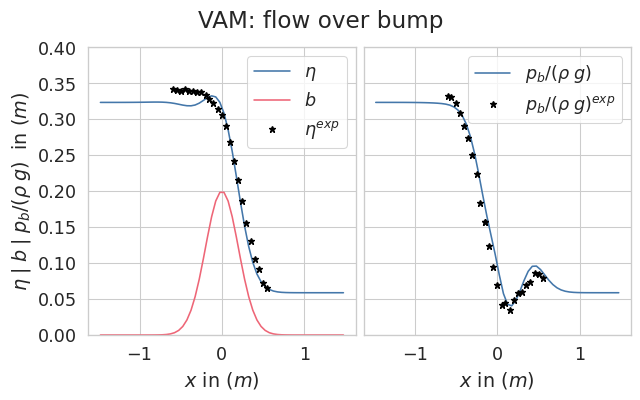

In [22]:
fig = plots_paper.plot_vam(os.path.join(settings.output.directory, settings.name + ".h5"))